# Quantification of shape during growth of gemmae

## Documentation and Imports


Created on 01-04-2021

Author: Valentin Laplaud

This code is performing measurements on the gemma contours computed by 'ShapeParametrisationNB'

This light version has only a few quantification used regularly, the complete version is an archive of all tested quantifications.

In [1]:
## Clean up before script start 

for element in dir():

    if element[0:1] != "_":

        del globals()[element]

import gc
gc.collect()


print('\033[1m' + '\033[4m' + '\nRunning ''ShapeQuantificationNB_Light'' \n' + '\033[0m')

import datetime

# plotting stuff
import matplotlib as mpl
mpl.use('TkAgg')
%matplotlib inline

COLOR = 'white'
COLOR2 = 'black'

mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['axes.edgecolor'] = COLOR

mpl.rcParams["figure.facecolor"] = COLOR2
mpl.rcParams["axes.facecolor"] = COLOR2
mpl.rcParams["savefig.facecolor"] = COLOR2
mpl.rcParams['axes.facecolor'] = COLOR2

import matplotlib.pyplot as plt
import matplotlib.path as mpltPath
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from cycler import cycler
#Default colors
colorcycle = [plt.get_cmap('viridis')(1. * i/10) for i in range(10)]
mpl.rcParams['axes.prop_cycle'] = cycler(color=colorcycle)

# numbers handling
import numpy as np
import pandas as pd

# signal processing 
from scipy.signal import savgol_filter, correlate, correlation_lags
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit, least_squares
from scipy.stats import ranksums

# images handling
from skimage import io
from skimage.filters import threshold_otsu, gaussian, laplace, sobel
from skimage.measure import label, regionprops, regionprops_table
from skimage.util import invert
from skimage.morphology import binary_opening, binary_closing, remove_small_holes,binary_erosion
from skimage.color import rgb2gray
from skimage.segmentation import active_contour, morphological_geodesic_active_contour,morphological_chan_vese, checkerboard_level_set, inverse_gaussian_gradient
import cv2 as cv

# to hide known warnings
import warnings

# General system functions
import os
import shutil
import sys

import time

# my functions
sys.path.append('../PythonFunctions/')
import VallapFunc as vf




Running ShapeQuantificationNB_Light 



## Define analysis functions

###  Mean contour
With and without alignement in time based on dormancy exit 

Contours computed when at least 20 gemmae are averageable

In [2]:
def computeMeanContourTime(CD,GD,Tstarts):
    StackList = np.unique(Tstarts.index)
    
    meanCD = pd.DataFrame(data=None,columns = ['X','Y','Img'])
    meanGD = pd.DataFrame(data=None,columns = ['nppgs','Img'])
    
    # number of contour points
    npts = len(CD.loc[(CD.index == StackList[0]) & (CD['Img'] == 0),'X'])
    
############################## Contours averaged at each time point ###################################################    
    cnt = 0 # number of mean contours done
    
    SL = StackList[:]
    
    nppgs = len(SL)
    
    while nppgs>19:
        
        print('Computing mean contour n°' + str(cnt+1) + ' :')
        
        # Storing variables
        Xs = np.empty((npts,nppgs))
        Xs[:] = np.nan
        Ys = np.empty((npts,nppgs))
        Ys[:] = np.nan


        for s,i in zip(SL,range(len(SL))) :


            Xs[:,i] = CD.loc[(CD.index==s) & (CD['Img'] == int(cnt)), 'X']
            Ys[:,i] = CD.loc[(CD.index==s) & (CD['Img'] == int(cnt)), 'Y']
            

        meanX = np.mean(Xs,axis=1)
        meanY = np.mean(Ys,axis=1)           

        print(str(nppgs) + ' contours averaged together.\n')

        data = {'X':meanX,
                    'Y':meanY,
                    'Img':cnt*np.ones(len(meanX))} 

        newdata = pd.DataFrame(data=data,index = np.repeat('meanCnotal',len(meanX)))

        meanCD = meanCD.append(newdata) # adding to global dataframe
        
        data = {'nppgs':nppgs,
            'Img':cnt} 

        newdata = pd.DataFrame(data=data,index = ['meanCnotal'])
        
        meanGD = meanGD.append(newdata)
        
        
        cnt = cnt+1
        newSL = []
        for s in SL :
            if np.max(CD.loc[s,'Img'])-cnt>0:
                newSL.append(s)
        
        SL = newSL[:]
        
        nppgs = len(SL)
        

 ################################ Contours aligned in time based on dormancy exit ####################################
    cnt = 0 # number of mean contours done
    
    SL = StackList[:]
    
    nppgs = len(SL)

    while nppgs>19:

        print('Computing mean contour (aligned in time) n°' + str(cnt+1) + ' :')

        # Storing variables
        Xs = np.empty((npts,nppgs))
        Xs[:] = np.nan
        Ys = np.empty((npts,nppgs))
        Ys[:] = np.nan


        for s,i in zip(SL,range(len(SL))) :

            Xs[:,i] = CD.loc[(CD.index==s) & (CD['Img'] == int(cnt+Tstarts[s])), 'X']
            Ys[:,i] = CD.loc[(CD.index==s) & (CD['Img'] == int(cnt+Tstarts[s])), 'Y']
            
            GD.loc[(GD.index==s) & (GD['Img'] == int(cnt+Tstarts[s])),'MeanCimg'] = cnt

        meanX = np.mean(Xs,axis=1)
        meanY = np.mean(Ys,axis=1)           

        print(str(nppgs) + ' contours averaged together.\n')

        data = {'X':meanX,
                    'Y':meanY,
                    'Img':cnt*np.ones(len(meanX))} 

        newdata = pd.DataFrame(data=data,index = np.repeat('meanC',len(meanX)))

        meanCD = meanCD.append(newdata) # adding to global dataframe
        
        data = {'nppgs':nppgs,
            'Img':cnt} 

        newdata = pd.DataFrame(data=data,index = ['meanC'])
        
        meanGD = meanGD.append(newdata)
        
        
        cnt = cnt+1
        newSL = []
        for s in SL :
            if np.max(CD.loc[s,'Img'])-Tstarts[s]-cnt>0:
                newSL.append(s)
        
        SL = newSL[:]
        
        nppgs = len(SL)
    
    return(meanCD,meanGD)
            

print('Function defined.')

Function defined.


### Distance to mean contours

In [3]:
def DistToMean(Pfig,CD,GD,CDmean,Expname,**kwargs):
    
    ## Params
    StackList = np.unique(GD.index)
    
    ## Kwargs    
    showPlots = False
    doPlots = False
    
    for key, value in kwargs.items(): 
        if key == 'doPlots':
            doPlots = value
            showPlots = value
        elif key == 'showPlots':
            showPlots = value         
        else:
            print('Unknown key : ' + key + '. Kwarg ignored.')
    
    ## Saving folders
    if not os.path.exists(Pfig + '\\MeanContoursVariability\\'):
        os.mkdir(Pfig + '\\MeanContoursVariability\\') # create general folder  
    
    fullP = Pfig + '\\MeanContoursVariability\\' + Expname + '\\'
    
    if not os.path.exists(fullP):
            os.mkdir(fullP) # create experiment folder 
    
    if not os.path.exists(fullP + '\\OriginalContours\\'):
            os.mkdir(fullP + '\\OriginalContours\\') # create experiment folder  
    
    if not os.path.exists(fullP + '\\NormalizedContours\\'):
            os.mkdir(fullP + '\\NormalizedContours\\') # create experiment folder    
              
############################## Contours averaged at each time point ###################################################      
    nimg = int(np.max(CDmean.loc['meanCnotal','Img']))
    
    for i in range(nimg+1):
        
        print('Computing variability around mean contours (not time aligned) n°' + str(i))
        
        Xmean = CDmean.loc[(CDmean.index == 'meanCnotal') & (CDmean['Img']==i),'X'].values
        Ymean = CDmean.loc[(CDmean.index == 'meanCnotal') & (CDmean['Img']==i),'Y'].values
        
        # normalized mean contour
        XmeanN,YmeanN = vf.normaliseContourByArea(Xmean,Ymean)
        
        if doPlots:                        
            fig1,ax1 = plt.subplots(dpi=300)
            fig1.suptitle(Expname + ' contours+mean (not time aligned) img n°' + str(i))
            ax1.set_aspect('equal', adjustable='box')
            ax1.set_xlabel('X (µm)')
            ax1.set_ylabel('Y (µm)')
            
            
            boundX = [np.max(CDmean.loc[(CDmean.index == 'meanCnotal') & (CDmean['Img']==i),'X'])*1.5,
                      np.min(CDmean.loc[(CDmean.index == 'meanCnotal') & (CDmean['Img']==i),'X'])*1.5]
            boundY = [np.max(CDmean.loc[(CDmean.index == 'meanCnotal') & (CDmean['Img']==i),'Y'])*1.5,
                      np.min(CDmean.loc[(CDmean.index == 'meanCnotal') & (CDmean['Img']==i),'Y'])*1.5]
            
            ax1.plot(boundX,boundY,'ko',ms = 1,zorder = -2)
            
            ax1.plot(Xmean,Ymean,'r-',lw= 2,zorder=0)
            
            fig2,ax2 = plt.subplots(dpi=300)
            fig2.suptitle(Expname + ' normalized contours+mean (not time aligned) img n°' + str(i))
            ax2.set_aspect('equal', adjustable='box')
            ax2.set_xlabel('X (norm)')
            ax2.set_ylabel('Y (norm)') 
            ax2.set_xlim(-0.8,0.8)
            ax2.set_ylim(-0.8,0.8)
        
            ax2.plot(XmeanN,YmeanN,'r-',lw= 2,zorder=0)
        
        for s in StackList:
            
            if not CD.loc[ (CD.index==s) & (CD['Img'] == i ),'X'].values.size==0:                
                
                X = CD.loc[ (CD.index==s) & (CD['Img'] == i ),'X'].values
                Y = CD.loc[ (CD.index==s) & (CD['Img'] == i ),'Y'].values
                
                AllDists = vf.dist(X,Y,Xmean,Ymean)
                MedDist = np.nanmedian(AllDists);
                L2Dist = np.sqrt(np.sum(np.square(AllDists)))/np.sqrt(len(AllDists))
                
                GD.loc[(GD.index==s) & (GD['Img']==i),'NotalMedDist'] = MedDist
                GD.loc[(GD.index==s) & (GD['Img']==i),'NotalL2Dist'] = L2Dist
                
                # normalized mean contour
                XN,YN = vf.normaliseContourByArea(X,Y)
                
                AllDistsN = vf.dist(XN,YN,XmeanN,YmeanN)
                MedDistN = np.nanmedian(AllDistsN);
                L2DistN = np.sqrt(np.sum(np.square(AllDistsN)))/np.sqrt(len(AllDistsN))
                
                GD.loc[(GD.index==s) & (GD['Img']==i),'NotalMedDistNorm'] = MedDistN
                GD.loc[(GD.index==s) & (GD['Img']==i),'NotalL2DistNorm'] = L2DistN
            
                if doPlots:
                    ax1.plot(X,Y,'w-',lw=0.3,zorder=-1)
                    ax2.plot(XN,YN,'w-',lw=0.3,zorder=-1)
        
        
        if doPlots:
            fig1.savefig(fullP + '\\OriginalContours\\' + 'NotalMeanAndVar_Img' + str(i)  + '.png')
            fig2.savefig(fullP + '\\NormalizedContours\\' + 'Norm_NotalMeanAndVar_Img' + str(i)  + '.png')
            
        
            if showPlots:
                plt.show() 
            else:
                plt.close(fig1)
                plt.close(fig2)
                
                
 ################################ Contours aligned in time based on dormancy exit ####################################    
    nimg = int(np.max(CDmean.loc['meanC','Img']))
    
    for i in range(nimg+1):
        
        print('Computing variability around mean contours n°' + str(i))
        
        Xmean = CDmean.loc[(CDmean.index == 'meanC') & (CDmean['Img']==i),'X'].values
        Ymean = CDmean.loc[(CDmean.index == 'meanC') & (CDmean['Img']==i),'Y'].values
        
        # normalized mean contour
        XmeanN,YmeanN = vf.normaliseContourByArea(Xmean,Ymean)
        
        if doPlots:                        
            fig1,ax1 = plt.subplots(dpi=300)
            fig1.suptitle(Expname + ' contours+mean img n°' + str(i))
            ax1.set_aspect('equal', adjustable='box')
            ax1.set_xlabel('X (µm)')
            ax1.set_ylabel('Y (µm)')
            
            
            boundX = [np.max(CDmean.loc[(CDmean.index == 'meanC') & (CDmean['Img']==i),'X'])*1.5,
                      np.min(CDmean.loc[(CDmean.index == 'meanC') & (CDmean['Img']==i),'X'])*1.5]
            boundY = [np.max(CDmean.loc[(CDmean.index == 'meanC') & (CDmean['Img']==i),'Y'])*1.5,
                      np.min(CDmean.loc[(CDmean.index == 'meanC') & (CDmean['Img']==i),'Y'])*1.5]
            
            ax1.plot(boundX,boundY,'ko',ms = 1,zorder = -2)
            
            ax1.plot(Xmean,Ymean,'r-',lw= 2,zorder=0)
            
            fig2,ax2 = plt.subplots(dpi=300)
            fig2.suptitle(Expname + ' normalized contours+mean img n°' + str(i))
            ax2.set_aspect('equal', adjustable='box')
            ax2.set_xlabel('X (norm)')
            ax2.set_ylabel('Y (norm)') 
            ax2.set_xlim(-0.8,0.8)
            ax2.set_ylim(-0.8,0.8)
        
            ax2.plot(XmeanN,YmeanN,'r-',lw= 2,zorder=0)
        
        for s in StackList:
            
            if not GD.loc[(GD.index==s)&(GD['MeanCimg']==i),'Img'].values.size==0:
                
                AlgImg = GD.loc[ (GD.index==s) & (GD['MeanCimg']==i),'Img'].values[0]
                
                X = CD.loc[ (CD.index==s) & (CD['Img'] == AlgImg ),'X'].values
                Y = CD.loc[ (CD.index==s) & (CD['Img'] == AlgImg ),'Y'].values
                
                AllDists = vf.dist(X,Y,Xmean,Ymean)
                MedDist = np.nanmedian(AllDists);
                L2Dist = np.sqrt(np.sum(np.square(AllDists)))/len(AllDists)
                
                GD.loc[(GD.index==s) & (GD['MeanCimg']==i),'MedDist'] = MedDist
                GD.loc[(GD.index==s) & (GD['MeanCimg']==i),'L2Dist'] = L2Dist
                
                # normalized mean contour
                XN,YN = vf.normaliseContourByArea(X,Y)
                
                AllDistsN = vf.dist(XN,YN,XmeanN,YmeanN)
                MedDistN = np.nanmedian(AllDistsN);
                L2DistN = np.sqrt(np.sum(np.square(AllDistsN)))/len(AllDistsN)
                
                GD.loc[(GD.index==s) & (GD['MeanCimg']==i),'MedDistNorm'] = MedDistN
                GD.loc[(GD.index==s) & (GD['MeanCimg']==i),'L2DistNorm'] = L2DistN
            
                if doPlots:
                    ax1.plot(X,Y,'w-',lw=0.3,zorder=-1)
                    ax2.plot(XN,YN,'w-',lw=0.3,zorder=-1)
        
        
        if doPlots:
            fig1.savefig(fullP + '\\OriginalContours\\' + 'MeanAndVar_Img' + str(i)  + '.png')
            fig2.savefig(fullP + '\\NormalizedContours\\' + 'Norm_MeanAndVar_Img' + str(i)  + '.png')
            
        
            if showPlots:
                plt.show() 
            else:
                plt.close(fig1)
                plt.close(fig2)
            
    

### Growth

In [4]:
def GetGrowth(CD,**kwargs):
    
    DebugPlots = False    
    NormalProj = True
    
    for key, value in kwargs.items(): 
        if key == 'DebugPlots':
            DebugPlots = value
        elif key == 'NormalProj':
            NormalProj = value         
        else:
            print('Unknown key : ' + key + '. Kwarg ignored.')
    
    StackList = np.unique(CD.index)
    
    GrowthData = pd.DataFrame(data=None,columns = ['InstantGrowth','TotGrowth','AccumulatedGrowth','Img'])
    
    for s in StackList:
        
        nimg = int(np.max(CD.loc[s, 'Img']))
#         nimg=3
        
        X0 = CD.loc[(CD.index == s) & (CD['Img'] == 0),'X'].values 
        Y0 = CD.loc[(CD.index == s) & (CD['Img'] == 0),'Y'].values
        
        contourVectors_0 = np.array([[x2-x1,y2-y1] for (x1,y1,x2,y2) in zip(np.roll(X0,+1),np.roll(Y0,+1),np.roll(X0,-1),np.roll(Y0,-1))])   

        normalVectors_0 = np.array([vf.getNormal(0,0,x,y,rotation='CCW') for (x,y) in contourVectors_0])
        
        DistAccum = np.zeros(len(X0))
        
        for i in range(1,nimg):
            
            print('Computing growth for ' + s + ' (img : ' + str(i) + ')', end='\r')

            Xi = np.array(CD.loc[(CD.index == s) & (CD['Img'] == i),'X'].values)
            Yi = np.array(CD.loc[(CD.index == s) & (CD['Img'] == i),'Y'].values)
            
            Xi_1 = np.array(CD.loc[(CD.index == s) & (CD['Img'] == i-1),'X'].values)
            Yi_1 = np.array(CD.loc[(CD.index == s) & (CD['Img'] == i-1),'Y'].values)
            
            growthVectors = np.array([[xi-xi_1,yi-yi_1] for (xi,xi_1,yi,yi_1) in zip(Xi,Xi_1,Yi,Yi_1)])
            
            totGrowthVectors = np.array([[xi-x0,yi-y0] for (xi,x0,yi,y0) in zip(Xi,X0,Yi,Y0)])

            contourVectors = np.array([[x2-x1,y2-y1] for (x1,y1,x2,y2) in zip(np.roll(Xi_1,+1),np.roll(Yi_1,+1),np.roll(Xi_1,-1),np.roll(Yi_1,-1))])   

            normalVectors = np.array([vf.getNormal(0,0,x,y,rotation='CCW') for (x,y) in contourVectors])
              
            if NormalProj:
                DistInst = np.array([np.dot(g,n) for (g,n) in zip(growthVectors,normalVectors)])
                DistTot = np.array([np.dot(g,n) for (g,n) in zip(totGrowthVectors,normalVectors_0)])
                DistAccum = np.sum((DistAccum,DistInst),axis=0)
            else:
                DistInst = np.array([np.linalg.norm(g) for g in growthVectors])
                DistTot = np.array([np.linalg.norm(g) for g in totGrowthVectors])
                DistAccum = np.sum((DistAccum,DistInst),axis=0)


            if DebugPlots:
                
                    pos = [991,992,993,994,995,996,997,998,999,0,1,2,3,4,5,6,7,8,9,10,11,12]
                    pos1 = np.linspace(420,450).astype(int)
                    pos2 = np.linspace(730,760).astype(int)
                
                    fig, ax = plt.subplots(ncols = 2,nrows=2,dpi=300)
                    fig.suptitle('Growth between image ' + str(i-1) + ' & ' + str(i+10))

                    ax[0][0].plot(Xi,Yi,'-g',lw=.5) 
                    ax[0][0].plot(Xi_1,Yi_1,'-b',lw=.5) 
                    ax[0][1].plot(Xi[pos],Yi[pos],'-g',lw=.5)  
                    ax[1][0].plot(Xi[pos1],Yi[pos1],'-g',lw=.5)  
                    ax[1][1].plot(Xi[pos2],Yi[pos2],'-g',lw=.5)   

                    for [x,y],xi_1,yi_1 in zip(contourVectors[pos],np.roll(Xi_1[pos],+1),np.roll(Yi_1[pos],+1)):
                        ax[0][1].quiver(xi_1,yi_1,x,y,color='b',scale=1,scale_units='xy')

                    for [x,y],xi_1,yi_1 in zip(growthVectors[pos],Xi_1[pos],Yi_1[pos]):
                        ax[0][1].quiver(xi_1,yi_1,x,y,color='r',scale=1,scale_units='xy')
                        ax[0][0].quiver(xi_1,yi_1,x,y,color='r',scale=1,scale_units='xy',zorder=5)

                    for [x,y],xi_1,yi_1,d in zip(normalVectors[pos],Xi_1[pos],Yi_1[pos],DistInst[pos]):
                        ax[0][1].quiver(xi_1,yi_1,x,y,color='c',scale=1,scale_units='xy',zorder=5)
                        ax[0][1].plot([xi_1,xi_1+d*x],[yi_1,yi_1+d*y],'-m',lw=.5)
                        

                        
                    for [x,y],xi_1,yi_1 in zip(contourVectors[pos1],np.roll(Xi_1[pos1],+1),np.roll(Yi_1[pos1],+1)):
                        ax[1][0].quiver(xi_1,yi_1,x,y,color='b',scale=1,scale_units='xy')

                    for [x,y],xi_1,yi_1 in zip(growthVectors[pos1],Xi_1[pos1],Yi_1[pos1]):
                        ax[1][0].quiver(xi_1,yi_1,x,y,color='r',scale=1,scale_units='xy')
                        ax[0][0].quiver(xi_1,yi_1,x,y,color='r',scale=1,scale_units='xy',zorder=5)

                    for [x,y],xi_1,yi_1,d in zip(normalVectors[pos1],Xi_1[pos1],Yi_1[pos1],DistInst[pos1]):
                        ax[1][0].quiver(xi_1,yi_1,x,y,color='c',scale=1,scale_units='xy')
                        ax[1][0].plot([xi_1,xi_1+d*x],[yi_1,yi_1+d*y],'-m',lw=.5)
                        

                        
                    for [x,y],xi_1,yi_1 in zip(contourVectors[pos2],np.roll(Xi_1[pos2],+1),np.roll(Yi_1[pos2],+1)):
                        ax[1][1].quiver(xi_1,yi_1,x,y,color='b',scale=1,scale_units='xy')

                    for [x,y],xi_1,yi_1 in zip(growthVectors[pos2],Xi_1[pos2],Yi_1[pos2]):
                        ax[1][1].quiver(xi_1,yi_1,x,y,color='r',scale=1,scale_units='xy')
                        ax[0][0].quiver(xi_1,yi_1,x,y,color='r',scale=1,scale_units='xy',zorder=5)

                    for [x,y],xi_1,yi_1,d in zip(normalVectors[pos2],Xi_1[pos2],Yi_1[pos2],DistInst[pos2]):
                        ax[1][1].quiver(xi_1,yi_1,x,y,color='c',scale=1,scale_units='xy')
                        ax[1][1].plot([xi_1,xi_1+d*x],[yi_1,yi_1+d*y],'-m',lw=.5)

                        
                    ax[0][1].plot(Xi_1[pos],Yi_1[pos], 'og',ms=.5)
                    ax[0][1].plot(Xi[pos],Yi[pos],'og',ms=.5)    
                    ax[1][0].plot(Xi_1[pos1],Yi_1[pos1], 'og',ms=.5)
                    ax[1][0].plot(Xi[pos1],Yi[pos1],'og',ms=.5)    
                    ax[1][1].plot(Xi_1[pos2],Yi_1[pos2], 'og',ms=.5)
                    ax[1][1].plot(Xi[pos2],Yi[pos2],'og',ms=.5)    
                    ax[0][0].set_aspect('equal')
                    ax[0][1].set_aspect('equal')  
                    ax[1][0].set_aspect('equal')
                    ax[1][1].set_aspect('equal')
                    
                    fig.tight_layout()
            

            data = {'InstantGrowth':DistInst,
                    'TotGrowth' : DistTot,
                    'AccumulatedGrowth' : DistAccum,
                    'Img':i} 

            newdata = pd.DataFrame(data=data,index = np.repeat(s,len(DistInst)))
            
            GrowthData = GrowthData.append(newdata)
                  
        print('Computing growth for ' + s + ' (DONE)'.ljust(20),end='\n')
            
        
    return(GrowthData)
            

    

### Symmetry

In [5]:
def computeSym(CD,GD):
    StackList = np.unique(CD.index)
    
    for s in StackList:
        
        nimg = int(np.max(CD.loc[s, 'Img']))+1
#         nimg = 1
        
        sym = np.empty(nimg)
        symN = np.empty(nimg)
        symNotch = np.empty(nimg)
        symNotchN = np.empty(nimg)
        
        for i in range(nimg):
            
            print('Computing symmetry for ' + s + ' (img : ' + str(i) + ')', end='\r')

            Xi = CD.loc[(CD.index == s) & (CD['Img'] == i),'X'].values 
            Yi = CD.loc[(CD.index == s) & (CD['Img'] == i),'Y'].values
            
            XiN,YiN = vf.normaliseContourByArea(Xi,Yi)
            
            XiL = np.concatenate((Xi[750:1000],Xi[0:250]))
            YiL = np.concatenate((Yi[750:1000],Yi[0:250]))
            
            XiR = Xi[250:750]
            YiR = Yi[250:750]
            
            XiRr = np.flip(-XiR)
            YiRr = np.flip(YiR)
            
            XiLna = XiL - XiL[250]
            YiLna = YiL - YiL[250]
            
            XiRna = XiRr - XiRr[250]
            YiRna = YiRr - YiRr[250]
            
            XiRda,YiRda = RotTransAlignement(XiRr[:],YiRr[:],XiL[:],YiL[:]
                                         ,np.linspace(-20,20,81),np.linspace(-20,20,81),np.linspace(-20,20,81),False)
            
            
#             fig,ax = plt.subplots(dpi= 300)
#             ax.set_title('Original contour')
#             ax.plot(XiL,YiL,'-b',lw=1)
#             ax.plot(XiR,YiR,'-r',lw=1)
#             ax.set_aspect('equal')
            
#             fig, [ax2,ax3] = plt.subplots(ncols = 2, dpi = 300)
            
#             ax2.set_title('Notch Aligned')
#             ax2.plot(XiLna,YiLna,'-b',lw=1)
#             ax2.plot(XiRna,YiRna,'-r',lw=1)
#             ax2.plot([np.transpose(XiLna[0:500:25]),np.transpose(XiRna[0:500:25])],
#                      [np.transpose(YiLna[0:500:25]),np.transpose(YiRna[0:500:25])],'o-w',ms=2,lw=1.3)
#             ax2.set_aspect('equal')
            
#             ax3.set_title('Distance aligned')
#             ax3.plot(XiL,YiL,'-b',lw=1)
#             ax3.plot(XiRda,YiRda,'-r',lw=1)
#             ax3.plot([np.transpose(XiL[0:500:25]),np.transpose(XiRda[0:500:25])],
#                      [np.transpose(YiL[0:500:25]),np.transpose(YiRda[0:500:25])],'o-w',ms=2,lw=1.3)
#             ax3.set_aspect('equal')
            
#             fig.tight_layout()
            
#             plt.show()
            

            sym[i] = np.median(vf.dist(XiL,YiL,XiRda,YiRda))
            
            symNotch[i] = np.median(vf.dist(XiLna,YiLna,XiRna,YiRna))
            
            
            
            XiLN = np.concatenate((XiN[750:1000],XiN[0:250]))
            YiLN = np.concatenate((YiN[750:1000],YiN[0:250]))
            
            XiRN = XiN[250:750]
            YiRN = YiN[250:750]
            
            XiRrN = np.flip(-XiRN)
            YiRrN = np.flip(YiRN)
            
            XiLnaN = XiLN - XiLN[250]
            YiLnaN = YiLN - YiLN[250]
            
            XiRnaN = XiRrN - XiRrN[250]
            YiRnaN = YiRrN - YiRrN[250]
            
            XiRdaN,YiRdaN = RotTransAlignement(XiRrN[:],YiRrN[:],XiLN[:],YiLN[:]
                                         ,np.linspace(-20,20,81),np.linspace(-20,20,81),np.linspace(-20,20,81),False)
            
            symN[i] = np.median(vf.dist(XiLN,YiLN,XiRdaN,YiRdaN))
            
            symNotchN[i] = np.median(vf.dist(XiLnaN,YiLnaN,XiRnaN,YiRnaN))
            
            GD.loc[(GD.index == s) & (GD['Img'] == i),'Sym'] = sym[i]
            GD.loc[(GD.index == s) & (GD['Img'] == i),'SymNotch'] = symNotch[i]
            GD.loc[(GD.index == s) & (GD['Img'] == i),'SymNorm'] = symN[i]
            GD.loc[(GD.index == s) & (GD['Img'] == i),'SymNotchNorm'] = symNotchN[i]
         
        print('Computing symmetry for ' + s + ' (DONE)'.ljust(20), end='\n')
        

            
            

#### Rotation-translation alignement of two curves point by point (from 3_ShapeParametrisationNB copied on 08/06/2022)

In [6]:
def RotTransAlignement(X,Y,Xref,Yref,RotRange,Xrange,Yrange,debug):

    ## Vectors sizes
    XYsize = np.size(X)
    
    if not np.size(Y)==XYsize:
        raise ValueError('X and Y must have the same size !')
    elif not np.size(Xref)==XYsize:
        raise ValueError('X and Xref must have the same size !')
    elif not np.size(Yref)==XYsize:
        raise ValueError('X and Yref must have the same size !')
    
    RotSize = np.size(RotRange)
    TXsize = np.size(Xrange)
    TYsize = np.size(Yrange)
    
    ## Average positions
    Xcenter = X.mean()
    Ycenter = Y.mean()
#     XrefCenter = Xref.mean()
#     YrefCenter = Yref.mean()
    
    ## redifine shape for 4D matrix creation
    Xref.shape=(XYsize,1,1,1) # Original coordinates, rotation, Xtranslation, Ytranslation
    Yref.shape=(XYsize,1,1,1)

    X.shape=(XYsize,1,1,1)
    Y.shape=(XYsize,1,1,1)

    RotRange.shape = (1,RotSize,1,1)
    Xrange.shape = (1,1,TXsize,1)
    Yrange.shape = (1,1,1,TYsize)

    ## Addind rotation range
    T,R = vf.ToCirc(X-Xcenter,Y-Ycenter,angle='deg')
    
    Trange = np.mod(T + RotRange,360)
    Rrange = np.tile(R,(1,RotSize,1,1))

    XrotMat,YrotMat = vf.ToCart(Trange,Rrange,angle='deg')

    XrotMat = XrotMat + Xcenter # size = (XYsize,RotSize,1,1)
    YrotMat = YrotMat + Ycenter 
    
    ## Adding X translation
    
    XrotTX = XrotMat + Xrange # size = (XYsize,RotSize,TXsize,1)
    YrotTX = np.tile(YrotMat,(1,1,TXsize,1))
    
    del(XrotMat,YrotMat)
    
    ## Adding Y translation
    
    XrotTXY = np.tile(XrotTX,(1,1,1,TYsize)) # size = (XYsize,RotSize,TXsize,TYsize)
    YrotTXY = YrotTX + Yrange
    
    del(XrotTX,YrotTX)
    
    ## Duplicating references 

    Xref = np.tile(Xref,(1,RotSize,TXsize,TYsize))
    Yref = np.tile(Yref,(1,RotSize,TXsize,TYsize))
    
    
    ## Mean square distance computation

    D = vf.dist(XrotTXY,YrotTXY,Xref,Yref)
    

    SD = np.square(D)

    MSD = np.mean(SD,axis=0)
    
    ## finding best alignement
    
    ind = np.unravel_index(np.argmin(MSD), MSD.shape)

    Xal = XrotTXY[:,ind[0],ind[1],ind[2]]
    Yal = YrotTXY[:,ind[0],ind[1],ind[2]]

#     fig, ax = plt.subplots(dpi=150)
#     fig.suptitle('X and Y')
#     sns.heatmap(MSD[],cmap = 'gist_rainbow',vmin=0)

    if debug:
        ## Result plotting
        f,ax = plt.subplots(dpi=200,figsize=(5,5))
        f.suptitle('Contour alignement result')
        ax.plot(X[:,0,0,0],Y[:,0,0,0],'-b',label='Contour to align')
        ax.plot(Xref[:,0,0,0],Yref[:,0,0,0],'-w',label='Reference contour')
        ax.plot(Xal,Yal,'m-',ms=2,lw=1,label='Aligned contour')
        ax.set_aspect('equal',adjustable='box')
        plt.legend(fontsize = 'xx-small')
        plt.show()

        ## Variable space visualisation

        plt.rcParams.update({'font.size': 6})

        f,[ax1,ax2] = plt.subplots(dpi=200,ncols=2)

        ax1.set_title('at original rotation')
        ax1.set_aspect(TXsize/TYsize)
        sns.heatmap(MSD[int(np.round(RotSize/2)),:,:],cmap = 'gist_rainbow',
                         vmin=0,ax=ax1,cbar_kws = {'shrink':0.5})
        ax1.set_xlabel('Y translation')
        ax1.set_ylabel('X translation')
        ax1.set_xticks(np.linspace(0,TYsize,10))
        ax1.set_xticklabels(Yrange[0,0,0,0:-1:int(np.round(TYsize/10))])
        ax1.set_yticks(np.linspace(0,TXsize,10))
        ax1.set_yticklabels(Xrange[0,0,0:-1:int(np.round(TXsize/10)),0])

        ax2.set_title('at aligned rotation')
        ax2.set_aspect(TXsize/TYsize)
        sns.heatmap(MSD[ind[0],:,:],cmap = 'gist_rainbow',
                         vmin=0,ax=ax2,cbar_kws = {'shrink':0.5})
        ax2.set_xlabel('Y translation')
        ax2.set_ylabel('X translation')
        ax2.set_xticks(np.linspace(0,TYsize,10))
        ax2.set_xticklabels(Yrange[0,0,0,0:-1:int(np.round(TYsize/10))])
        ax2.set_yticks(np.linspace(0,TXsize,10))
        ax2.set_yticklabels(Xrange[0,0,0:-1:int(np.round(TXsize/10)),0])

        f.tight_layout()


        f,[ax1,ax2] = plt.subplots(dpi=200,ncols=2)

        ax1.set_title('at original Y')
        ax1.set_aspect(TXsize/RotSize)
        hm = sns.heatmap(MSD[:,:,int(np.round(TYsize/2))],cmap = 'gist_rainbow',
                         vmin=0,ax=ax1,cbar_kws = {'shrink':0.5})
        ax1.set_xlabel('X translation')
        ax1.set_ylabel('Rotation')
        ax1.set_xticks(np.linspace(0,TXsize,10))
        ax1.set_xticklabels(Xrange[0,0,0:-1:int(np.round(TXsize/10)),0])
        ax1.set_yticks(np.linspace(0,RotSize,10))
        ax1.set_yticklabels(RotRange[0,0:-1:int(np.round(RotSize/10)),0,0])

        ax2.set_title('at aligned Y')
        ax2.set_aspect(TXsize/RotSize)
        sns.heatmap(MSD[:,:,ind[2]],cmap = 'gist_rainbow',
                         vmin=0,ax=ax2,cbar_kws = {'shrink':0.5})
        ax2.set_xlabel('X translation')
        ax2.set_ylabel('Rotation')
        ax2.set_xticks(np.linspace(0,TXsize,10))
        ax2.set_xticklabels(Xrange[0,0,0:-1:int(np.round(TXsize/10)),0])
        ax2.set_yticks(np.linspace(0,RotSize,10))
        ax2.set_yticklabels(RotRange[0,0:-1:int(np.round(RotSize/10)),0,0])

        f.tight_layout()


        f,[ax1,ax2] = plt.subplots(dpi=200,ncols=2)

        ax1.set_title('at original X')
        ax1.set_aspect(TYsize/RotSize)
        sns.heatmap(MSD[:,int(np.round(TXsize/2)),:],cmap = 'gist_rainbow',
                         vmin=0,ax=ax1,cbar_kws = {'shrink':0.5})
        ax1.set_xlabel('Y translation')
        ax1.set_ylabel('Rotation')
        ax1.set_xticks(np.linspace(0,TYsize,10))
        ax1.set_xticklabels(Yrange[0,0,0,0:-1:int(np.round(TYsize/10))])
        ax1.set_yticks(np.linspace(0,RotSize,10))
        ax1.set_yticklabels(RotRange[0,0:-1:int(np.round(RotSize/10)),0,0])

        ax2.set_title('at aligned X')
        ax2.set_aspect(TYsize/RotSize)
        sns.heatmap(MSD[:,ind[1],:],cmap = 'gist_rainbow',
                         vmin=0,ax=ax2,cbar_kws = {'shrink':0.5})
        ax2.set_xlabel('Y translation')
        ax2.set_ylabel('Rotation')
        ax2.set_xticks(np.linspace(0,TYsize,10))
        ax2.set_xticklabels(Yrange[0,0,0,0:-1:int(np.round(TYsize/10))])
        ax2.set_yticks(np.linspace(0,RotSize,10))
        ax2.set_yticklabels(RotRange[0,0:-1:int(np.round(RotSize/10)),0,0])

        f.tight_layout()
    
    del(XrotTXY,YrotTXY,RotRange,Xrange,Yrange,X,Y,Xref,Yref)
    
    gc.collect();
    
    return(Xal,Yal)

## Plot fuctions

### Plot evolution of individual contours in time.

In [7]:
def plotIndiContours(Pfig,CD, Expname, **kwargs):
    ## Params
    StackList = np.unique(CD.index)
    
    Plots = False
    
    for key, value in kwargs.items(): 
        if key == 'showplots':
            Plots = value
        else:
            print('Unknown key : ' + key + '. Kwarg ignored.')
    
    if not os.path.exists(Pfig + '\\IndividualContours\\'):
        os.mkdir(Pfig + '\\IndividualContours\\') # create general folder  
    
    fullP = Pfig + '\\IndividualContours\\' + Expname + '\\'
    
    if not os.path.exists(fullP):
            os.mkdir(fullP) # create experiment folder        
            
    for s in StackList:
        
        if not os.path.exists(fullP + '\\' + s + '\\'):
            os.mkdir(fullP + '\\' + s + '\\') # create gemmae folder 
            
        nimg = int(np.max(CD.loc[s, 'Img']))
        
        fig1, ax1 = plt.subplots(dpi=350)
        fig1.suptitle(s + ' contours in time.')
        ax1.set_aspect('equal', adjustable='box')
        ax1.set_xlabel('X (µm)')
        ax1.set_ylabel('Y (µm)')
        
        # plot invisible X,Y extremes to set the figure size
        X = [CD.loc[s,'X'].min(),CD.loc[s,'X'].max()]
        Y = [CD.loc[s,'Y'].min(),CD.loc[s,'Y'].max()]
        ax1.plot(X,Y,color = 'k')
        
        colorcycle = [plt.get_cmap('YlOrBr')(1. * i/nimg) for i in range(nimg)]
        
        for i in range(nimg):

            X = CD.loc[(CD.index == s) & (CD['Img'] == i),'X']  
            Y = CD.loc[(CD.index == s) & (CD['Img'] == i),'Y']

            ax1.plot(X,Y,color = colorcycle[i])
            
            fig1.savefig(fullP  + '\\' + s + '\\' + s + ' - ' + str(i)  + '.png')
            
        
        if Plots:
            plt.show()
        else:
            plt.close(fig1)
        
        
        

### Plot distances to mean contour

In [30]:
def plotMeanDist(Pfig,GDs,Expname,colors,Times):
    
    Pfolder = Pfig + '\\MeanContoursVariability\\'
    if not os.path.exists(Pfolder):
        os.mkdir(Pfolder) # create general folder  
    ## Evolution in time per experiment
    
    fig00,ax00 = plt.subplots(dpi=250) 
    fig00.suptitle('Distance to mean contours at 20h')
    ax00.set_ylabel('Median distance to mean contour (µm)')
    
    for j in range(len(Expname)):
        GD = GDs[j]
        
        ## Saving folders
        fullP = Pfolder + Expname[j] + '\\'

        if not os.path.exists(fullP):
                os.mkdir(fullP) # create experiment folder  

        ## Params
        StackList = np.unique(GD.index)

        ## Preping figs
        fig0,ax0 = plt.subplots(dpi=250) 
        fig0.suptitle('Evolution of median distance to mean for ' + Expname[j])
        ax0.set_xlabel('Time after dormancy exit (hours)')
        ax0.set_ylabel('Median distance to mean contour (µm)')
        
        
        fig1,ax1 = plt.subplots(dpi=250) 
        fig1.suptitle('Evolution of median distance to normalized mean for ' + Expname[j])
        ax1.set_xlabel('Time after dormancy exit (hours)')
        ax1.set_ylabel('Median distance to mean contour (norm)')
        
        
        fig2,ax2 = plt.subplots(dpi=250) 
        fig2.suptitle('Evolution of L2 distance to mean for ' + Expname[j])
        ax2.set_xlabel('Time after dormancy exit (hours)')
        ax2.set_ylabel('L2 distance to mean contour (µm)')
        
        
        fig3,ax3 = plt.subplots(dpi=250) 
        fig3.suptitle('Evolution of L2 distance to \nnormalized mean for ' + Expname[j])
        ax3.set_xlabel('Time after dormancy exit (hours)')
        ax3.set_ylabel('L2 distance to mean contour (norm)')
        
        
        fig4,ax4 = plt.subplots(dpi=250) 
        fig4.suptitle('Evolution of median distance to \nmean (not aligned in time) for ' + Expname[j])
        ax4.set_xlabel('Time after experiment start (hours)')
        ax4.set_ylabel('Median distance to mean contour (µm)')
        
        
        fig5,ax5 = plt.subplots(dpi=250) 
        fig5.suptitle('Evolution of median distance to \nnormalized mean (not aligned in time) for ' + Expname[j])
        ax5.set_xlabel('Time after experiment start (hours)')
        ax5.set_ylabel('Median distance to mean contour (norm)')
        
        
        fig6,ax6 = plt.subplots(dpi=250) 
        fig6.suptitle('Evolution of L2 distance to \nmean (not aligned in time) for ' + Expname[j])
        ax6.set_xlabel('Time after experiment start (hours)')
        ax6.set_ylabel('L2 distance to mean contour (µm)')
        
        
        fig7,ax7 = plt.subplots(dpi=250) 
        fig7.suptitle('Evolution of L2 distance to \nnormalized mean (not aligned in time) for ' + Expname[j])
        ax7.set_xlabel('Time after experiment start (hours)')
        ax7.set_ylabel('L2 distance to mean contour (norm)')
        
        
        plotprops = {'color':'white'}
        boxprops = {'color':'white','facecolor':colors[j]}

        grouping = []
        grouping_NotAl = []
        
        fullMedDist = []
        fullMedDistN = []
        fullL2Dist = []
        fullL2DistN = []
        
        fullMedDist_NotAl = []
        fullMedDistN_NotAl = []
        fullL2Dist_NotAl = []
        fullL2DistN_NotAl = []
        
        cnt = 0
        
        ## Main code
        for t in Times:
            
            MedDist = GD.loc[(GD['MeanCimg']==t*2),'MedDist'].values
            MedDistN = GD.loc[(GD['MeanCimg']==t*2),'MedDistNorm'].values
            L2Dist = GD.loc[(GD['MeanCimg']==t*2),'L2Dist'].values
            L2DistN = GD.loc[(GD['MeanCimg']==t*2),'L2DistNorm'].values
            
            fullMedDist = np.append(fullMedDist,MedDist)
            fullMedDistN = np.append(fullMedDistN,MedDistN)
            fullL2Dist = np.append(fullL2Dist,L2Dist)
            fullL2DistN = np.append(fullL2DistN,L2DistN)
            
            MedDist_NotAl = GD.loc[(GD['Img']==t*2),'NotalMedDist'].values
            MedDistN_NotAl = GD.loc[(GD['Img']==t*2),'NotalMedDistNorm'].values
            L2Dist_NotAl = GD.loc[(GD['Img']==t*2),'NotalL2Dist'].values
            L2DistN_NotAl = GD.loc[(GD['Img']==t*2),'NotalL2DistNorm'].values
            
            fullMedDist_NotAl = np.append(fullMedDist_NotAl,MedDist_NotAl)
            fullMedDistN_NotAl = np.append(fullMedDistN_NotAl,MedDistN_NotAl)
            fullL2Dist_NotAl = np.append(fullL2Dist_NotAl,L2Dist_NotAl)
            fullL2DistN_NotAl = np.append(fullL2DistN_NotAl,L2DistN_NotAl)
            
            grouping = np.append(grouping,np.ones(len(MedDist))*t)
            grouping_NotAl = np.append(grouping_NotAl,np.ones(len(MedDist_NotAl))*t)

            if t == 20:
                ax00.boxplot(MedDist, positions = [j], patch_artist = True, widths = [0.7],
                            boxprops=boxprops, capprops =plotprops,
                            showfliers = False,whiskerprops=plotprops,medianprops =plotprops)
            
            ax0.boxplot(MedDist, positions = [cnt], patch_artist = True, widths = [0.7],
                        boxprops=boxprops, capprops =plotprops,
                        showfliers = False,whiskerprops=plotprops,medianprops =plotprops)
            
            ax1.boxplot(MedDistN, positions = [cnt], patch_artist = True, widths = [0.7],
                        boxprops=boxprops, capprops =plotprops,
                        showfliers = False,whiskerprops=plotprops,medianprops =plotprops)  

            ax2.boxplot(L2Dist, positions = [cnt], patch_artist = True, widths = [0.7],
                        boxprops=boxprops, capprops =plotprops,
                        showfliers = False,whiskerprops=plotprops,medianprops =plotprops)
            
            ax3.boxplot(L2DistN, positions = [cnt], patch_artist = True, widths = [0.7],
                        boxprops=boxprops, capprops =plotprops,
                        showfliers = False,whiskerprops=plotprops,medianprops =plotprops)  

            
            ax4.boxplot(MedDist_NotAl, positions = [cnt], patch_artist = True, widths = [0.7],
                        boxprops=boxprops, capprops =plotprops,
                        showfliers = False,whiskerprops=plotprops,medianprops =plotprops)
            
            ax5.boxplot(MedDistN_NotAl, positions = [cnt], patch_artist = True, widths = [0.7],
                        boxprops=boxprops, capprops =plotprops,
                        showfliers = False,whiskerprops=plotprops,medianprops =plotprops)  

            ax6.boxplot(L2Dist_NotAl, positions = [cnt], patch_artist = True, widths = [0.7],
                        boxprops=boxprops, capprops =plotprops,
                        showfliers = False,whiskerprops=plotprops,medianprops =plotprops)
            
            ax7.boxplot(L2DistN_NotAl, positions = [cnt], patch_artist = True, widths = [0.7],
                        boxprops=boxprops, capprops =plotprops,
                        showfliers = False,whiskerprops=plotprops,medianprops =plotprops)            
            
            cnt = cnt+1
            
        sns.swarmplot(x=grouping,y=fullMedDist,color = 'lightgray', size=2, ax = ax0)
        ax0.set_xlim(left=-0.7,right=cnt-0.3)
        ax0.set_xticklabels(Times)
        
        sns.swarmplot(x=grouping,y=fullMedDistN,color = 'lightgray', size=2, ax = ax1)
        ax1.set_xlim(left=-0.7,right=cnt-0.3)
        ax1.set_xticklabels(Times)
            
        sns.swarmplot(x=grouping,y=fullL2Dist,color = 'lightgray', size=2, ax = ax2)
        ax2.set_xlim(left=-0.7,right=cnt-0.3)
        ax2.set_xticklabels(Times)
        
        sns.swarmplot(x=grouping,y=fullL2DistN,color = 'lightgray', size=2, ax = ax3)
        ax3.set_xlim(left=-0.7,right=cnt-0.3)
        ax3.set_xticklabels(Times)
            
        sns.swarmplot(x=grouping_NotAl,y=fullMedDist_NotAl,color = 'lightgray', size=2, ax = ax4)
        ax4.set_xlim(left=-0.7,right=cnt-0.3)
        ax4.set_xticklabels(Times)
        
        sns.swarmplot(x=grouping_NotAl,y=fullMedDistN_NotAl,color = 'lightgray', size=2, ax = ax5)
        ax5.set_xlim(left=-0.7,right=cnt-0.3)
        ax5.set_xticklabels(Times)
            
        sns.swarmplot(x=grouping_NotAl,y=fullL2Dist_NotAl,color = 'lightgray', size=2, ax = ax6)
        ax6.set_xlim(left=-0.7,right=cnt-0.3)
        ax6.set_xticklabels(Times)
        
        sns.swarmplot(x=grouping_NotAl,y=fullL2DistN_NotAl,color = 'lightgray', size=2, ax = ax7)
        ax7.set_xlim(left=-0.7,right=cnt-0.3)
        ax7.set_xticklabels(Times)
        
        fig0.savefig(fullP + 'MedDistToMean.png')
        fig1.savefig(fullP + 'MedDistToMeanNorm.png')
        fig2.savefig(fullP + 'L2DistToMean.png')
        fig3.savefig(fullP + 'L2DistToMeanNorm.png')
        
        fig4.savefig(fullP + 'MedDistToMeanNotAl.png')
        fig5.savefig(fullP + 'MedDistToMeanNormNotAl.png')
        fig6.savefig(fullP + 'L2DistToMeanNotAl.png')
        fig7.savefig(fullP + 'L2DistToMeanNormNotAl.png')
    
        ax00.set_xticklabels(Expname)
        
        
     ### Comparison between experiments    
#     if len(GDs)>1:       
#         for t in Times:
#             ## Preping figs
#             fig1,ax1 = plt.subplots(dpi=250) 
#             fig1.suptitle('Median distance to mean ' + str(t) + ' hours after dormancy exit')
            
#             fig2,ax2 = plt.subplots(dpi=250) 
#             fig2.suptitle('Median distance to normalized mean ' + str(t) + ' hours after dormancy exit')

#             MedDist = [None]*len(GDs)
#             MedDistN = [None]*len(GDs)
#             cap = [None]*len(GDs)
#             capN = [None]*len(GDs)
#             grouping = []
#             fullMedDist = []
#             fullMedDistN = []
#             cnt = 0

#             for j in range(len(Expname)):
#                 GD = GDs[j]
#                 plotprops = {'color':'white'}
#                 boxprops = {'color':'white','facecolor':colors[j]}

#                 MedDist[j] = GD.loc[(GD['MeanCimg']==t*2),'MedDist']
#                 MedDistN[j] = GD.loc[(GD['MeanCimg']==t*2),'MedDistNorm']

#                 fullMedDist = np.append(fullMedDist,MedDist[j].values)
#                 fullMedDistN = np.append(fullMedDistN,MedDistN[j].values)
#                 grouping = np.append(grouping,np.ones(len(MedDist[j]))*j)

#                 bp = ax1.boxplot(MedDist[j], positions = [cnt], patch_artist = True, widths = [0.7],
#                             boxprops=boxprops, capprops =plotprops,
#                             showfliers = False,whiskerprops=plotprops,medianprops =plotprops)

#                 bpN = ax2.boxplot(MedDistN[j], positions = [cnt], patch_artist = True, widths = [0.7],
#                             boxprops=boxprops, capprops =plotprops,
#                             showfliers = False,whiskerprops=plotprops,medianprops =plotprops)
#                 cnt = cnt+1

#                 cap[j] = bp['caps'][1].get_yMedDist(orig=True)[0]
#                 capN[j] = bpN['caps'][1].get_yMedDist(orig=True)[0]

#             sns.swarmplot(x=grouping,y=fullMedDist,color = 'lightgray', size=2, ax = ax1)
#             ax1.set_xlim(left=-0.7,right=cnt-0.3)
#             ax1.set_xticklabels(Expname)

#             sns.swarmplot(x=grouping,y=fullMedDistN,color = 'lightgray', size=2, ax = ax2)
#             ax2.set_xlim(left=-0.7,right=cnt-0.3)
#             ax2.set_xticklabels(Expname)

#             step = np.max(cap)*0.125
#             stepN = np.max(capN)*0.125
#             fullstep = 0
#             fullstepN = 0
#             hmax = np.max(cap)
#             hmaxN = np.max(capN)


#             for i in range(len(GDs)-1):
#                 for j in range(i+1,len(GDs)):

#                     fullstep = plotSig(ax1,hmax,step,fullstep,MedDist[i],MedDist[j],i,j)
#                     fullstepN = plotSig(ax2,hmaxN,stepN,fullstepN,MedDistN[i],MedDistN[j],i,j)

#             fig1.savefig(Pfolder + '_'.join(Expname) + '_t=' + str(t) + 'h_MedDistToMean.png')
#             fig2.savefig(Pfolder + '_'.join(Expname) + '_t=' + str(t) + 'h_MedDistToMeanNorm.png')

### Plot distances between mean contours from different experiments

In [9]:
def DistBetwMean(Pfig,CDMeans,GDMeans,Expnames, **kwargs):
    N = len(CDMeans)
    
    Pfolder = Pfig + '\\MeanContoursDistance\\'
    Pfolder2 = Pfolder + '\\2by2\\'
    
    indiplots = True
    commonplots = True
    
    for key, value in kwargs.items(): 
        if key == 'indiplots':
            indiplots = value
        elif key == 'commonplots':
            commonplots = value
        else:
            print('Unknown key : ' + key + '. Kwarg ignored.')
    
    AllLabels = []
    
    if not os.path.exists(Pfolder):
        os.mkdir(Pfolder) # create general folder  
    if not os.path.exists(Pfolder2):
        os.mkdir(Pfolder2) # create general folder  
    
    if commonplots:
        fig00,ax00 = plt.subplots(dpi=350)
        fig00.suptitle('Median distance between mean contours')
        ax00.set_xlabel('Time after dormancy exit (hours)')
        ax00.set_ylabel('Distance (µm)')

        fig01,ax01 = plt.subplots(dpi=350)
        fig01.suptitle('Median distance between normalized mean contours')
        ax01.set_xlabel('Time after dormancy exit (hours)')
        ax01.set_ylabel('Distance (norm)')

        fig02,ax02 = plt.subplots(dpi=350)
        fig02.suptitle('Median distance between mean contours (not time aligned)')
        ax02.set_xlabel('Time after dormancy exit (hours)')
        ax02.set_ylabel('Distance (µm)')

        fig03,ax03 = plt.subplots(dpi=350)
        fig03.suptitle('Median distance between normalized mean contours (not time aligned)')
        ax03.set_xlabel('Time after dormancy exit (hours)')
        ax03.set_ylabel('Distance (norm)')

        fig04,ax04 = plt.subplots(dpi=350)
        fig04.suptitle('L2 distance between mean contours')
        ax04.set_xlabel('Time after experiment start (hours)')
        ax04.set_ylabel('Distance (µm)')

        fig05,ax05 = plt.subplots(dpi=350)
        fig05.suptitle('L2 distance between normalized mean contours')
        ax05.set_xlabel('Time after experiment start (hours)')
        ax05.set_ylabel('Distance (norm)')

        fig06,ax06 = plt.subplots(dpi=350)
        fig06.suptitle('L2 distance between mean contours (not time aligned)')
        ax06.set_xlabel('Time after experiment start (hours)')
        ax06.set_ylabel('Distance (µm)')

        fig07,ax07 = plt.subplots(dpi=350)
        fig07.suptitle('L2 distance between normalized mean contours (not time aligned)')
        ax07.set_xlabel('Time after experiment start (hours)')
        ax07.set_ylabel('Distance (norm)')
    
    for i in range(0,N-1):
        for j in range(i+1,N):
            
            label = Expnames[i] + ' & ' + Expnames[j]
            AllLabels = np.append(AllLabels,label)
            
            if indiplots:
                fig0,ax0 = plt.subplots(nrows =2, dpi=350)
                fig0.suptitle('Median distance between mean contours from \n' + label)
                ax0[1].set_xlabel('Time after dormancy exit (hours)')
                ax0[1].set_ylabel('Number of avg cnts')
                ax0[0].set_ylabel('Distance (µm)')

                fig1,ax1 = plt.subplots(dpi=350)
                fig1.suptitle('Median distance between normalized mean contours from \n' + label)
                ax1.set_xlabel('Time after dormancy exit (hours)')
                ax1.set_ylabel('Distance (norm)')

                fig2,ax2 = plt.subplots(dpi=350)
                fig2.suptitle('Median distance between mean contours (not time aligned) from \n' + label)
                ax2.set_xlabel('Time after dormancy exit (hours)')
                ax2.set_ylabel('Distance (µm)')

                fig3,ax3 = plt.subplots(dpi=350)
                fig3.suptitle('Median distance between normalized mean contours (not time aligned) from \n' + label)
                ax3.set_xlabel('Time after dormancy exit (hours)')
                ax3.set_ylabel('Distance (norm)')

                fig4,ax4 = plt.subplots(dpi=350)
                fig4.suptitle('L2 distance between mean contours from \n' + label)
                ax4.set_xlabel('Time after experiment start (hours)')
                ax4.set_ylabel('Distance (µm)')

                fig5,ax5 = plt.subplots(dpi=350)
                fig5.suptitle('L2 distance between normalized mean contours from \n' + label)
                ax5.set_xlabel('Time after experiment start (hours)')
                ax5.set_ylabel('Distance (norm)')

                fig6,ax6 = plt.subplots(dpi=350)
                fig6.suptitle('L2 distance between mean contours (not time aligned) from \n' + label)
                ax6.set_xlabel('Time after experiment start (hours)')
                ax6.set_ylabel('Distance (µm)')

                fig7,ax7 = plt.subplots(dpi=350)
                fig7.suptitle('L2 distance between normalized mean contours (not time aligned) from \n' + label)
                ax7.set_xlabel('Time after experiment start (hours)')
                ax7.set_ylabel('Distance (norm)')
            
            CD1 = CDMeans[i]
            CD2 = CDMeans[j]
            
            GD1 = GDMeans[i]
            GD2 = GDMeans[j]
            
############################################ Contours aligned in time ##############################################
            nimg = int(np.min([np.max(CD1.loc['meanC','Img']),np.max(CD2.loc['meanC','Img'])]))+1
            
            Dist = np.empty(nimg)
            DistN = np.empty(nimg)            
            L2 = np.empty(nimg)
            L2N = np.empty(nimg)
            Time = np.empty(nimg)
            
            nppgs1 = np.empty(nimg)
            nppgs2 = np.empty(nimg)
            
            for k in range(nimg):
        
                X1 = CD1.loc[(CD1.index == 'meanC') & (CD1['Img']==k),'X'].values
                Y1 = CD1.loc[(CD1.index == 'meanC') & (CD1['Img']==k),'Y'].values
        
                X2 = CD2.loc[(CD2.index == 'meanC') & (CD2['Img']==k),'X'].values
                Y2 = CD2.loc[(CD2.index == 'meanC') & (CD2['Img']==k),'Y'].values
                
                nppgs1[k] = GD1.loc[(GD1.index == 'meanC') & (GD1['Img']==k),'nppgs'].values
                nppgs2[k] = GD2.loc[(GD2.index == 'meanC') & (GD2['Img']==k),'nppgs'].values
                
                
                AllDists = vf.dist(X1,Y1,X2,Y2)
                
                #debugplots
#                 plotprops = {'color':'white'}
#                 boxprops = {'color':'white'}
#                 fig, [ax1,ax2] = plt.subplots(ncols = 2, dpi=350)
#                 ax1.plot([np.transpose(X1[0:1000:10]),np.transpose(X2[0:1000:10])],
#                          [np.transpose(Y1[0:1000:10]),np.transpose(Y2[0:1000:10])],'-ow',lw=0.8,ms=1.5) 
#                 ax1.plot(X1[0:1000],Y1[0:1000],'-r',lw=1)
#                 ax1.plot(X2[0:1000],Y2[0:1000],'-b',lw=1)
                
                
#                 ax2.boxplot(AllDists, widths = [0.7],
#                         boxprops=boxprops, capprops =plotprops,
#                         showfliers = True,whiskerprops=plotprops,medianprops =plotprops)
                
#                 fig.suptitle('Mean : ' + str(np.mean(AllDists)) + '\nMedian : ' + str(np.median(AllDists)) +
#                             ' \nL2 : ' + str(np.sqrt(np.sum(np.square(AllDists)))/np.sqrt(len(AllDists))))
                
#                 plt.tight_layout()
                
#                 plt.show()
                
                Dist[k] = np.median(AllDists)
                L2[k] = np.sqrt(np.sum(np.square(AllDists)))/np.sqrt(len(AllDists))
                Time[k] = k/2
                
                X1N,Y1N = vf.normaliseContourByArea(X1,Y1)
                X2N,Y2N = vf.normaliseContourByArea(X2,Y2)
                                
                AllDistsN = vf.dist(X1N,Y1N,X2N,Y2N)
                DistN[k] = np.median(AllDistsN)
                L2N[k] = np.sqrt(np.sum(np.square(AllDistsN)))/np.sqrt(len(AllDists))
            
            if commonplots:
                ax00.plot(Time,Dist,'-o',ms=2,lw=1, label = label)
                ax01.plot(Time,DistN,'-o',ms=2,lw=1, label = label)
                ax04.plot(Time,L2,'-o',ms=2,lw=1, label = label)
                ax05.plot(Time,L2N,'-o',ms=2,lw=1, label = label)
                
            if indiplots:    
                ax0[0].plot(Time,Dist,'-oc',ms=2,lw=1)
                ax0[1].plot(Time,nppgs1,'-or',ms=2,lw=1,label = Expnames[i])
                ax0[1].plot(Time,nppgs2,'-om',ms=2,lw=1,label = Expnames[j])
                ax0[1].legend(fontsize='xx-small')

                fig0.savefig(Pfolder2 + 'MedDistBetween' + Expnames[i] + '_&_' + Expnames[j] + '.png')

                ax1.plot(Time,DistN,'-oc',ms=2,lw=1)

                fig1.savefig(Pfolder2 + 'MedDistBetween' + Expnames[i] + '_&_' + Expnames[j] + '_Norm.png')

                ax4.plot(Time,L2,'-oc',ms=2,lw=1)
                fig4.savefig(Pfolder2 + 'L2DistBetween' + Expnames[i] + '_&_' + Expnames[j] + '.png')

                ax5.plot(Time,L2N,'-oc',ms=2,lw=1)
                fig5.savefig(Pfolder2 + 'L2DistBetween' + Expnames[i] + '_&_' + Expnames[j] + '_Norm.png')
            
            
            
############################################ Contours not aligned in time ##############################################
            nimg = int(np.min([np.max(CD1.loc['meanCnotal','Img']),np.max(CD2.loc['meanCnotal','Img'])]))+1
            
            Dist = np.empty(nimg)
            DistN = np.empty(nimg)            
            L2 = np.empty(nimg)
            L2N = np.empty(nimg)
            Time = np.empty(nimg)
            
            for k in range(nimg):
        
                X1 = CD1.loc[(CD1.index == 'meanCnotal') & (CD1['Img']==k),'X'].values
                Y1 = CD1.loc[(CD1.index == 'meanCnotal') & (CD1['Img']==k),'Y'].values
        
                X2 = CD2.loc[(CD2.index == 'meanCnotal') & (CD2['Img']==k),'X'].values
                Y2 = CD2.loc[(CD2.index == 'meanCnotal') & (CD2['Img']==k),'Y'].values
                
                
                AllDists = vf.dist(X1,Y1,X2,Y2)
                Dist[k] = np.median(AllDists)
                L2[k] = np.sqrt(np.sum(np.square(AllDists)))/np.sqrt(len(AllDists))
                Time[k] = k/2
                
                X1N,Y1N = vf.normaliseContourByArea(X1,Y1)
                X2N,Y2N = vf.normaliseContourByArea(X2,Y2)
                                
                AllDistsN = vf.dist(X1N,Y1N,X2N,Y2N)
                DistN[k] = np.median(AllDistsN)
                L2N[k] = np.sqrt(np.sum(np.square(AllDistsN)))/np.sqrt(len(AllDists))
            
            if indiplots:
                ax2.plot(Time,Dist,'-oc',ms=2,lw=1)
                fig2.savefig(Pfolder2 + 'MedDistBetween' + Expnames[i] + '_&_' + Expnames[j] + '_NotAl.png')

                ax3.plot(Time,DistN,'-oc',ms=2,lw=1)
                fig3.savefig(Pfolder2 + 'MedDistBetween' + Expnames[i] + '_&_' + Expnames[j] + '_NotAl_Norm.png')

                ax6.plot(Time,L2,'-oc',ms=2,lw=1)
                fig6.savefig(Pfolder2 + 'L2DistBetween' + Expnames[i] + '_&_' + Expnames[j] + '_NotAl.png')

                ax7.plot(Time,L2N,'-oc',ms=2,lw=1)
                fig7.savefig(Pfolder2 + 'L2DistBetween' + Expnames[i] + '_&_' + Expnames[j] + '_NotAl_Norm.png')
                
            if commonplots:
                ax02.plot(Time,Dist,'-o',ms=2,lw=1, label = label)
                ax03.plot(Time,DistN,'-o',ms=2,lw=1, label = label)
                ax06.plot(Time,L2,'-o',ms=2,lw=1, label = label)
                ax07.plot(Time,L2N,'-o',ms=2,lw=1, label = label)
                
     
    if commonplots:
        ax00.legend(fontsize='x-small')
        fig00.savefig(Pfolder + 'MedDist.png')
        ax01.legend(fontsize='x-small')   
        fig01.savefig(Pfolder + 'MedDist_Norm.png')
        ax04.legend(fontsize='x-small')        
        fig04.savefig(Pfolder + 'L2Dist.png')
        ax05.legend(fontsize='x-small')      
        fig05.savefig(Pfolder + 'L2Dist_Norm.png')
        ax02.legend(fontsize='x-small')       
        fig02.savefig(Pfolder + 'MedDist_NotAl.png')
        ax03.legend(fontsize='x-small')       
        fig03.savefig(Pfolder + 'MedDist_NotAl_Norm.png')
        ax06.legend(fontsize='x-small')       
        fig06.savefig(Pfolder + 'L2Dist_NotAl.png')
        ax07.legend(fontsize='x-small')       
        fig07.savefig(Pfolder + 'L2Dist_NotAl_Norm.png')

### Plot growth

In [10]:
def plotGrowth(Pfig,GrowthD,CD,Expname,DPI):
    
    StackList = np.unique(GrowthD.index)
    
    Pfolder = Pfig + '\\ContoursGrowth\\' 
    
    if not os.path.exists(Pfolder):
        os.mkdir(Pfolder) # create general folder  
    
    Pfolder = Pfolder +  Expname + '\\'
    
    if not os.path.exists(Pfolder):
        os.mkdir(Pfolder) # create general folder  
        
    Pinstant = Pfolder + 'InstantGrowth\\'
    
    if not os.path.exists(Pinstant):
        os.mkdir(Pinstant) # create folder  
    
    Paccum = Pfolder + 'AccumulatedGrowth\\'
    
    if not os.path.exists(Paccum):
        os.mkdir(Paccum) # create folder  
    
    Ptot = Pfolder + 'TotalGrowth\\'
    
    if not os.path.exists(Ptot):
        os.mkdir(Ptot) # createfolder  
        
    for s in StackList:
        
        print('Plotting for : ' + s)
        
        nimg = np.max(GrowthD.loc[s,'Img'])
        
        fullP0 = Pinstant + s + '\\'

        if not os.path.exists(fullP0):
                os.mkdir(fullP0) # create experiment folde
        
        fullP1 = Paccum + s + '\\'

        if not os.path.exists(fullP1):
                os.mkdir(fullP1) # create experiment folde
        
        fullP2 = Ptot + s + '\\'

        if not os.path.exists(fullP2):
                os.mkdir(fullP2) # create experiment folde
        
        minInstGrowth = GrowthD.loc[s,'InstantGrowth'].min()
        maxInstGrowth = np.percentile(GrowthD.loc[s,'InstantGrowth'].values,95)
        
        minAccGrowth = GrowthD.loc[s,'AccumulatedGrowth'].min()
        maxAccGrowth = GrowthD.loc[s,'AccumulatedGrowth'].max()
        
        minTotGrowth = GrowthD.loc[s,'TotGrowth'].min()
        maxTotGrowth = np.percentile(GrowthD.loc[s,'TotGrowth'].values,75)
        
        fig00,ax00 = plt.subplots(dpi = DPI)
        fig00.suptitle('Instant growth of ' + s)
        
        fig01,ax01 = plt.subplots(dpi = DPI)
        fig01.suptitle('Accumulated growth of ' + s)
        
        fig02,ax02 = plt.subplots(dpi = DPI)
        fig02.suptitle('Total growth of ' + s)
        
        for i in range(1,nimg):
            
            X = CD.loc[(CD.index == s) & (CD['Img'] == i),'X']
            Y = CD.loc[(CD.index == s) & (CD['Img'] == i),'Y']
            
            InstG = GrowthD.loc[(GrowthD.index == s) & (GrowthD['Img'] == i),'InstantGrowth']
            AccuG = GrowthD.loc[(GrowthD.index == s) & (GrowthD['Img'] == i),'AccumulatedGrowth']
            TotG = GrowthD.loc[(GrowthD.index == s) & (GrowthD['Img'] == i),'TotGrowth']
            
            fig0,ax0 = plt.subplots(dpi = DPI)
            fig0.suptitle('Growth between image ' + str(i-1) + ' & ' + str(i) + '.')            
            pts0 = ax0.scatter(X,Y,c = InstG, cmap = 'gist_rainbow_r',s = 0.3,marker = 'o',vmax=maxInstGrowth,vmin=minInstGrowth)
            divider0 = make_axes_locatable(ax0)
            cax0 = divider0.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(pts0,cax = cax0)
            ax0.set_aspect('equal')
            fig0.savefig(fullP0 + 'InstGrowthImg' + str(i-1) + '_' + str(i))
            plt.close(fig0)
            
            
            fig1,ax1 = plt.subplots(dpi = DPI)
            fig1.suptitle('Accumulated growth a image ' + str(i) + '.')            
            pts1 = ax1.scatter(X,Y,c = AccuG, cmap = 'gist_rainbow_r',s = 0.3,marker = 'o',vmax=maxAccGrowth,vmin=minAccGrowth)
            divider1 = make_axes_locatable(ax1)
            cax1 = divider1.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(pts1,cax = cax1)
            ax1.set_aspect('equal')
            fig1.savefig(fullP1 + 'AccGrowthImg' + str(i))
            plt.close(fig1)
            
            
            fig2,ax2 = plt.subplots(dpi = DPI)
            fig2.suptitle('Total growth a image ' + str(i) + '.')          
            pts2 = ax2.scatter(X,Y,c = TotG, cmap = 'gist_rainbow_r',s = 0.3,marker = 'o',vmax=maxTotGrowth,vmin=minTotGrowth)
            divider2 = make_axes_locatable(ax2)
            cax2 = divider2.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(pts2,cax = cax2)
            ax2.set_aspect('equal')
            fig2.savefig(fullP2 + 'TotGrowthImg' + str(i))
            plt.close(fig2)
            
            pts00 = ax00.scatter(X,Y,c = InstG, cmap = 'gist_rainbow_r',s = 0.2,marker = 'o',vmax=maxInstGrowth,vmin=minInstGrowth)
            pts01 = ax01.scatter(X,Y,c = AccuG, cmap = 'gist_rainbow_r',s = 0.2,marker = 'o',vmax=maxAccGrowth,vmin=minAccGrowth)
            pts02 = ax02.scatter(X,Y,c = TotG, cmap = 'gist_rainbow_r',s = 0.2,marker = 'o',vmax=maxTotGrowth,vmin=minTotGrowth)

        divider00 = make_axes_locatable(ax00)
        cax00 = divider00.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(pts00,cax = cax00)
        ax00.set_aspect('equal') 
        fig00.savefig(fullP0 + 'FullInstantGrowth')
        plt.close(fig00)
                         
        divider01 = make_axes_locatable(ax01)
        cax01 = divider01.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(pts01,cax = cax01)
        ax01.set_aspect('equal') 
        fig01.savefig(fullP1 + 'FullAccumulatedGrowth')
        plt.close(fig01)
                         
        divider02 = make_axes_locatable(ax02)
        cax02 = divider02.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(pts02,cax = cax02)
        ax02.set_aspect('equal') 
        fig02.savefig(fullP2 + 'FullTotGrowth')
            
            
            
            
            

### Plot symmetry

In [11]:
def plotSym(Pfig,GDs,labels,colors):
    
    Pfolder = Pfig + '\\ContoursSymmetry\\'
    
    if not os.path.exists(Pfolder):
        os.mkdir(Pfolder) # create general folder  
        
    fig,ax = plt.subplots(dpi=250)
    fig.suptitle('Evolution of contour symmetry in time')
    ax.set_ylabel('Median symmetry distance (µm)')
    ax.set_xlabel('Time (hours)') 
        
    fig1,ax1 = plt.subplots(dpi=250)
    fig1.suptitle('Evolution of normalized contour symmetry in time')
    ax1.set_ylabel('Median symmetry distance (norm)')
    ax1.set_xlabel('Time (hours)')
    
    
    fig2,ax2 = plt.subplots(dpi=250)
    fig2.suptitle('Evolution of contour symmetry (notch aligned) in time')
    ax2.set_ylabel('Median symmetry distance (µm)')
    ax2.set_xlabel('Time (hours)') 
        
    fig3,ax3 = plt.subplots(dpi=250)
    fig3.suptitle('Evolution of normalized contour symmetry (notch aligned) in time')
    ax3.set_ylabel('Median symmetry distance (norm)')
    ax3.set_xlabel('Time (hours)')
    
    for i in range(len(GDs)):
        GD = GDs[i]
        lab = labels[i]
        col = colors[i]
        
        StackList = np.unique(GD.index)
        
        nimgmax = GD['Img'].max()+1

        Syms = np.empty((len(StackList),nimgmax))
        Syms[:] = np.nan        
        
        SymsN = np.empty((len(StackList),nimgmax))
        SymsN[:] = np.nan

        SymNotchs = np.empty((len(StackList),nimgmax))
        SymNotchs[:] = np.nan        
        
        SymNotchsN = np.empty((len(StackList),nimgmax))
        SymNotchsN[:] = np.nan

        for i,s in zip(range(len(StackList)),StackList):
            Sym = GD.loc[s,'Sym'].values
            SymN = GD.loc[s,'SymNorm'].values
            
            SymNotch = GD.loc[s,'SymNotch'].values
            SymNotchN = GD.loc[s,'SymNotchNorm'].values

            Syms[i,0:len(Sym)] = Sym
            SymsN[i,0:len(Sym)] = SymN

            SymNotchs[i,0:len(Sym)] = SymNotch
            SymNotchsN[i,0:len(Sym)] = SymNotchN

        SymMean = np.nanmean(Syms,axis = 0)
        SymStd = np.divide(np.nanstd(Syms,axis = 0),np.sqrt(len(StackList)))
        
        SymMeanN = np.nanmean(SymsN,axis = 0)
        SymStdN = np.divide(np.nanstd(SymsN,axis = 0),np.sqrt(len(StackList)))

        SymNotchMean = np.nanmean(SymNotchs,axis = 0)
        SymNotchStd = np.divide(np.nanstd(SymNotchs,axis = 0),np.sqrt(len(StackList)))
        
        SymNotchMeanN = np.nanmean(SymNotchsN,axis = 0)
        SymNotchStdN = np.divide(np.nanstd(SymNotchsN,axis = 0),np.sqrt(len(StackList)))

        ax.errorbar(np.arange(0,nimgmax/2,0.5),SymMean,SymStd,label = lab,color = col)
        ax1.errorbar(np.arange(0,nimgmax/2,0.5),SymMeanN,SymStdN,label = lab,color = col)

        ax2.errorbar(np.arange(0,nimgmax/2,0.5),SymNotchMean,SymNotchStd,label = lab,color = col)
        ax3.errorbar(np.arange(0,nimgmax/2,0.5),SymNotchMeanN,SymNotchStdN,label = lab,color = col)
    
    ax.legend(fontsize='xx-small',loc='upper left')
    ax1.legend(fontsize='xx-small',loc='upper left')
    ax2.legend(fontsize='xx-small',loc='upper left')
    ax3.legend(fontsize='xx-small',loc='upper left')
        


### Compute and plot ranksum stats

In [12]:
def plotSig(ax,hmax,step,fullstep,data1,data2,pos1,pos2):
    
    s,p = ranksums(data1,data2)
                        
#     if pos2 == pos1+1: 
#         h = np.median([np.median(data1),np.median(data2)])
#         ax.plot([pos1+0.2, pos2-0.2], [h ,h], 'w-',zorder=0)
#         ax.text((pos1+pos2)/2,h+0.2*step,'p = ' + str(round(p*1000)/1000), ha='center',fontsize='small')
#         ax.set_ylim(top=hmax+fullstep+step)
            
#     else:       
    h = hmax
    fullstep += step
    ax.plot([pos1, pos2], [h+fullstep ,h+fullstep], 'w-',zorder=0)
    ax.text((pos1+pos2)/2,h+fullstep+0.2*step,'p = ' + str(round(p*1000)/1000), ha='center',fontsize='small')
    ax.set_ylim(top=h+fullstep+step)

    return(fullstep)

## Enter data and run

### Data details

In [13]:
%run D:/Users/laplaud/Desktop/PostDoc/Code/JupyterNB/ExperimentList.py

Data choice made.


### Loading data 

In [14]:

## Experience Degas V6 Stade1 du 24/01/2022 (Growth only, Ct1 & Ct2)

ContourData220124_Ct1 = pd.read_csv(P220124_Ct1 + '\\ContourData220124_Ct1_ParamAligned.csv', index_col = 'Ind')
GlobalData220124_Ct1 = pd.read_csv(P220124_Ct1 + '\\GlobalData220124_Ct1_ParamAligned.csv', index_col = 'Ind') 
Fitdata220124_Ct1 = pd.read_csv(P220124_Ct1 + '\\GlobalData220124_Ct1_AreaFit.csv', index_col = 'Ind')
Tstarts220124_Ct1 = Fitdata220124_Ct1.loc[Fitdata220124_Ct1['Img']==0,'tdebShift']



ContourData220124_Ct2 = pd.read_csv(P220124_Ct2 + '\\ContourData220124_Ct2_ParamAligned.csv', index_col = 'Ind')
GlobalData220124_Ct2 = pd.read_csv(P220124_Ct2 + '\\GlobalData220124_Ct2_ParamAligned.csv', index_col = 'Ind')  
Fitdata220124_Ct2 = pd.read_csv(P220124_Ct2 + '\\GlobalData220124_Ct2_AreaFit.csv', index_col = 'Ind')
Tstarts220124_Ct2 = Fitdata220124_Ct2.loc[Fitdata220124_Ct2['Img']==0,'tdebShift']



# ## Experience Degas V6 Stade1 du 14/02/2022 (Growth + OC, Ct1 & Ct2)

# # Growth
ContourData220214_Ct1 = pd.read_csv(P220214_Ct1 + '\\ContourData220214_Ct1_ParamAligned.csv', index_col = 'Ind')
GlobalData220214_Ct1 = pd.read_csv(P220214_Ct1 + '\\GlobalData220214_Ct1_ParamAligned.csv', index_col = 'Ind') 
Fitdata220214_Ct1 = pd.read_csv(P220214_Ct1 + '\\GlobalData220214_Ct1_AreaFit.csv', index_col = 'Ind')
Tstarts220214_Ct1 = Fitdata220214_Ct1.loc[Fitdata220214_Ct1['Img']==0,'tdebShift']


ContourData220214_Ct2 = pd.read_csv(P220214_Ct2 + '\\ContourData220214_Ct2_ParamAligned.csv', index_col = 'Ind')
GlobalData220214_Ct2 = pd.read_csv(P220214_Ct2 + '\\GlobalData220214_Ct2_ParamAligned.csv', index_col = 'Ind') 
Fitdata220214_Ct2 = pd.read_csv(P220214_Ct2 + '\\GlobalData220214_Ct2_AreaFit.csv', index_col = 'Ind')
Tstarts220214_Ct2 = Fitdata220214_Ct2.loc[Fitdata220214_Ct2['Img']==0,'tdebShift']


# # Osmotic Chocs
ContourData220214_Ct1_Osmo = pd.read_csv(P220214_Ct1_Osmo + '\\ContourData220214_Ct1_Osmo_ParamAligned.csv', index_col = 'Ind')
GlobalData220214_Ct1_Osmo = pd.read_csv(P220214_Ct1_Osmo + '\\GlobalData220214_Ct1_Osmo_ParamAligned.csv', index_col = 'Ind') 
Fitdata220214_Ct1_Osmo = pd.read_csv(P220214_Ct1_Osmo + '\\GlobalData220214_Ct1_Osmo_AreaFit.csv', index_col = 'Ind')
Tstarts220214_Ct1_Osmo = Fitdata220214_Ct1_Osmo.loc[Fitdata220214_Ct1_Osmo['Img']==0,'tdebShift']


ContourData220214_Ct2_Osmo = pd.read_csv(P220214_Ct2_Osmo + '\\ContourData220214_Ct2_Osmo_ParamAligned.csv', index_col = 'Ind')
GlobalData220214_Ct2_Osmo = pd.read_csv(P220214_Ct2_Osmo + '\\GlobalData220214_Ct2_Osmo_ParamAligned.csv', index_col = 'Ind')  
Fitdata220214_Ct2_Osmo = pd.read_csv(P220214_Ct2_Osmo + '\\GlobalData220214_Ct2_Osmo_AreaFit.csv', index_col = 'Ind')
Tstarts220214_Ct2_Osmo = Fitdata220214_Ct2_Osmo.loc[Fitdata220214_Ct2_Osmo['Img']==0,'tdebShift']

now  = datetime.datetime.now()
now_str = now.strftime("%d/%m/%Y %H:%M")
print(now_str + '\nData loaded.')


04/07/2022 14:45
Data loaded.


### Compute contour characteristics

#### Mean contours

In [15]:
# ## Experience Degas V6 Stade1 du 24/01/2022 (Growth only, Ct1 & Ct2)
# MeanCD220124_Ct1,MeanGD220124_Ct1 =  computeMeanContourTime(ContourData220124_Ct1,
#                                                             GlobalData220124_Ct1,Tstarts220124_Ct1)
# MeanGD220124_Ct1.to_csv(P220124_Ct1 + '\\GlobalData220124_Ct1_MeanC.csv',index_label = 'Ind')
# MeanCD220124_Ct1.to_csv(P220124_Ct1 + '\\ContourData220124_Ct1_MeanC.csv',index_label = 'Ind')
# GlobalData220124_Ct1.to_csv(P220124_Ct1 + '\\GlobalData220124_Ct1_ParamAligned.csv',index_label = 'Ind')
# ContourData220124_Ct1.to_csv(P220124_Ct1 + '\\ContourData220124_Ct1_ParamAligned.csv',index_label = 'Ind')

# MeanCD220124_Ct2,MeanGD220124_Ct2 =  computeMeanContourTime(ContourData220124_Ct2, 
#                                                             GlobalData220124_Ct2,Tstarts220124_Ct2)
# MeanGD220124_Ct2.to_csv(P220124_Ct2 + '\\GlobalData220124_Ct2_MeanC.csv',index_label = 'Ind')
# MeanCD220124_Ct2.to_csv(P220124_Ct2 + '\\ContourData220124_Ct2_MeanC.csv',index_label = 'Ind')
# GlobalData220124_Ct2.to_csv(P220124_Ct2 + '\\GlobalData220124_Ct2_ParamAligned.csv',index_label = 'Ind')
# ContourData220124_Ct2.to_csv(P220124_Ct2 + '\\ContourData220124_Ct2_ParamAligned.csv',index_label = 'Ind')


# # ## Experience Degas V6 Stade1 du 14/02/2022 (Growth + OC, Ct1 & Ct2)

# MeanCD220214_Ct1,MeanGD220214_Ct1 =  computeMeanContourTime(ContourData220214_Ct1,
#                                                             GlobalData220214_Ct1,Tstarts220214_Ct1)
# MeanGD220214_Ct1.to_csv(P220214_Ct1 + '\\GlobalData220214_Ct1_MeanC.csv',index_label = 'Ind')
# MeanCD220214_Ct1.to_csv(P220214_Ct1 + '\\ContourData220214_Ct1_MeanC.csv',index_label = 'Ind')
# GlobalData220214_Ct1.to_csv(P220214_Ct1 + '\\GlobalData220214_Ct1_ParamAligned.csv',index_label = 'Ind')
# ContourData220214_Ct1.to_csv(P220214_Ct1 + '\\ContourData220214_Ct1_ParamAligned.csv',index_label = 'Ind')

# MeanCD220214_Ct2,MeanGD220214_Ct2 =  computeMeanContourTime(ContourData220214_Ct2, 
#                                                             GlobalData220214_Ct2,Tstarts220214_Ct2)
# MeanGD220214_Ct2.to_csv(P220214_Ct2 + '\\GlobalData220214_Ct2_MeanC.csv',index_label = 'Ind')
# MeanCD220214_Ct2.to_csv(P220214_Ct2 + '\\ContourData220214_Ct2_MeanC.csv',index_label = 'Ind')
# GlobalData220214_Ct2.to_csv(P220214_Ct2 + '\\GlobalData220214_Ct2_ParamAligned.csv',index_label = 'Ind')
# ContourData220214_Ct2.to_csv(P220214_Ct2 + '\\ContourData220214_Ct2_ParamAligned.csv',index_label = 'Ind')

# MeanCD220214_Ct1_Osmo,MeanGD220214_Ct1_Osmo =  computeMeanContourTime(ContourData220214_Ct1_Osmo,
#                                                             GlobalData220214_Ct1_Osmo,Tstarts220214_Ct1_Osmo)
# MeanGD220214_Ct1_Osmo.to_csv(P220214_Ct1_Osmo + '\\GlobalData220214_Ct1_Osmo_MeanC.csv',index_label = 'Ind')
# MeanCD220214_Ct1_Osmo.to_csv(P220214_Ct1_Osmo + '\\ContourData220214_Ct1_Osmo_MeanC.csv',index_label = 'Ind')
# GlobalData220214_Ct1_Osmo.to_csv(P220214_Ct1_Osmo + '\\GlobalData220214_Ct1_Osmo_ParamAligned.csv',index_label = 'Ind')
# ContourData220214_Ct1_Osmo.to_csv(P220214_Ct1_Osmo + '\\ContourData220214_Ct1_Osmo_ParamAligned.csv',index_label = 'Ind')

# MeanCD220214_Ct2_Osmo,MeanGD220214_Ct2_Osmo =  computeMeanContourTime(ContourData220214_Ct2_Osmo, 
#                                                             GlobalData220214_Ct2_Osmo,Tstarts220214_Ct2_Osmo)
# MeanGD220214_Ct2_Osmo.to_csv(P220214_Ct2_Osmo + '\\GlobalData220214_Ct2_Osmo_MeanC.csv',index_label = 'Ind')
# MeanCD220214_Ct2_Osmo.to_csv(P220214_Ct2_Osmo + '\\ContourData220214_Ct2_Osmo_MeanC.csv',index_label = 'Ind')
# GlobalData220214_Ct2_Osmo.to_csv(P220214_Ct2_Osmo + '\\GlobalData220214_Ct2_Osmo_ParamAligned.csv',index_label = 'Ind')
# ContourData220214_Ct2_Osmo.to_csv(P220214_Ct2_Osmo + '\\ContourData220214_Ct2_Osmo_ParamAligned.csv',index_label = 'Ind')


#### Distance to mean contour + plots

In [16]:
# Load mean contours contour data

MeanCD220124_Ct1 = pd.read_csv(P220124_Ct1 + '\\ContourData220124_Ct1_MeanC.csv', index_col = 'Ind')
MeanGD220124_Ct1 = pd.read_csv(P220124_Ct1 + '\\GlobalData220124_Ct1_MeanC.csv', index_col = 'Ind')

MeanCD220124_Ct2 = pd.read_csv(P220124_Ct2 + '\\ContourData220124_Ct2_MeanC.csv', index_col = 'Ind')
MeanGD220124_Ct2 = pd.read_csv(P220124_Ct2 + '\\GlobalData220124_Ct2_MeanC.csv', index_col = 'Ind')

MeanCD220214_Ct1 = pd.read_csv(P220214_Ct1 + '\\ContourData220214_Ct1_MeanC.csv', index_col = 'Ind')
MeanGD220214_Ct1 = pd.read_csv(P220214_Ct1 + '\\GlobalData220214_Ct1_MeanC.csv', index_col = 'Ind')

MeanCD220214_Ct2 = pd.read_csv(P220214_Ct2 + '\\ContourData220214_Ct2_MeanC.csv', index_col = 'Ind')
MeanGD220214_Ct2 = pd.read_csv(P220214_Ct2 + '\\GlobalData220214_Ct2_MeanC.csv', index_col = 'Ind')

MeanCD220214_Ct1_Osmo = pd.read_csv(P220214_Ct1_Osmo + '\\ContourData220214_Ct1_Osmo_MeanC.csv', index_col = 'Ind')
MeanGD220214_Ct1_Osmo = pd.read_csv(P220214_Ct1_Osmo + '\\GlobalData220214_Ct1_Osmo_MeanC.csv', index_col = 'Ind')

MeanCD220214_Ct2_Osmo = pd.read_csv(P220214_Ct2_Osmo + '\\ContourData220214_Ct2_Osmo_MeanC.csv', index_col = 'Ind')
MeanGD220214_Ct2_Osmo = pd.read_csv(P220214_Ct2_Osmo + '\\GlobalData220214_Ct2_Osmo_MeanC.csv', index_col = 'Ind')

now  = datetime.datetime.now()
now_str = now.strftime("%d/%m/%Y %H:%M")
print(now_str + '\nData loaded.')


04/07/2022 14:45
Data loaded.


In [17]:
## Experience Degas V6 Stade1 du 24/01/2022 (Growth only, Ct1 & Ct2)

# DistToMean(PFig,ContourData220124_Ct1,GlobalData220124_Ct1,MeanCD220124_Ct1,'220124_Ct1',
#           doPlots = False, showPlots = False)
# GlobalData220124_Ct1.to_csv(P220124_Ct1 + '\\GlobalData220124_Ct1_ParamAligned.csv',index_label = 'Ind')

# DistToMean(PFig,ContourData220124_Ct2,GlobalData220124_Ct2,MeanCD220124_Ct2,'220124_Ct2',
#           doPlots = False, showPlots = False)
# GlobalData220124_Ct2.to_csv(P220124_Ct2 + '\\GlobalData220124_Ct2_ParamAligned.csv',index_label = 'Ind')

# ## Experience Degas V6 Stade1 du 14/02/2022 (Growth + OC, Ct1 & Ct2)
# DistToMean(PFig,ContourData220214_Ct1,GlobalData220214_Ct1,MeanCD220214_Ct1,'220214_Ct1',
#           doPlots = True, showPlots = False)
# GlobalData220214_Ct1.to_csv(P220214_Ct1 + '\\GlobalData220214_Ct1_ParamAligned.csv',index_label = 'Ind')

# DistToMean(PFig,ContourData220214_Ct2,GlobalData220214_Ct2,MeanCD220214_Ct2,'220214_Ct2',
#           doPlots = False, showPlots = False)
# GlobalData220214_Ct2.to_csv(P220214_Ct2 + '\\GlobalData220214_Ct2_ParamAligned.csv',index_label = 'Ind')

#### Growth

In [18]:
# GrowthD220124_Ct1 = GetGrowth(ContourData220124_Ct1)
# GrowthD220124_Ct1.to_csv(P220124_Ct1 + '\\GrowthData220124_Ct1.csv',index_label = 'Ind')

# GrowthDMean220124_Ct1 = GetGrowth(MeanCD220124_Ct1,DebugPlots = False, NormalProj = True)
# GrowthDMean220124_Ct1.to_csv(P220124_Ct1 + '\\GrowthDataMean220124_Ct1.csv',index_label = 'Ind')

# GrowthD220124_Ct2 = GetGrowth(ContourData220124_Ct2)
# GrowthD220124_Ct2.to_csv(P220124_Ct2 + '\\GrowthData220124_Ct2.csv',index_label = 'Ind')

# GrowthDMean220124_Ct2 = GetGrowth(MeanCD220124_Ct2)
# GrowthDMean220124_Ct2.to_csv(P220124_Ct2 + '\\GrowthDataMean220124_Ct2.csv',index_label = 'Ind')



# GrowthD220214_Ct1 = GetGrowth(ContourData220214_Ct1)
# GrowthD220214_Ct1.to_csv(P220214_Ct1 + '\\GrowthData220214_Ct1.csv',index_label = 'Ind')

# GrowthDMean220214_Ct1 = GetGrowth(MeanCD220214_Ct1)
# GrowthDMean220214_Ct1.to_csv(P220214_Ct1 + '\\GrowthDataMean220214_Ct1.csv',index_label = 'Ind')

# GrowthD220214_Ct2 = GetGrowth(ContourData220214_Ct2)
# GrowthD220214_Ct2.to_csv(P220214_Ct2 + '\\GrowthData220214_Ct2.csv',index_label = 'Ind')

# GrowthDMean220214_Ct2 = GetGrowth(MeanCD220214_Ct2)
# GrowthDMean220214_Ct2.to_csv(P220214_Ct2 + '\\GrowthDataMean220214_Ct2.csv',index_label = 'Ind')



# GrowthD220214_Ct1_Osmo = GetGrowth(ContourData220214_Ct1_Osmo)
# GrowthD220214_Ct1_Osmo.to_csv(P220214_Ct1_Osmo + '\\GrowthData220214_Ct1_Osmo.csv',index_label = 'Ind')

# GrowthDMean220214_Ct1_Osmo = GetGrowth(MeanCD220214_Ct1_Osmo)
# GrowthDMean220214_Ct1_Osmo.to_csv(P220214_Ct1_Osmo + '\\GrowthDataMean220214_Ct1_Osmo.csv',index_label = 'Ind')

# GrowthD220214_Ct2_Osmo = GetGrowth(ContourData220214_Ct2_Osmo)
# GrowthD220214_Ct2_Osmo.to_csv(P220214_Ct2_Osmo + '\\GrowthData220214_Ct2_Osmo.csv',index_label = 'Ind')

# GrowthDMean220214_Ct2_Osmo = GetGrowth(MeanCD220214_Ct2_Osmo)
# GrowthDMean220214_Ct2_Osmo.to_csv(P220214_Ct2_Osmo + '\\GrowthDataMean220214_Ct2_Osmo.csv',index_label = 'Ind')

#### Symmetry

In [19]:
# computeSym(ContourData220124_Ct1,GlobalData220124_Ct1)
# GlobalData220124_Ct1.to_csv(P220124_Ct1 + '\\GlobalData220124_Ct1_ParamAligned.csv',index_label = 'Ind')

# computeSym(ContourData220124_Ct2,GlobalData220124_Ct2)
# GlobalData220124_Ct2.to_csv(P220124_Ct2 + '\\GlobalData220124_Ct2_ParamAligned.csv',index_label = 'Ind')

# computeSym(ContourData220214_Ct1,GlobalData220214_Ct1)
# GlobalData220214_Ct1.to_csv(P220214_Ct1 + '\\GlobalData220214_Ct1_ParamAligned.csv',index_label = 'Ind')

# computeSym(ContourData220214_Ct2,GlobalData220214_Ct2)
# GlobalData220214_Ct2.to_csv(P220214_Ct2 + '\\GlobalData220214_Ct2_ParamAligned.csv',index_label = 'Ind')

# computeSym(ContourData220214_Ct1_Osmo,GlobalData220214_Ct1_Osmo)
# GlobalData220214_Ct1_Osmo.to_csv(P220214_Ct1_Osmo + '\\GlobalData220214_Ct1_Osmo_ParamAligned.csv',index_label = 'Ind')

# computeSym(ContourData220214_Ct2_Osmo,GlobalData220214_Ct2_Osmo)
# GlobalData220214_Ct2_Osmo.to_csv(P220214_Ct2_Osmo + '\\GlobalData220214_Ct2_Osmo_ParamAligned.csv',index_label = 'Ind')



# computeSym(MeanCD220124_Ct1,MeanGD220124_Ct1)
# MeanGD220124_Ct1.to_csv(P220124_Ct1 + '\\GlobalData220124_Ct1_MeanC.csv',index_label = 'Ind')

# computeSym(MeanCD220124_Ct2,MeanGD220124_Ct2)
# MeanGD220124_Ct2.to_csv(P220124_Ct2 + '\\GlobalData220124_Ct2_MeanC.csv',index_label = 'Ind')

# computeSym(MeanCD220214_Ct1,MeanGD220214_Ct1)
# MeanGD220214_Ct1.to_csv(P220214_Ct1 + '\\GlobalData220214_Ct1_MeanC.csv',index_label = 'Ind')

# computeSym(MeanCD220214_Ct2,MeanGD220214_Ct2)
# MeanGD220214_Ct2.to_csv(P220214_Ct2 + '\\GlobalData220214_Ct2_MeanC.csv',index_label = 'Ind')

# computeSym(MeanCD220214_Ct1_Osmo,MeanGD220214_Ct1_Osmo)
# MeanGD220214_Ct1_Osmo.to_csv(P220214_Ct1_Osmo + '\\GlobalData220214_Ct1_Osmo_MeanC.csv',index_label = 'Ind')

# computeSym(MeanCD220214_Ct2_Osmo,MeanGD220214_Ct2_Osmo)
# MeanGD220214_Ct2_Osmo.to_csv(P220214_Ct2_Osmo + '\\GlobalData220214_Ct2_Osmo_MeanC.csv',index_label = 'Ind')

### Plot results

#### Colors definition

In [20]:
# Colors

LightGreen = [0.5, 1, 0.3]
Green = [0.3, 0.7, 0.2]
DarkGreen = [0.1, 0.4, 0.1]
PastelGreen = [0.5, 1, 0.8]
DarkPastelGreen = [0.2, 0.6, 0.5]

Pink = [1, 0.3, 0.5]
Red = [0.8, 0.2, 0.2]
DarkRed = [0.6, 0.1, 0.2]

LightBlue = [0.3, 0.5, 1]
Blue = [0.2, 0.3, 0.7]
DarkBlue = [0.1, 0.1, 0.4]

DarkPurple = [0.4, 0, 0.3]
Purple = [0.55, 0, 0.45]
LightPurple = [0.8, 0, 0.7]

Yellow = [0.8, 0.8, 0.2]
DarkYellow = [0.5, 0.5, 0.2]


#### Load growth data

In [21]:

GrowthD220124_Ct1 = pd.read_csv(P220124_Ct1 + '\\GrowthData220124_Ct1.csv',index_col = 'Ind')

GrowthDMean220124_Ct1 = pd.read_csv(P220124_Ct1 + '\\GrowthDataMean220124_Ct1.csv',index_col = 'Ind')

GrowthD220124_Ct2 = pd.read_csv(P220124_Ct2 + '\\GrowthData220124_Ct2.csv',index_col = 'Ind')

GrowthDMean220124_Ct2 = pd.read_csv(P220124_Ct2 + '\\GrowthDataMean220124_Ct2.csv',index_col = 'Ind')


GrowthD220214_Ct1 = pd.read_csv(P220214_Ct1 + '\\GrowthData220214_Ct1.csv',index_col = 'Ind')

GrowthDMean220214_Ct1 = pd.read_csv(P220214_Ct1 + '\\GrowthDataMean220214_Ct1.csv',index_col = 'Ind')

GrowthD220214_Ct2 = pd.read_csv(P220214_Ct2 + '\\GrowthData220214_Ct2.csv',index_col = 'Ind')

GrowthDMean220214_Ct2 = pd.read_csv(P220214_Ct2 + '\\GrowthDataMean220214_Ct2.csv',index_col = 'Ind')


GrowthD220214_Ct1_Osmo = pd.read_csv(P220214_Ct1_Osmo + '\\GrowthData220214_Ct1_Osmo.csv',index_col = 'Ind')

GrowthDMean220214_Ct1_Osmo = pd.read_csv(P220214_Ct1_Osmo + '\\GrowthDataMean220214_Ct1_Osmo.csv',index_col = 'Ind')

GrowthD220214_Ct2_Osmo = pd.read_csv(P220214_Ct2_Osmo + '\\GrowthData220214_Ct2_Osmo.csv',index_col = 'Ind')

GrowthDMean220214_Ct2_Osmo = pd.read_csv(P220214_Ct2_Osmo + '\\GrowthDataMean220214_Ct2_Osmo.csv',index_col = 'Ind')

#### Plots individual contours in time

In [22]:
# ## Experience Degas V6 Stade1 du 24/01/2022 (Growth only, Ct1 & Ct2)
# plotIndiContours(PFig,ContourData220124_Ct1, '220124_Ct1', showplots=True)

# plotIndiContours(PFig,MeanCD220124_Ct1, '220124_Ct1', showplots=True)

# plotIndiContours(PFig,ContourData220124_Ct2, '220124_Ct2', showplots=True)

# plotIndiContours(PFig,MeanCD220124_Ct2, '220124_Ct2', showplots=True)

## Experience Degas V6 Stade1 du 14/02/2022 (Growth only, Ct1 & Ct2)
# plotIndiContours(PFig, ContourData220214_Ct1, '220214_Ct1', showplots=True)

# plotIndiContours(PFig,MeanCD220214_Ct1, '220214_Ct1', showplots=True)

# plotIndiContours(PFig, ContourData220214_Ct2, '220214_Ct2', showplots=True)

# plotIndiContours(PFig,MeanCD220214_Ct2, '220214_Ct2', showplots=True)

#### Plot distances relative to mean contour

##### Plot distance of individual contours to mean

<ipython-input-30-18740562f92e>:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig3,ax3 = plt.subplots(dpi=250)


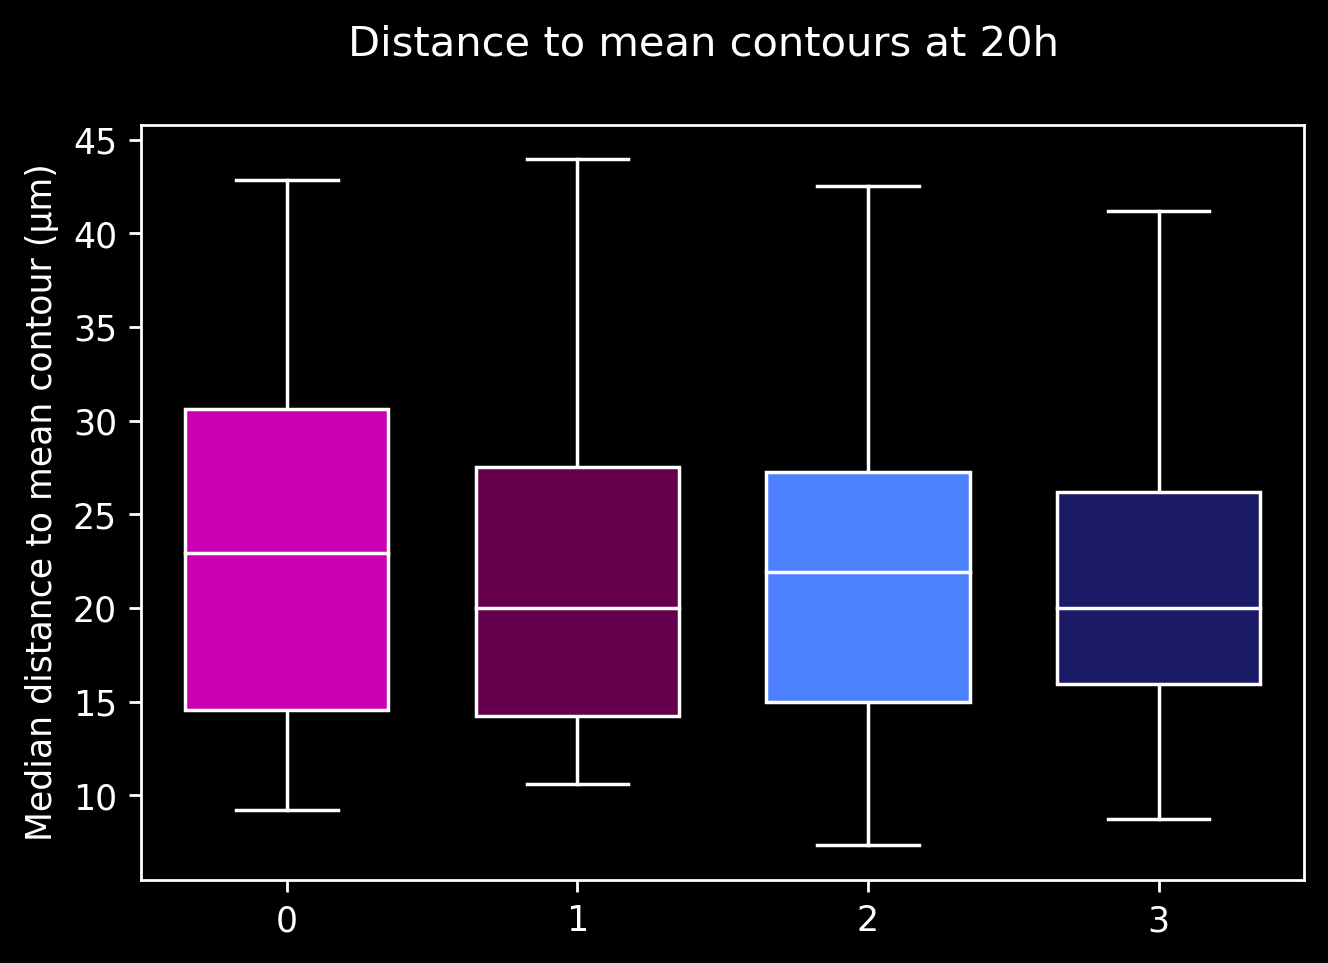

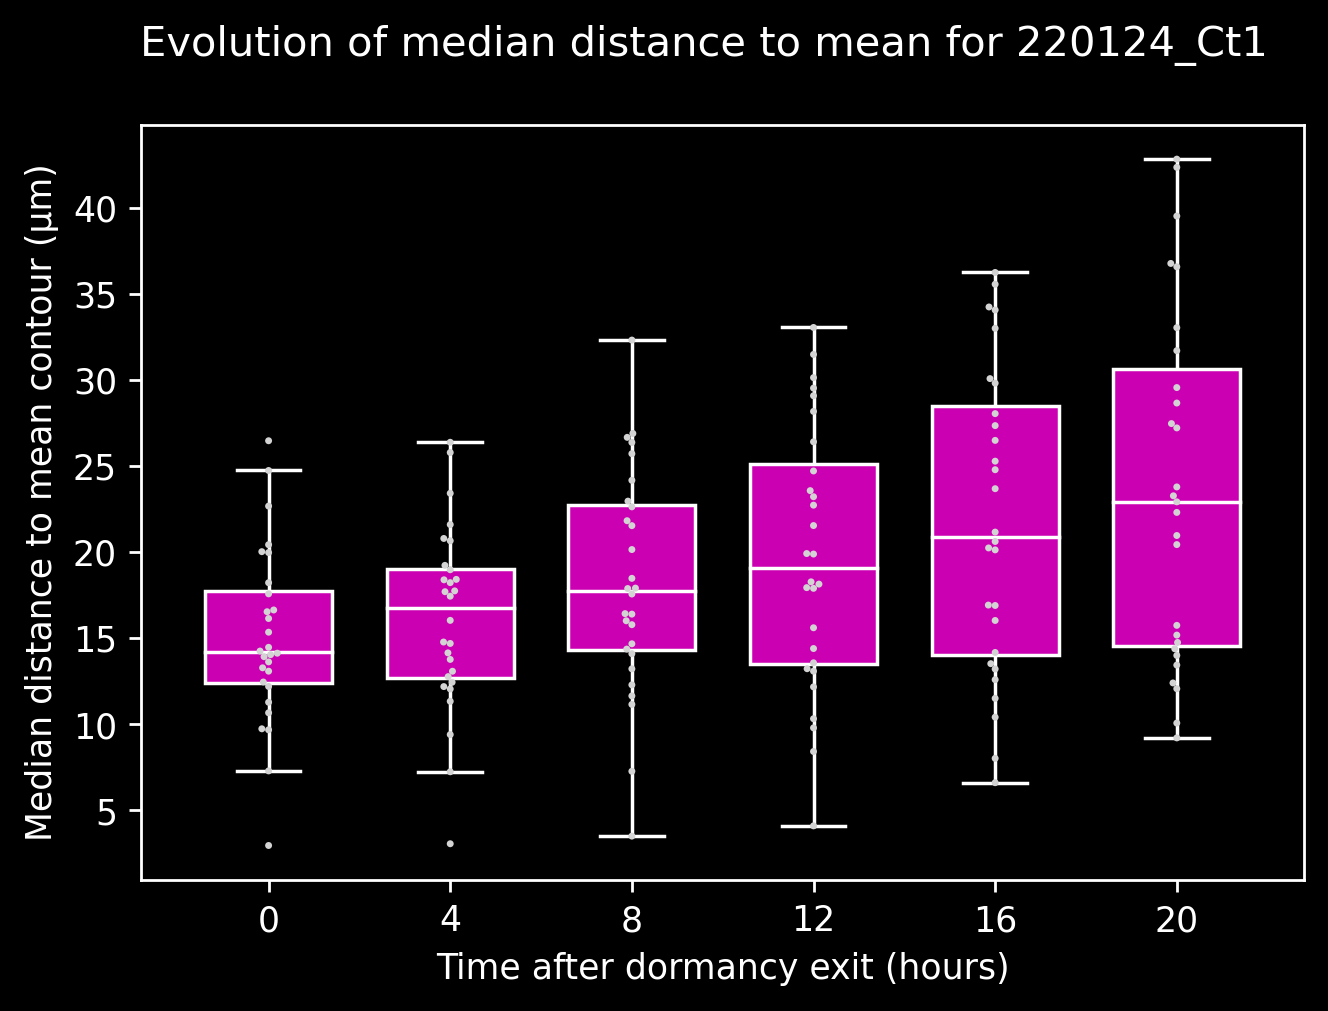

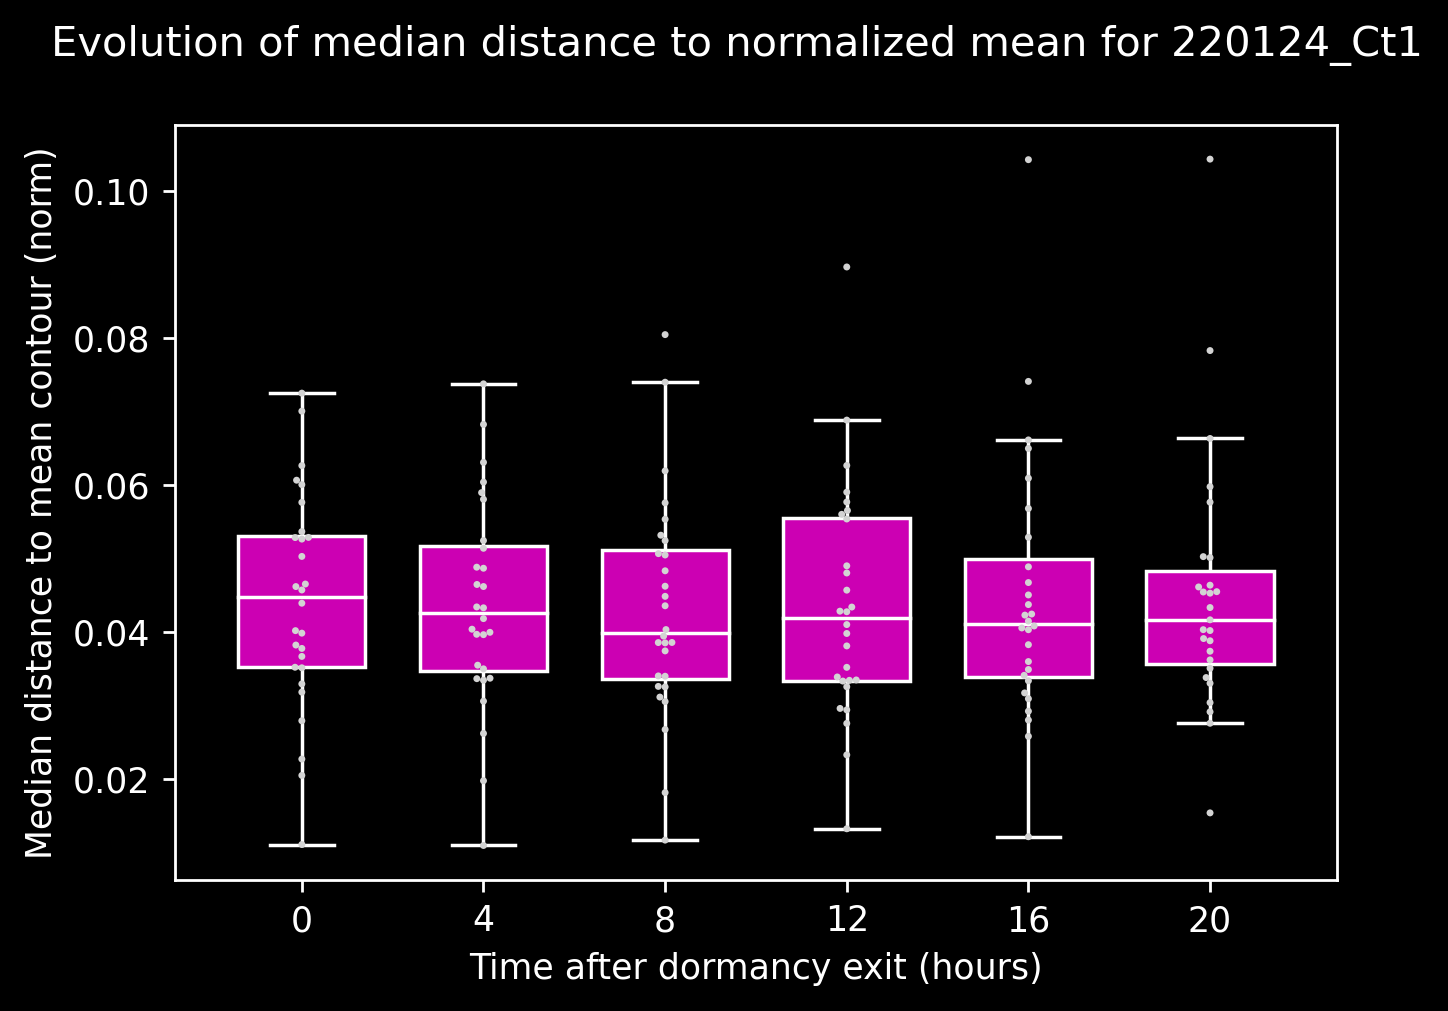

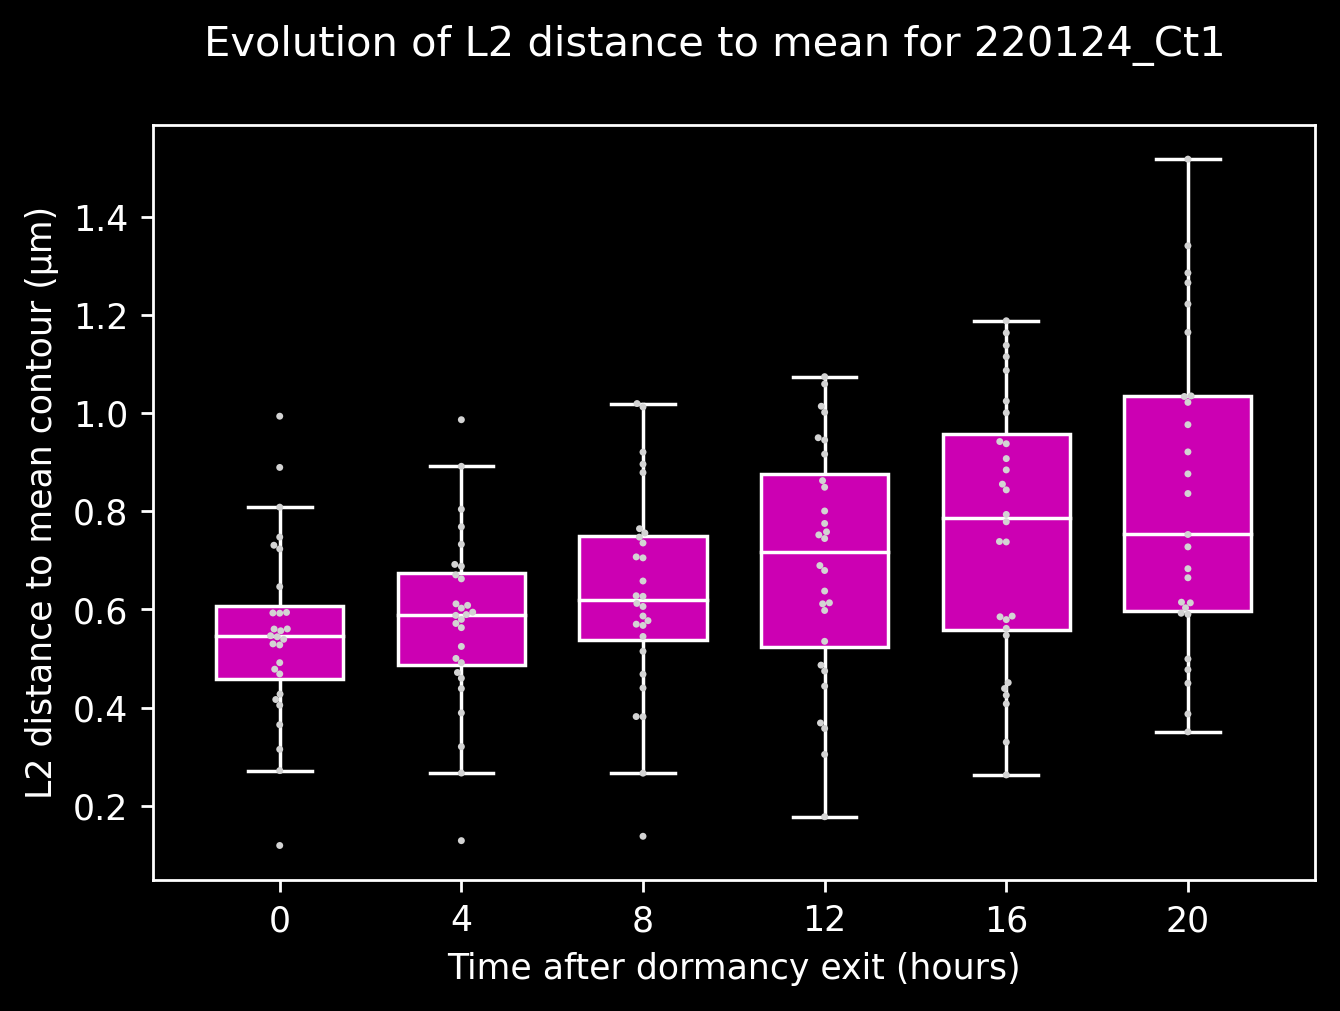

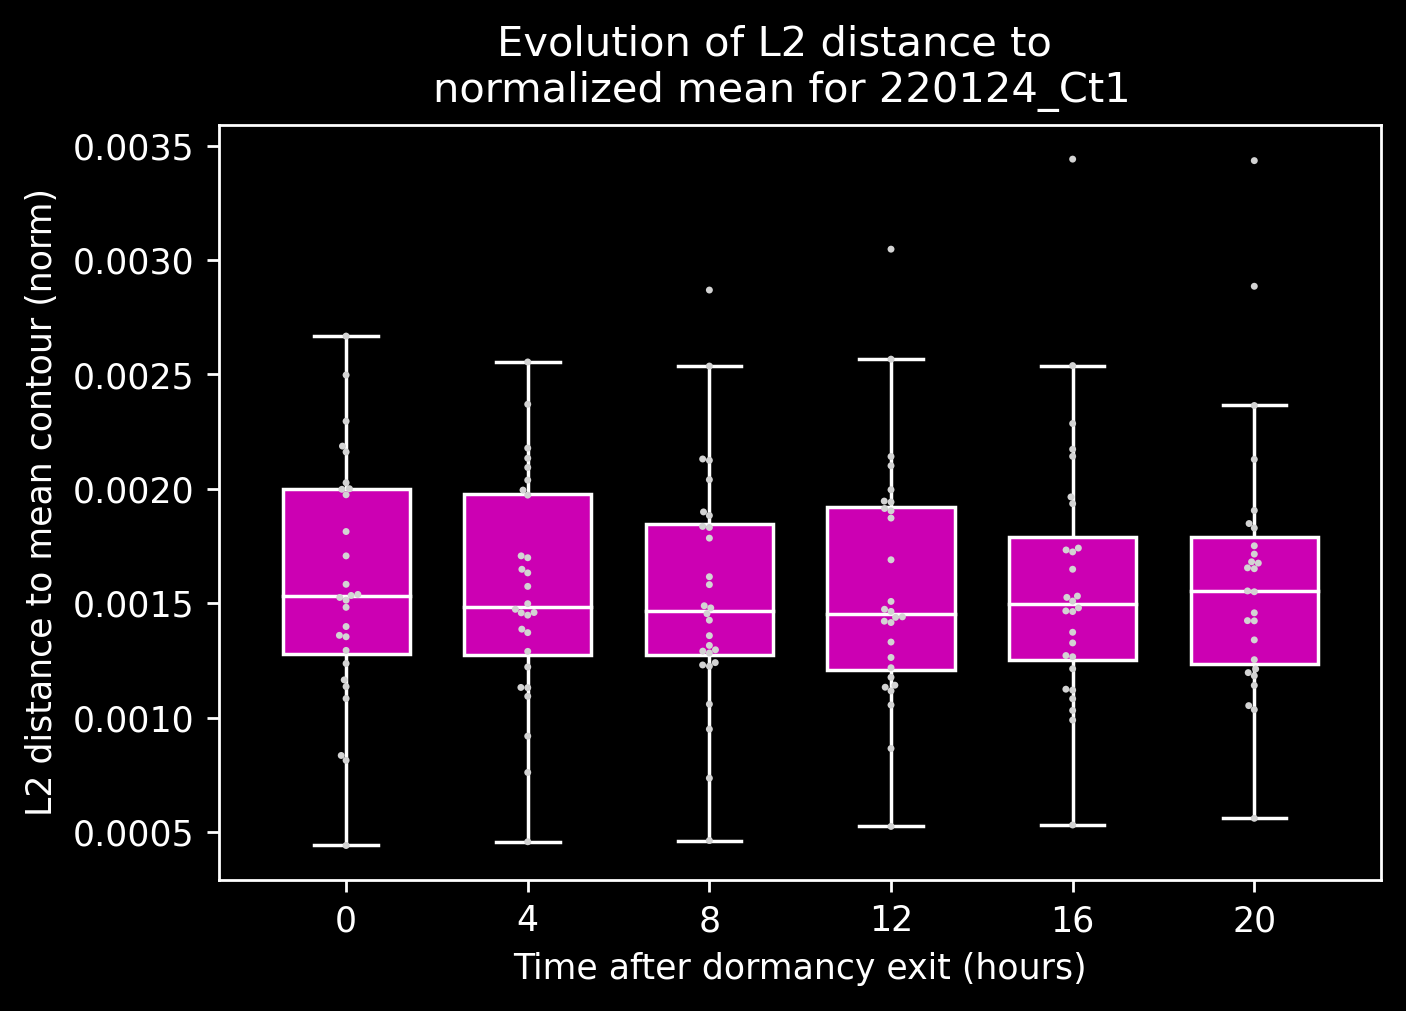

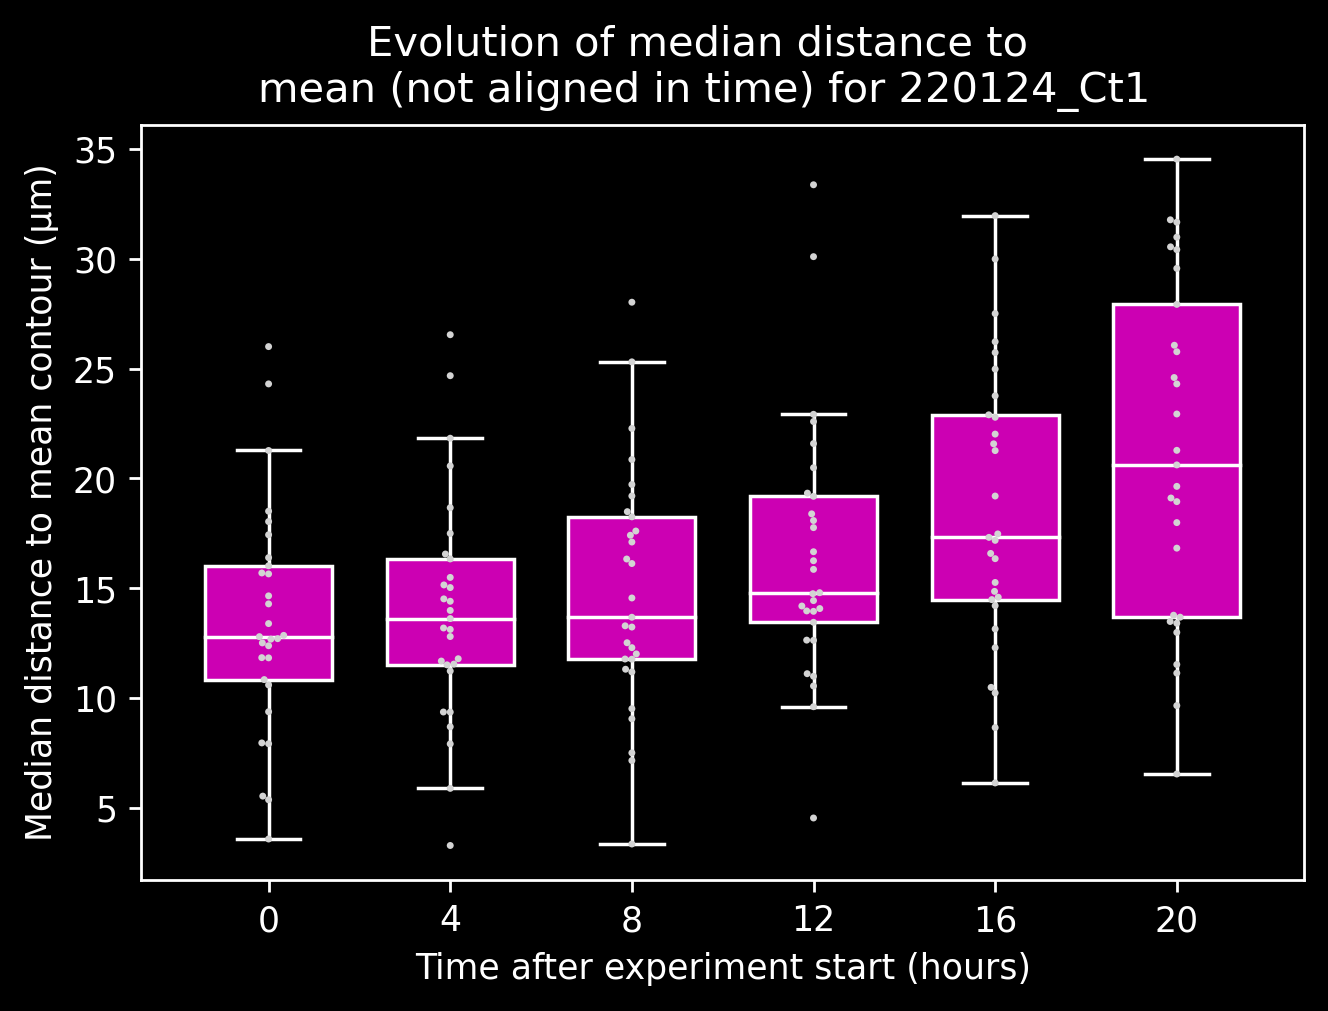

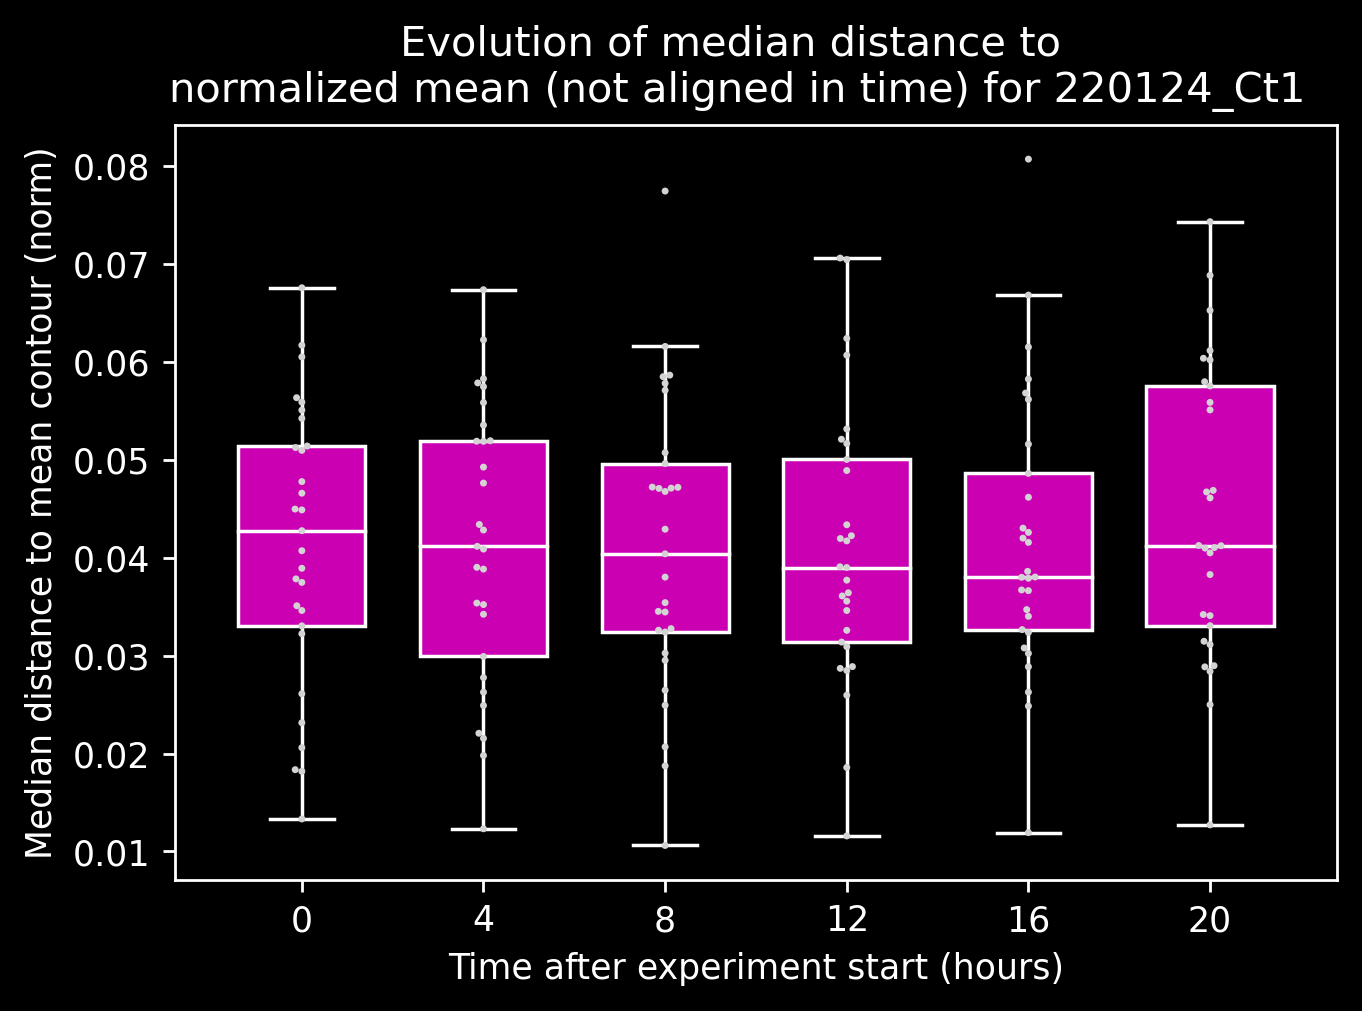

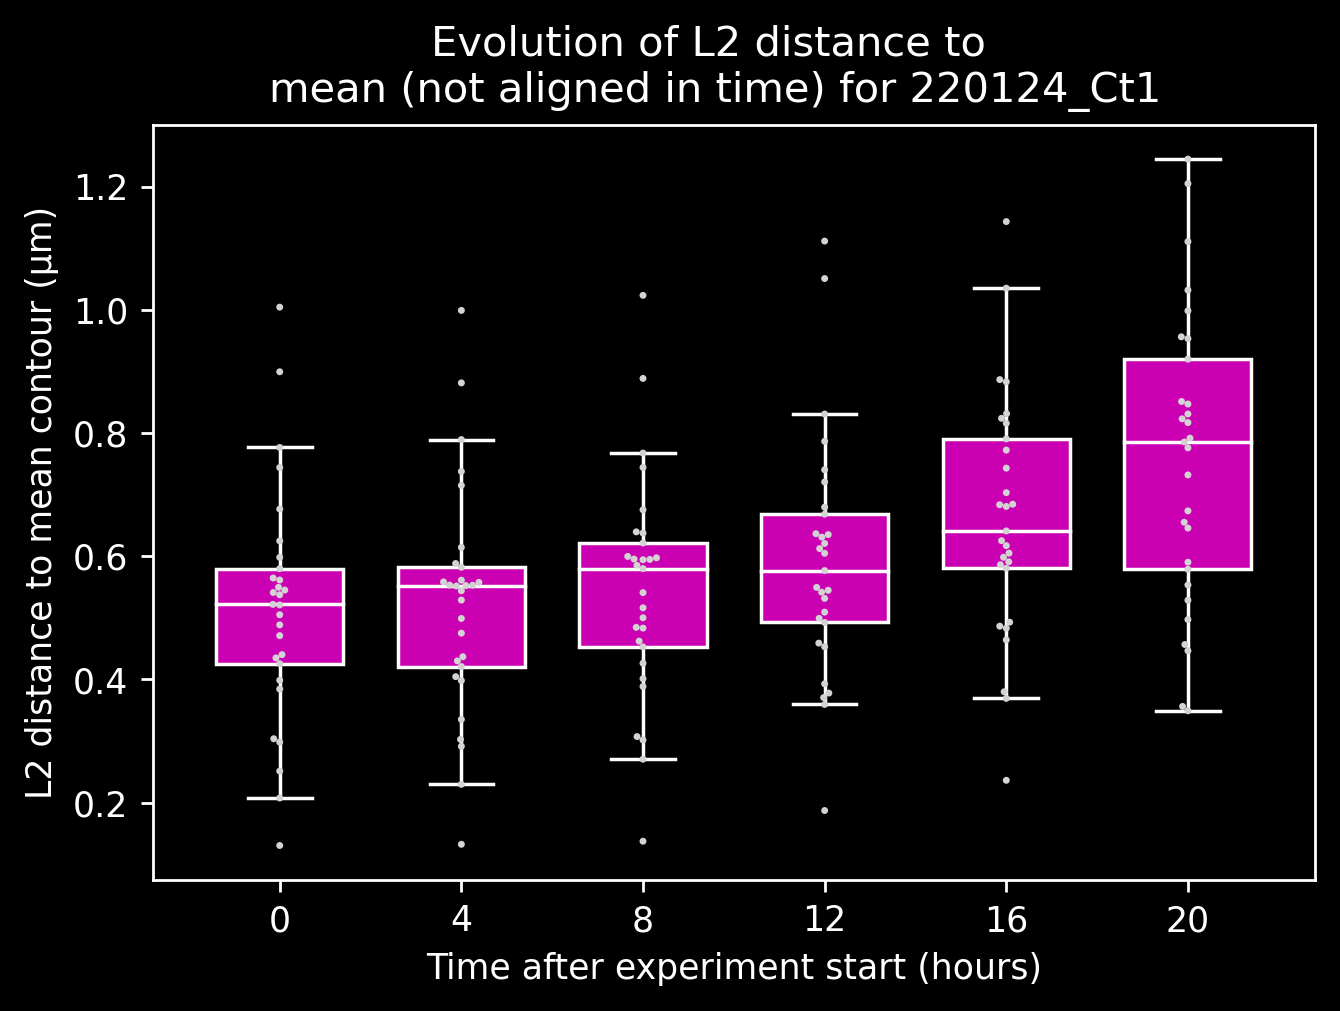

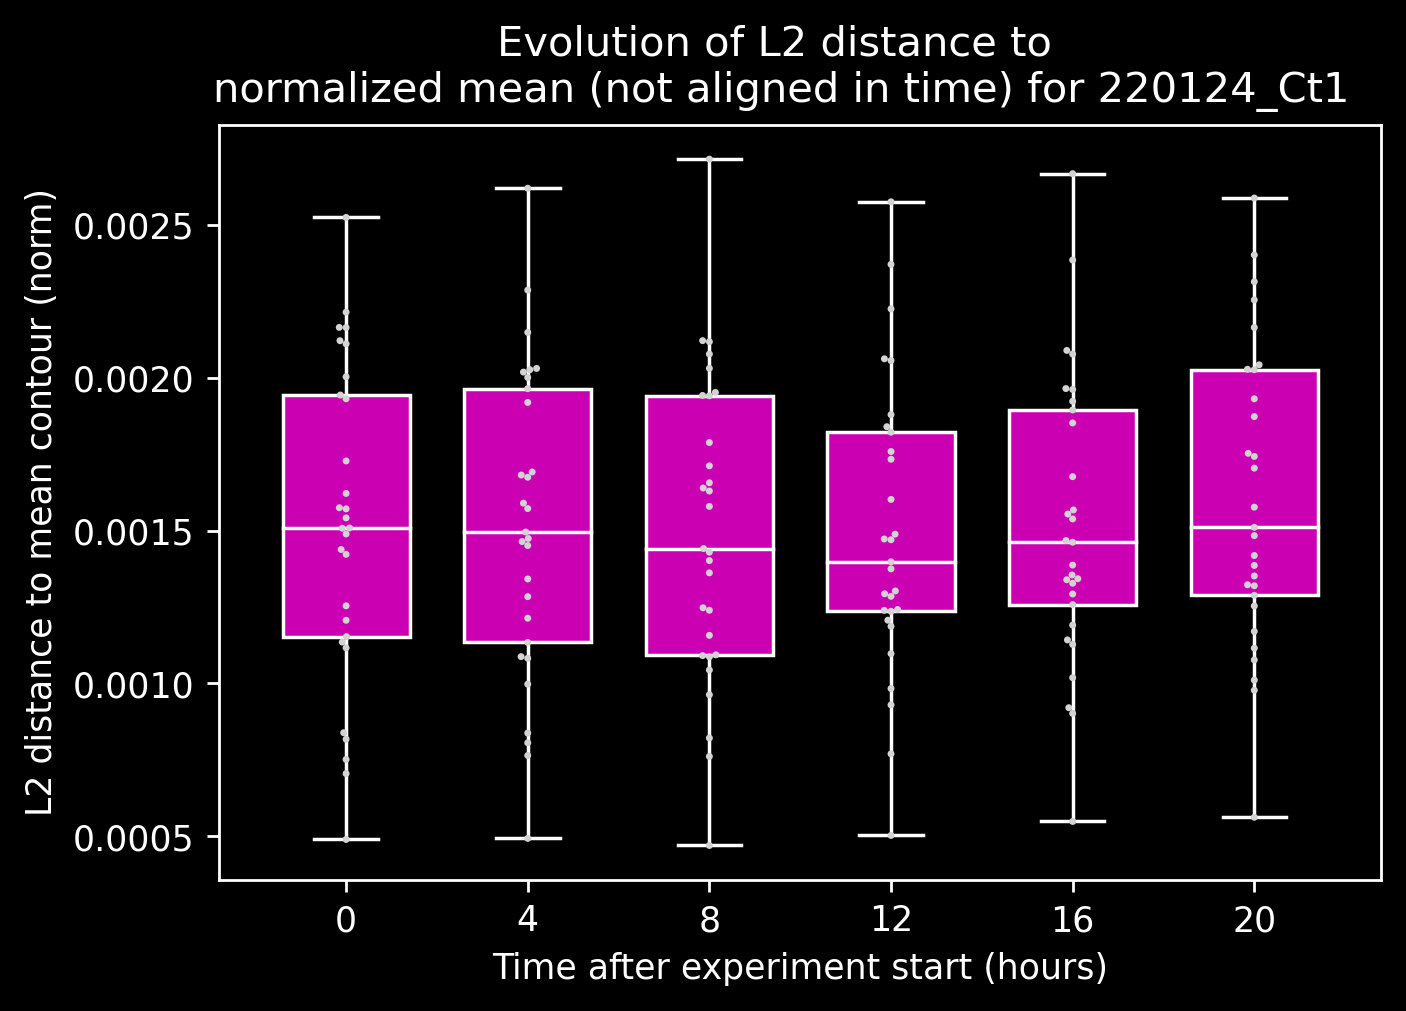

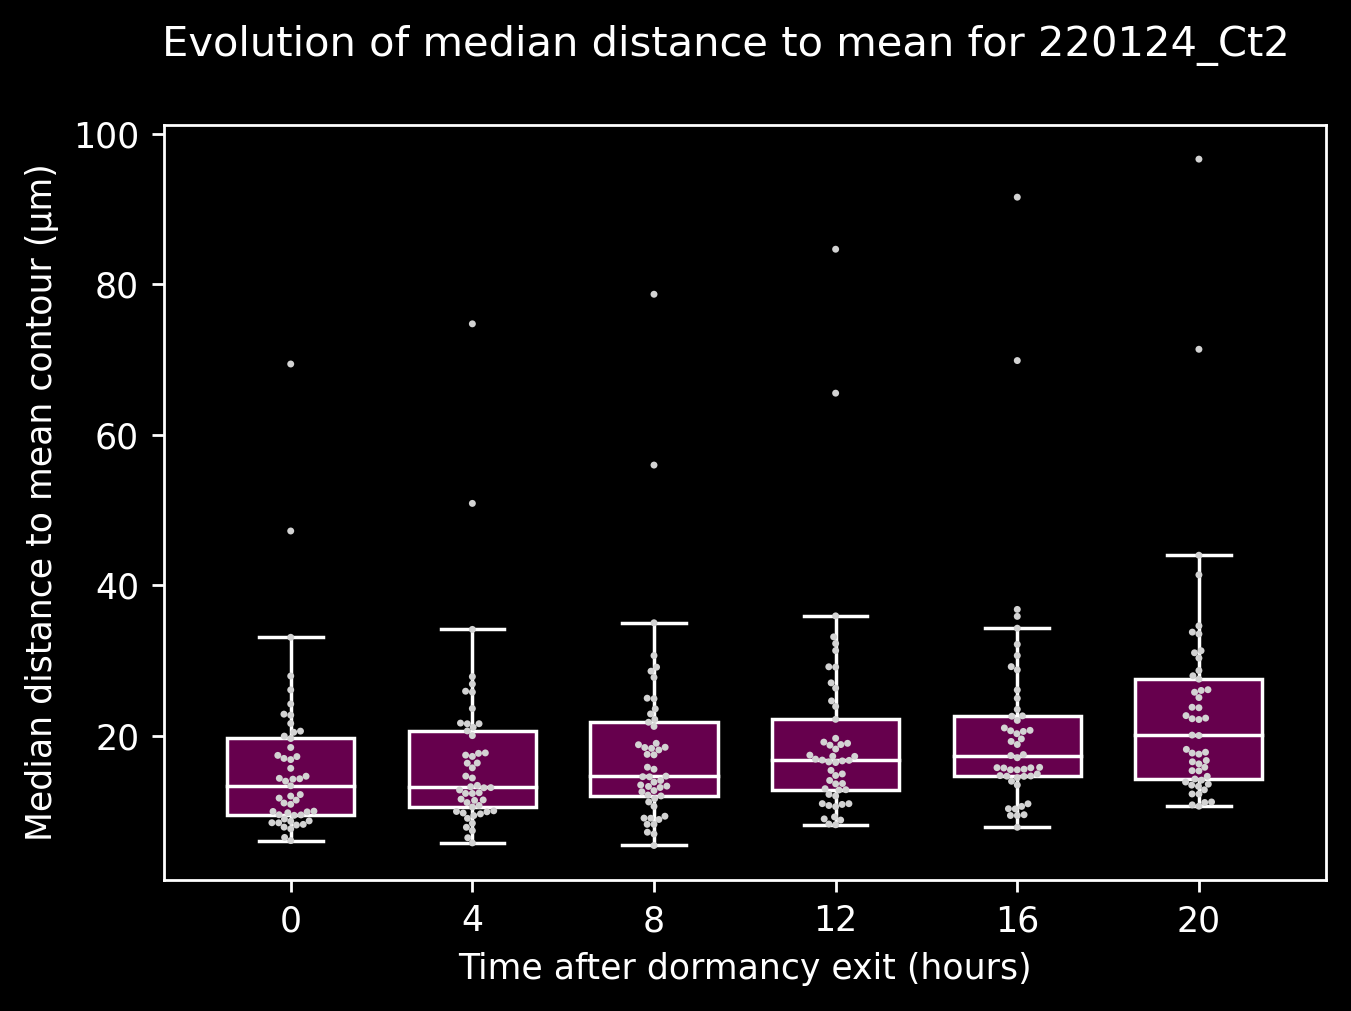

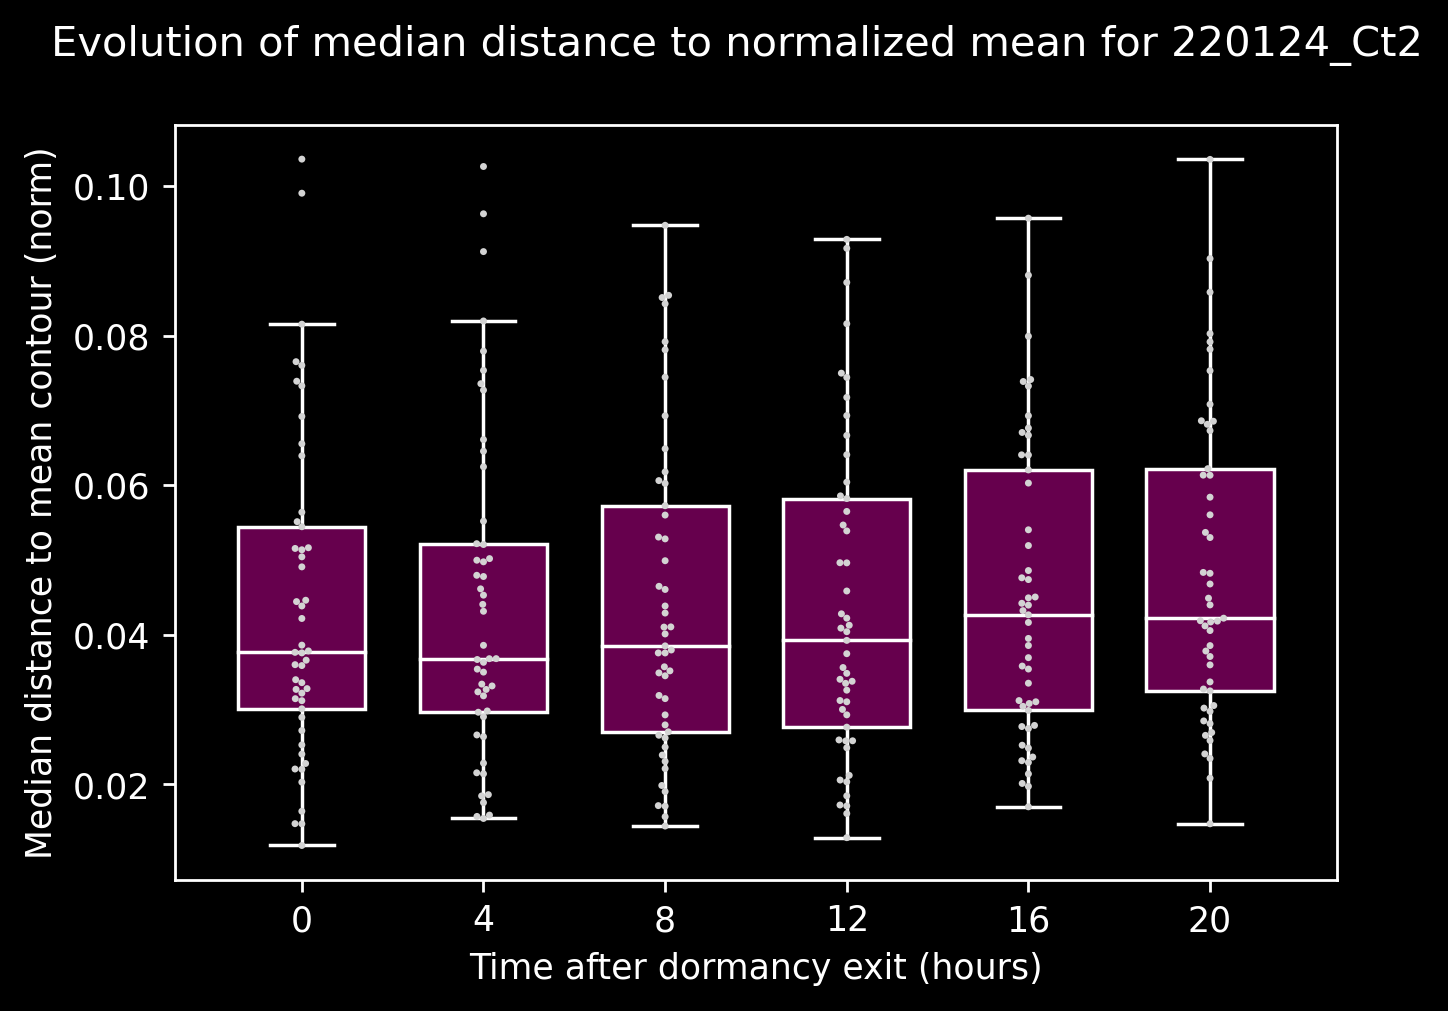

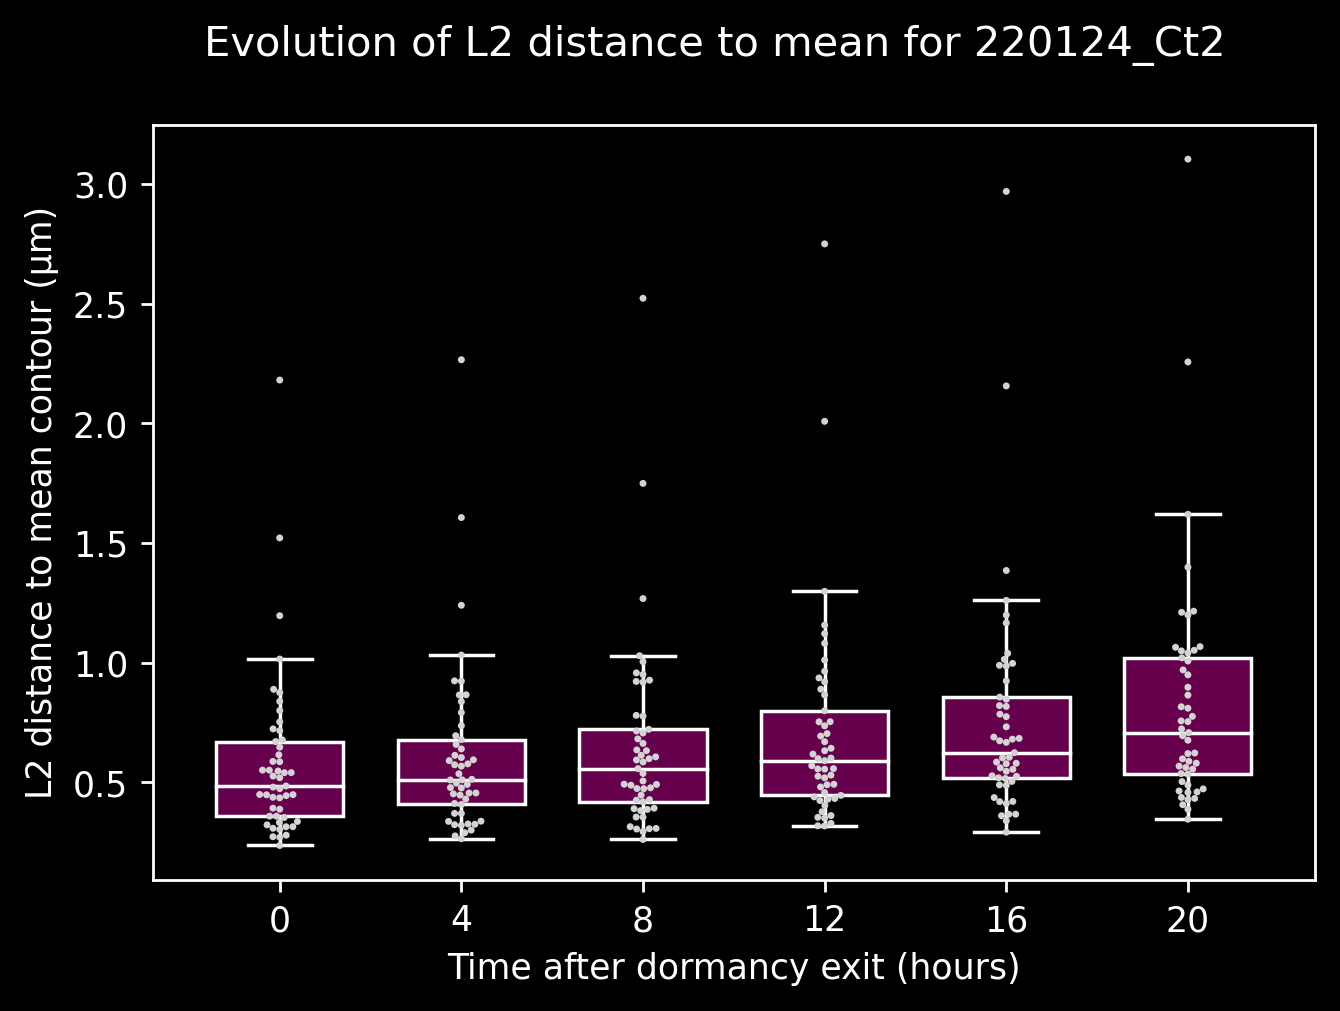

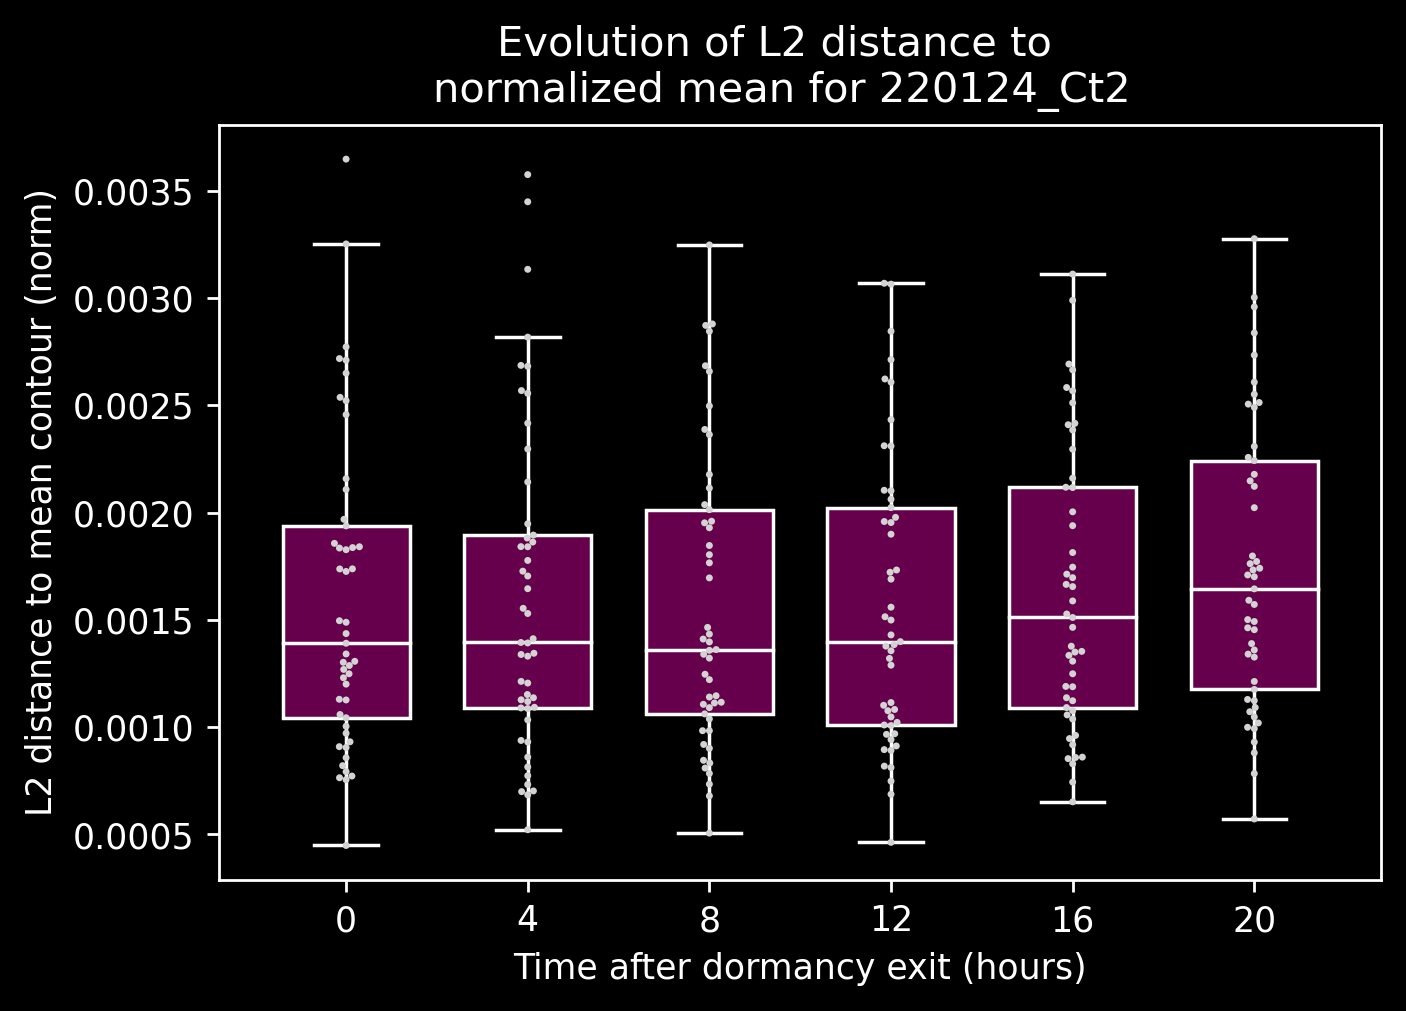

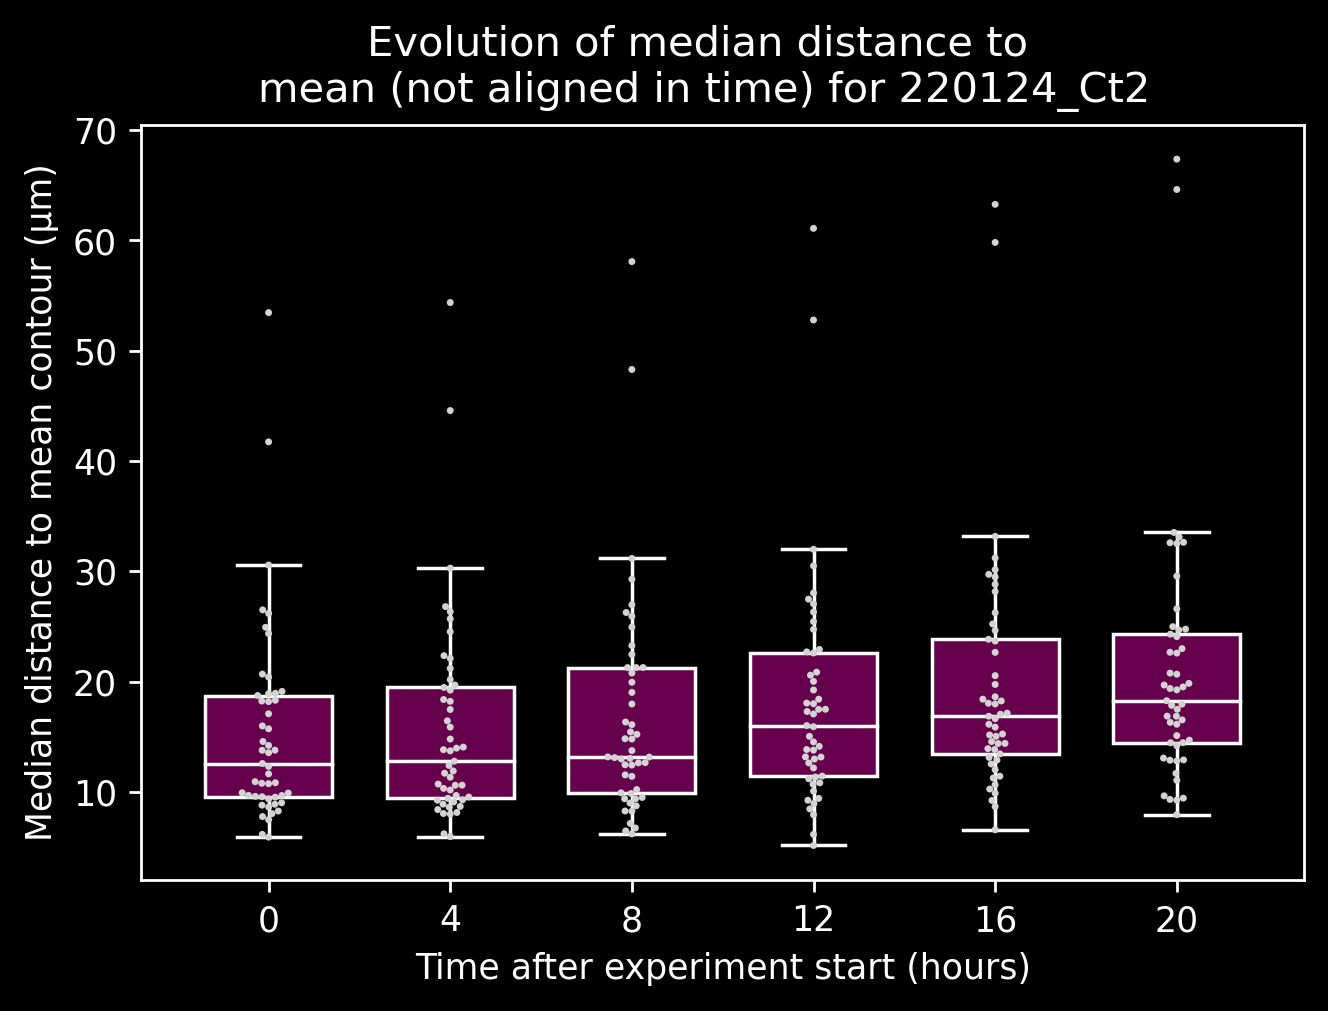

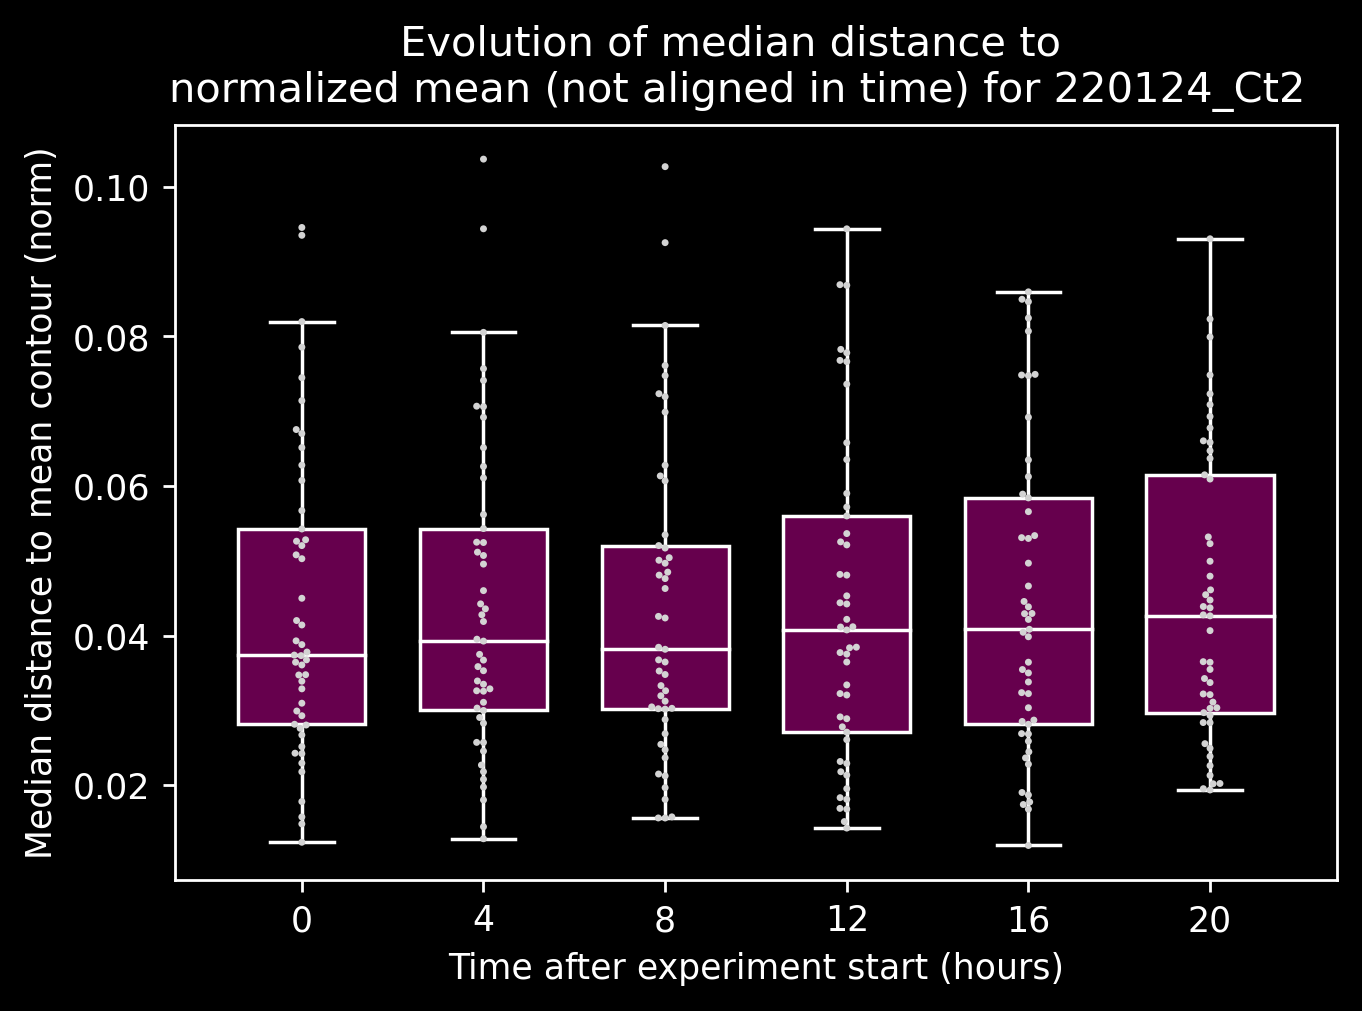

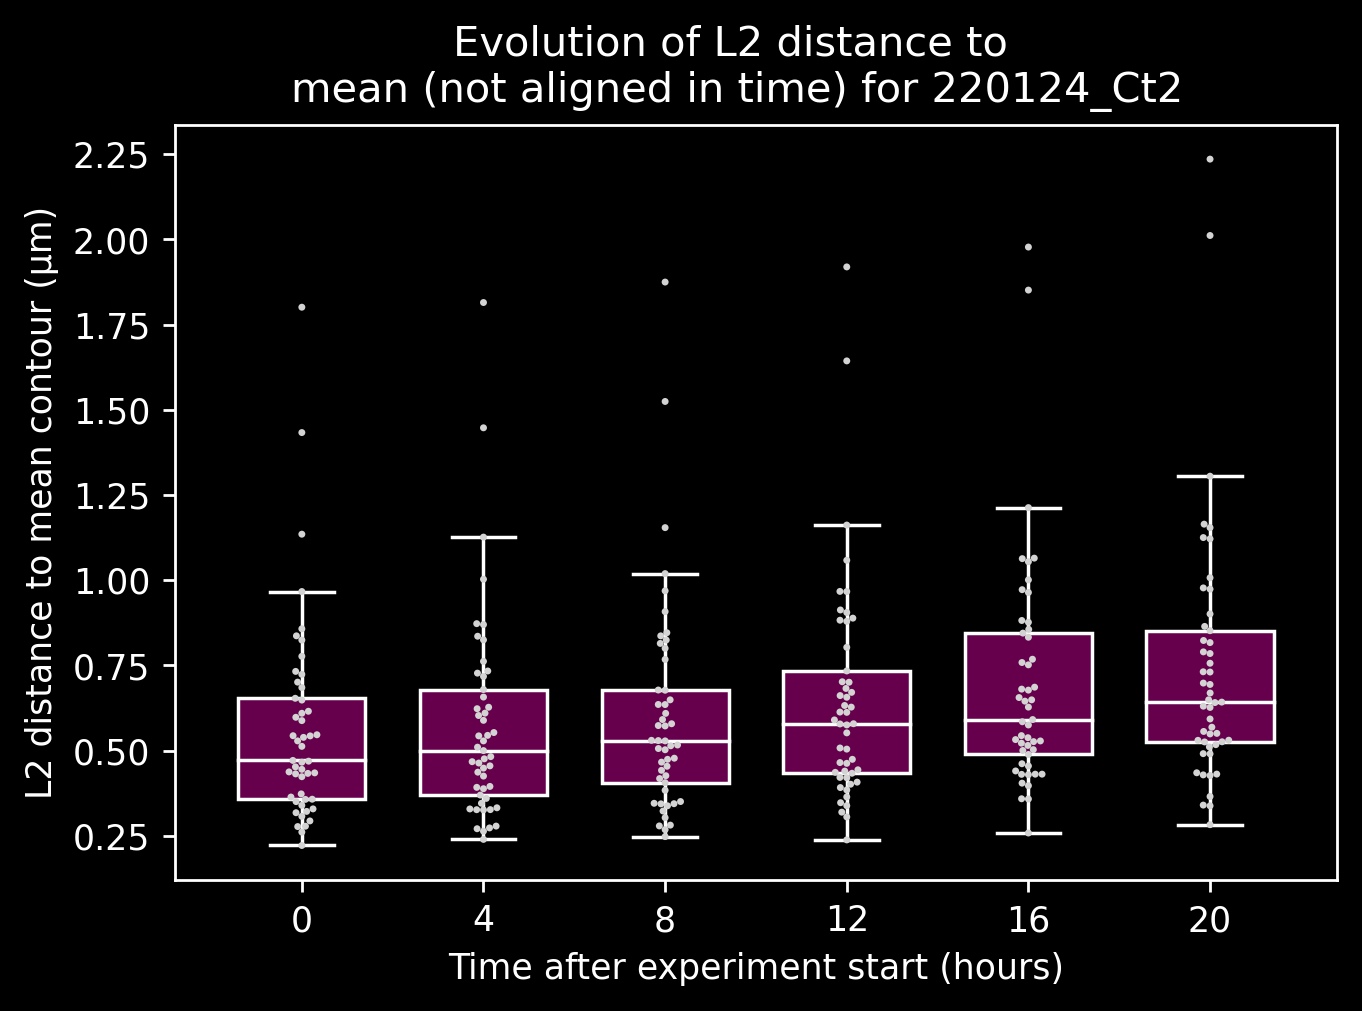

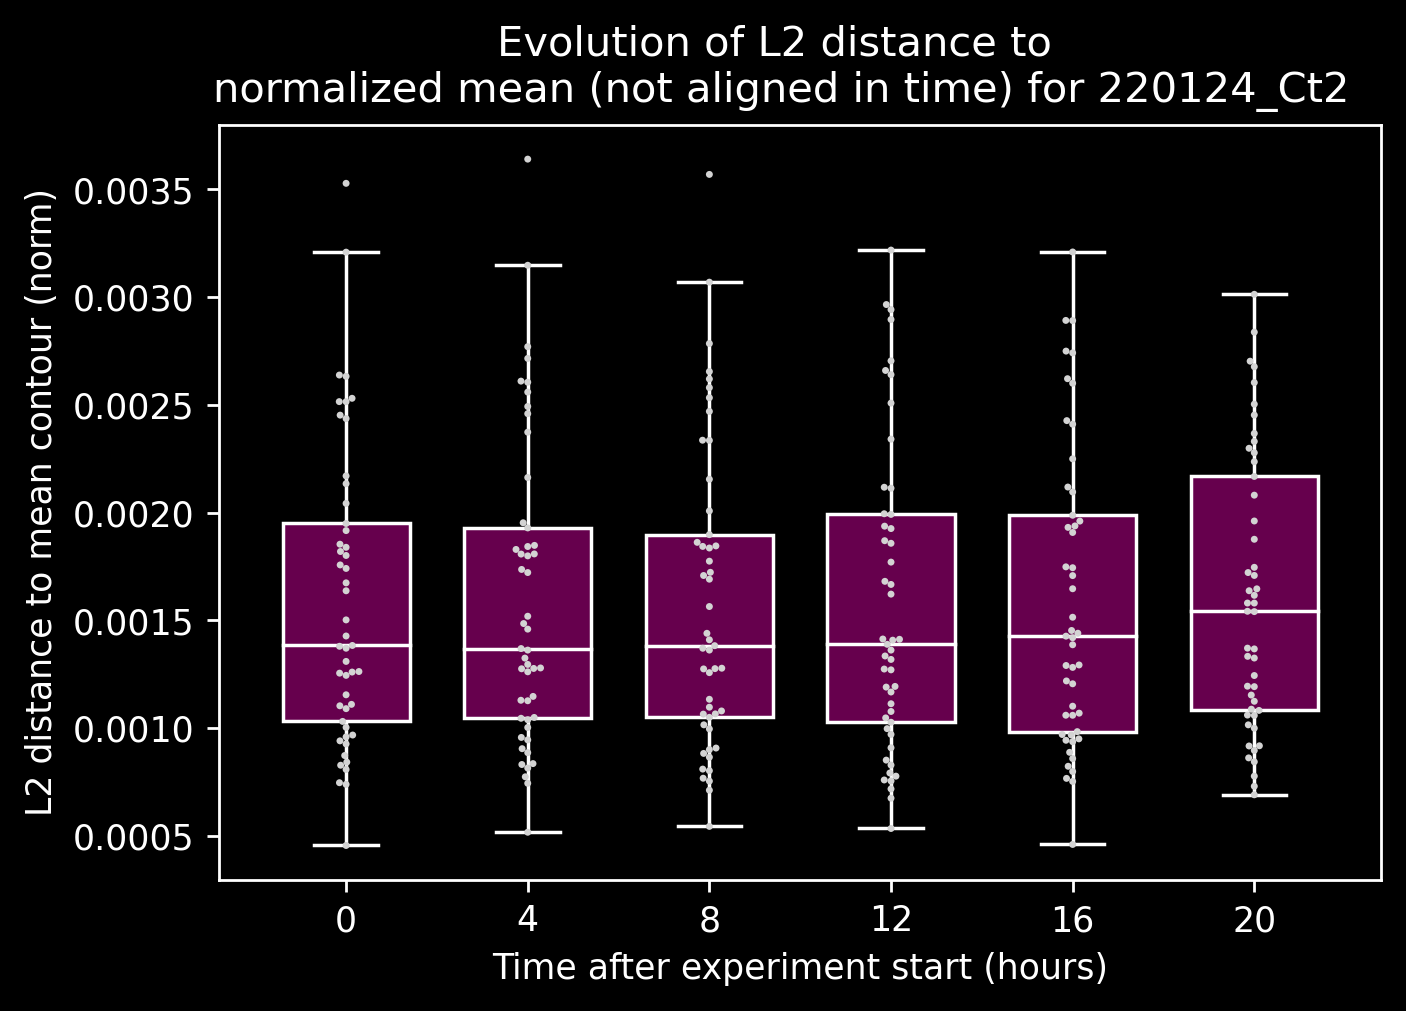

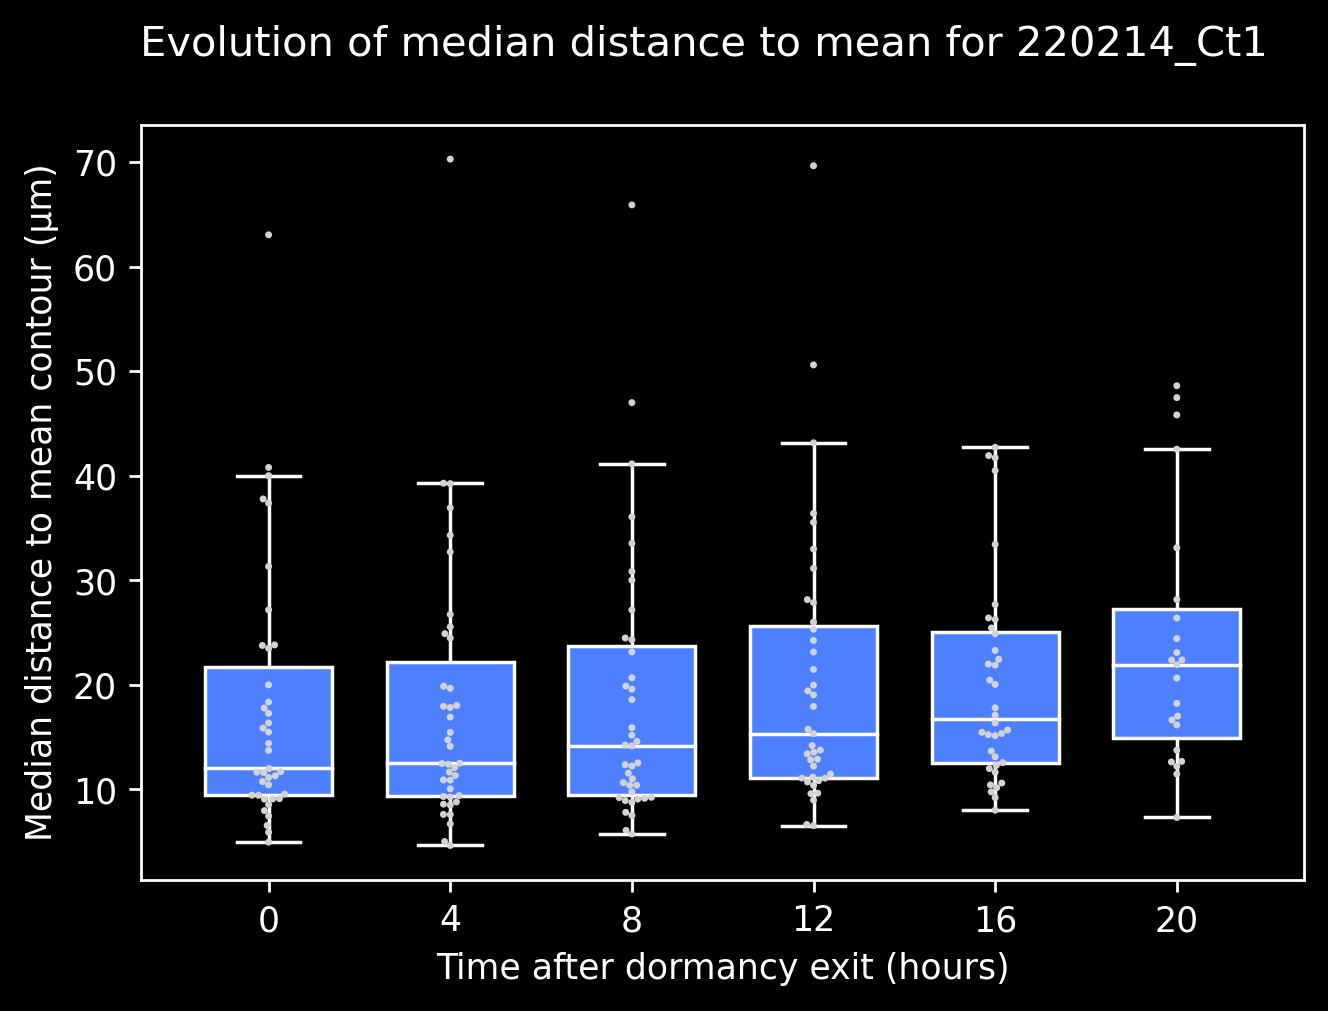

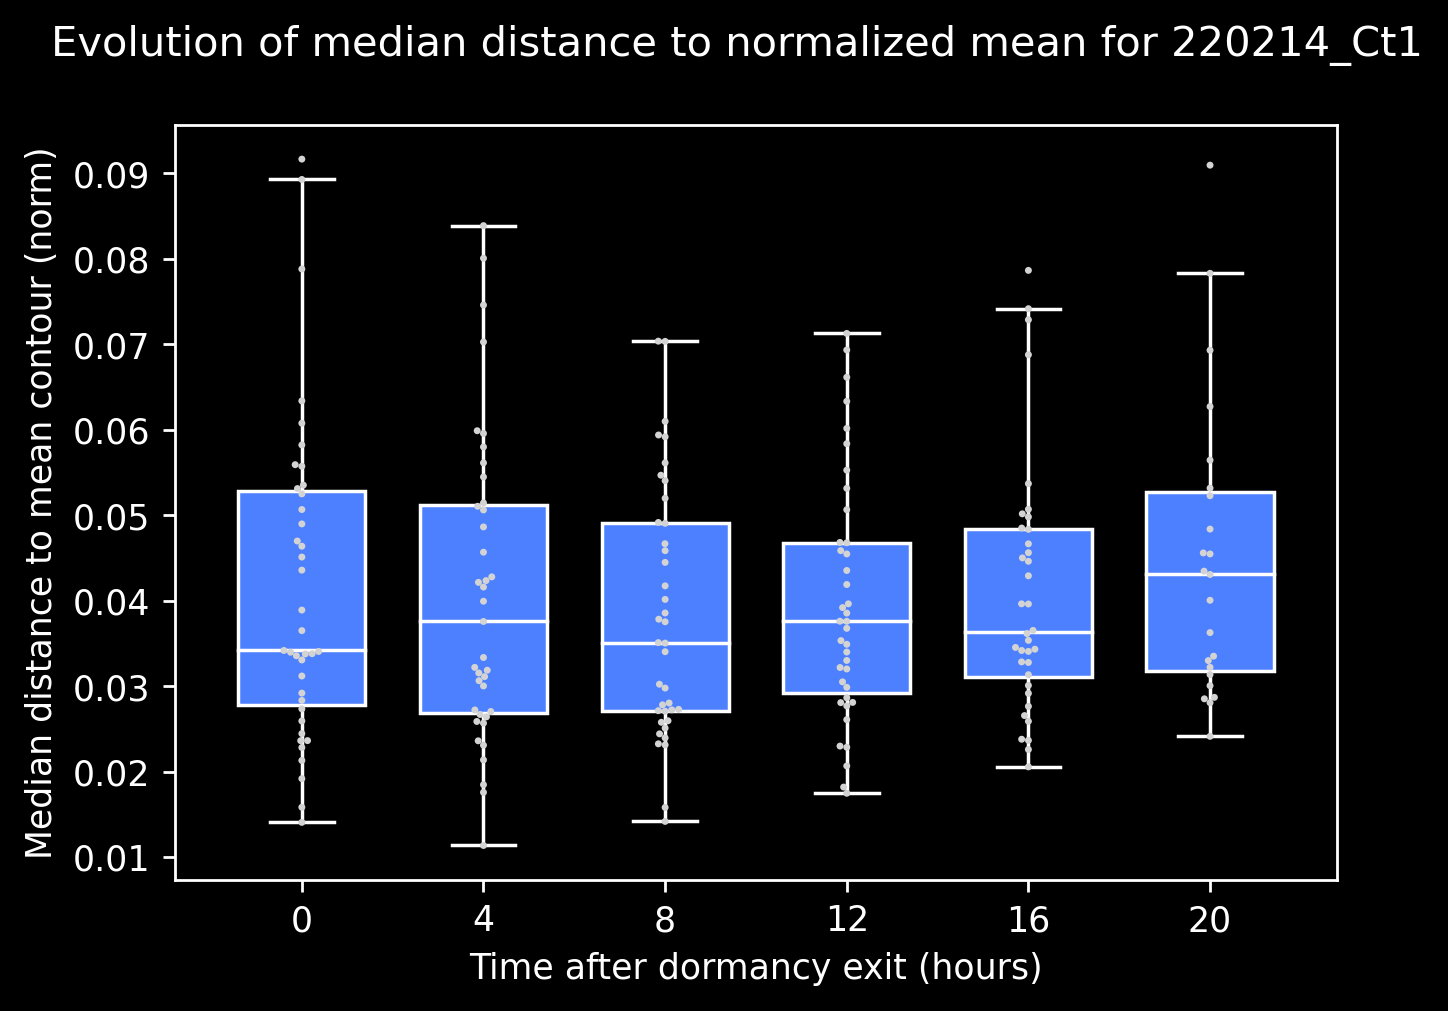

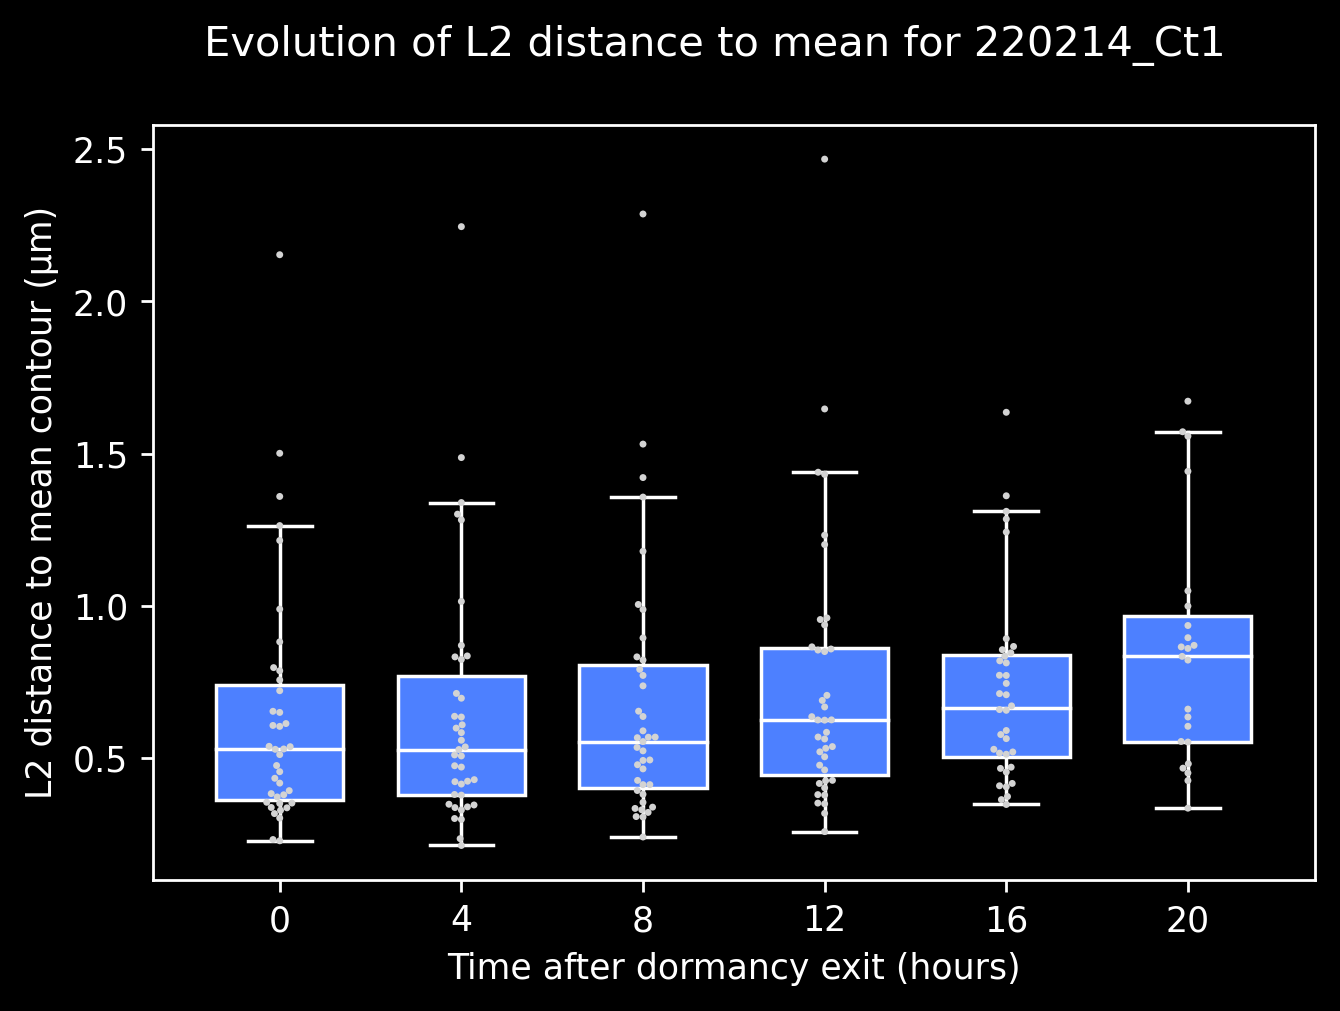

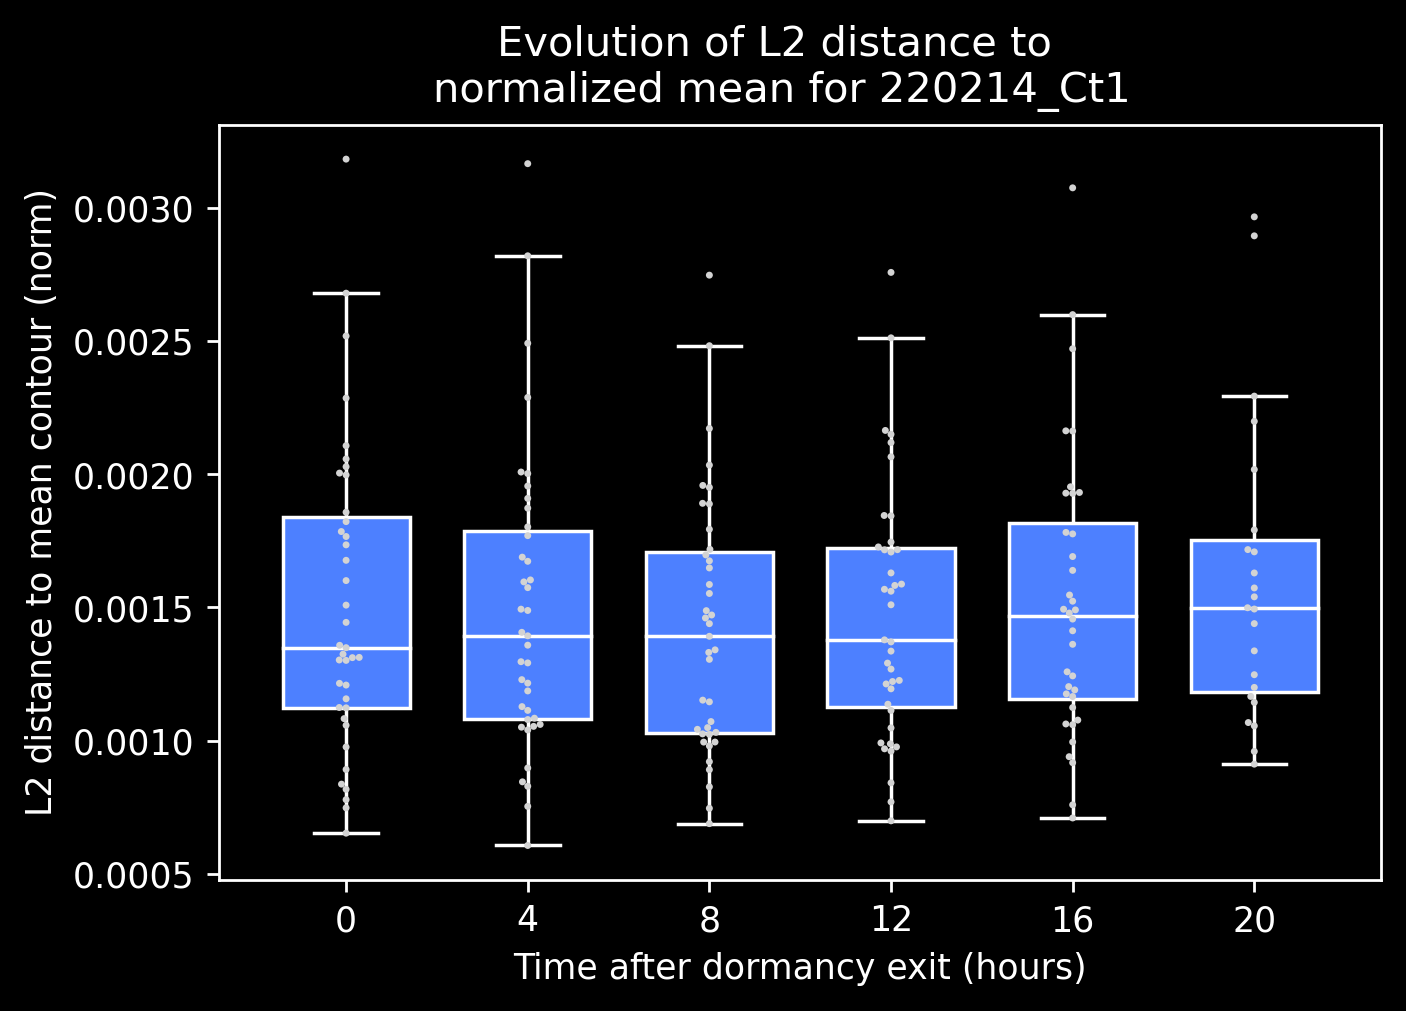

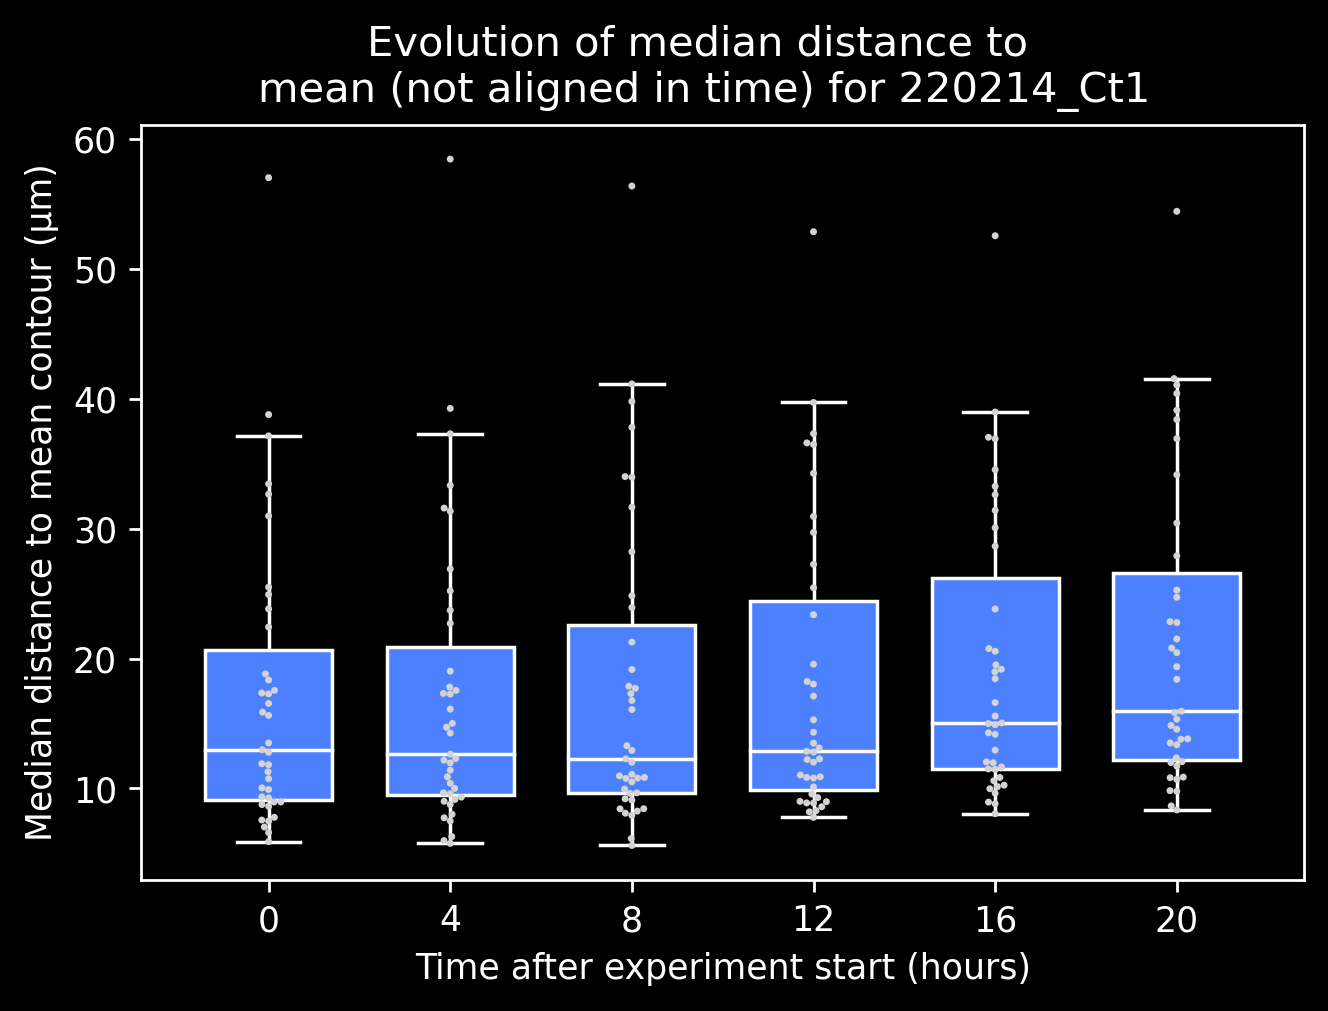

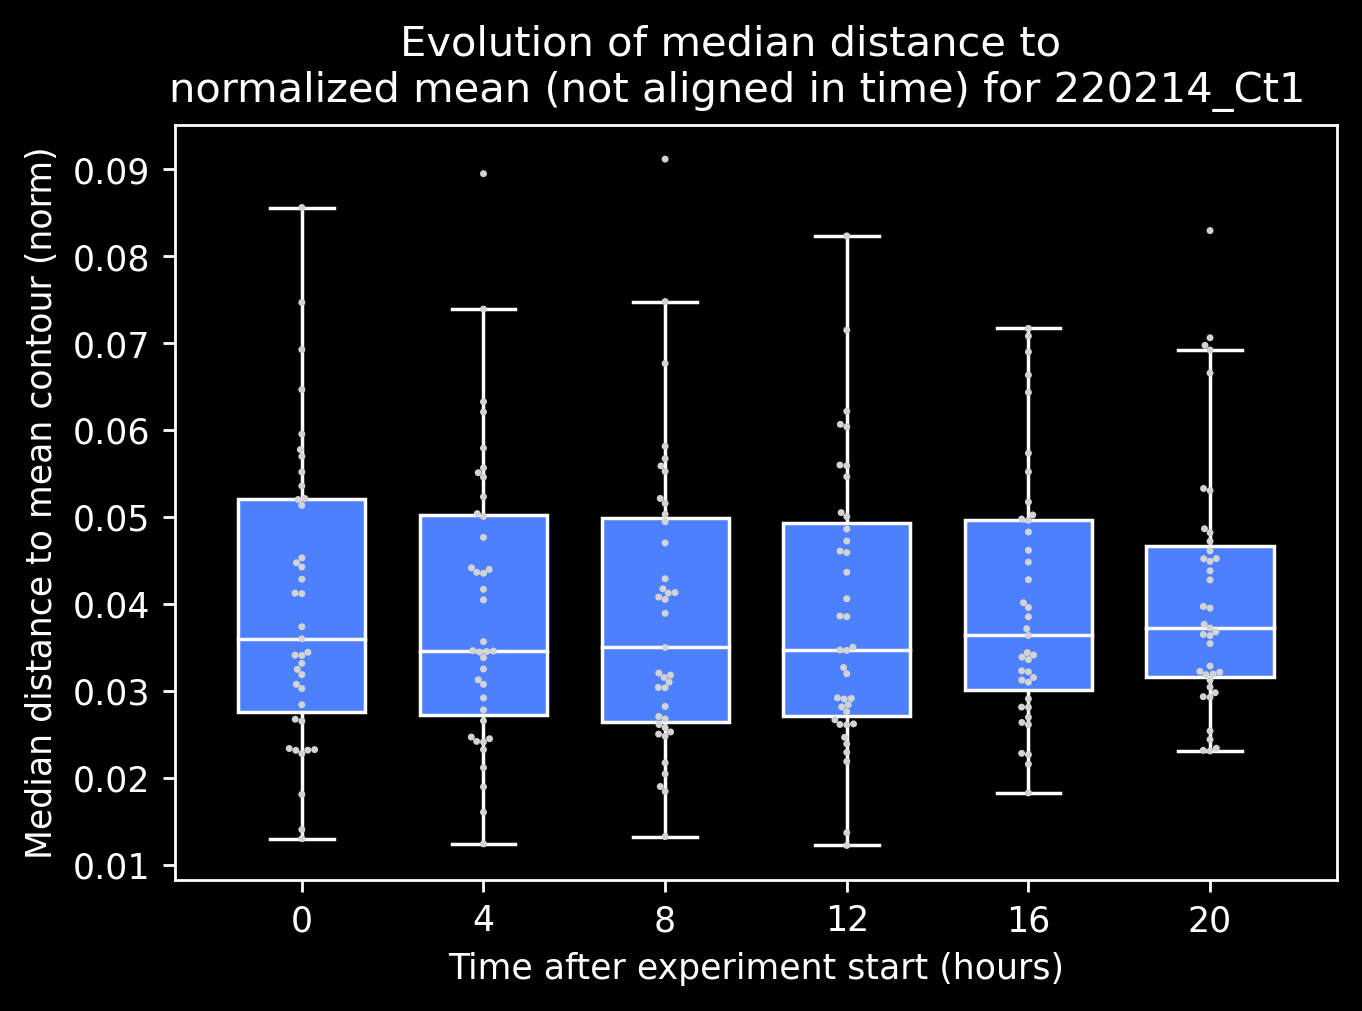

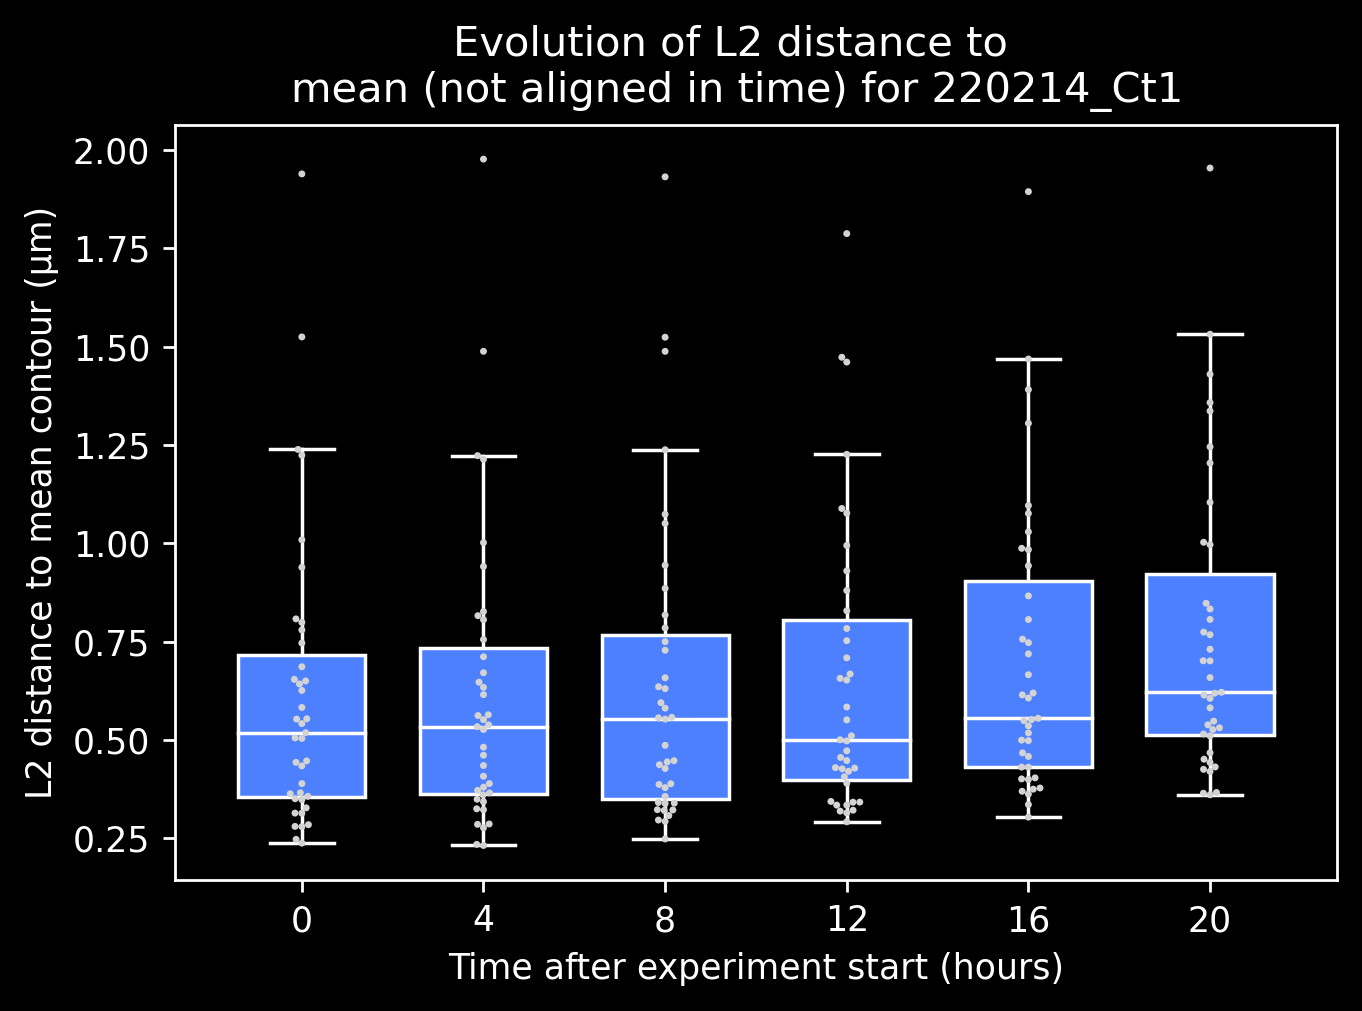

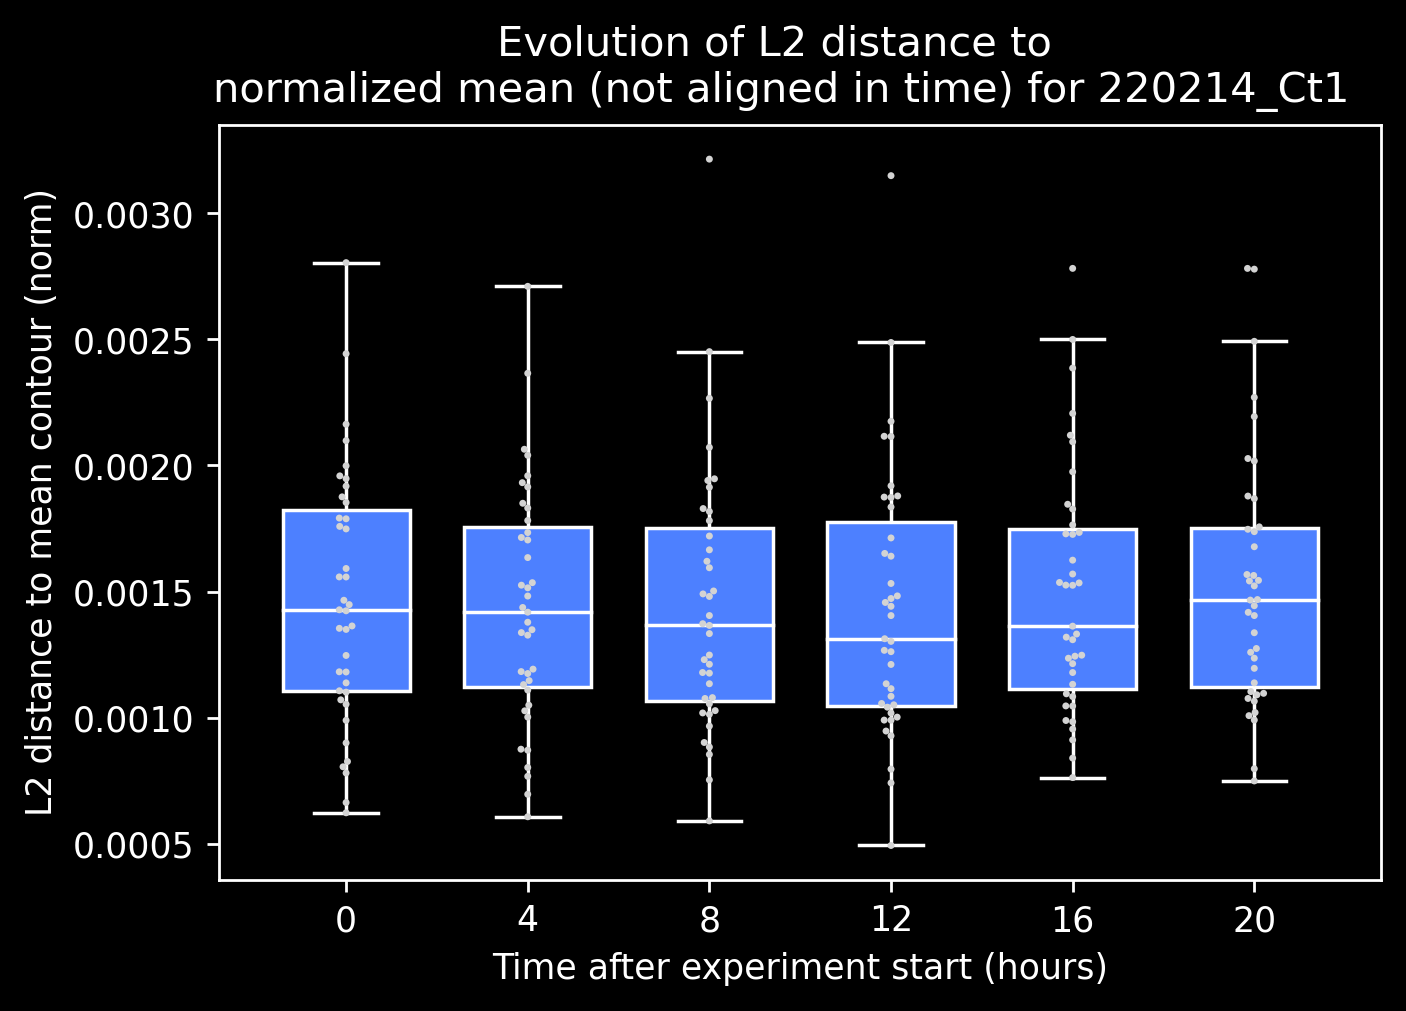

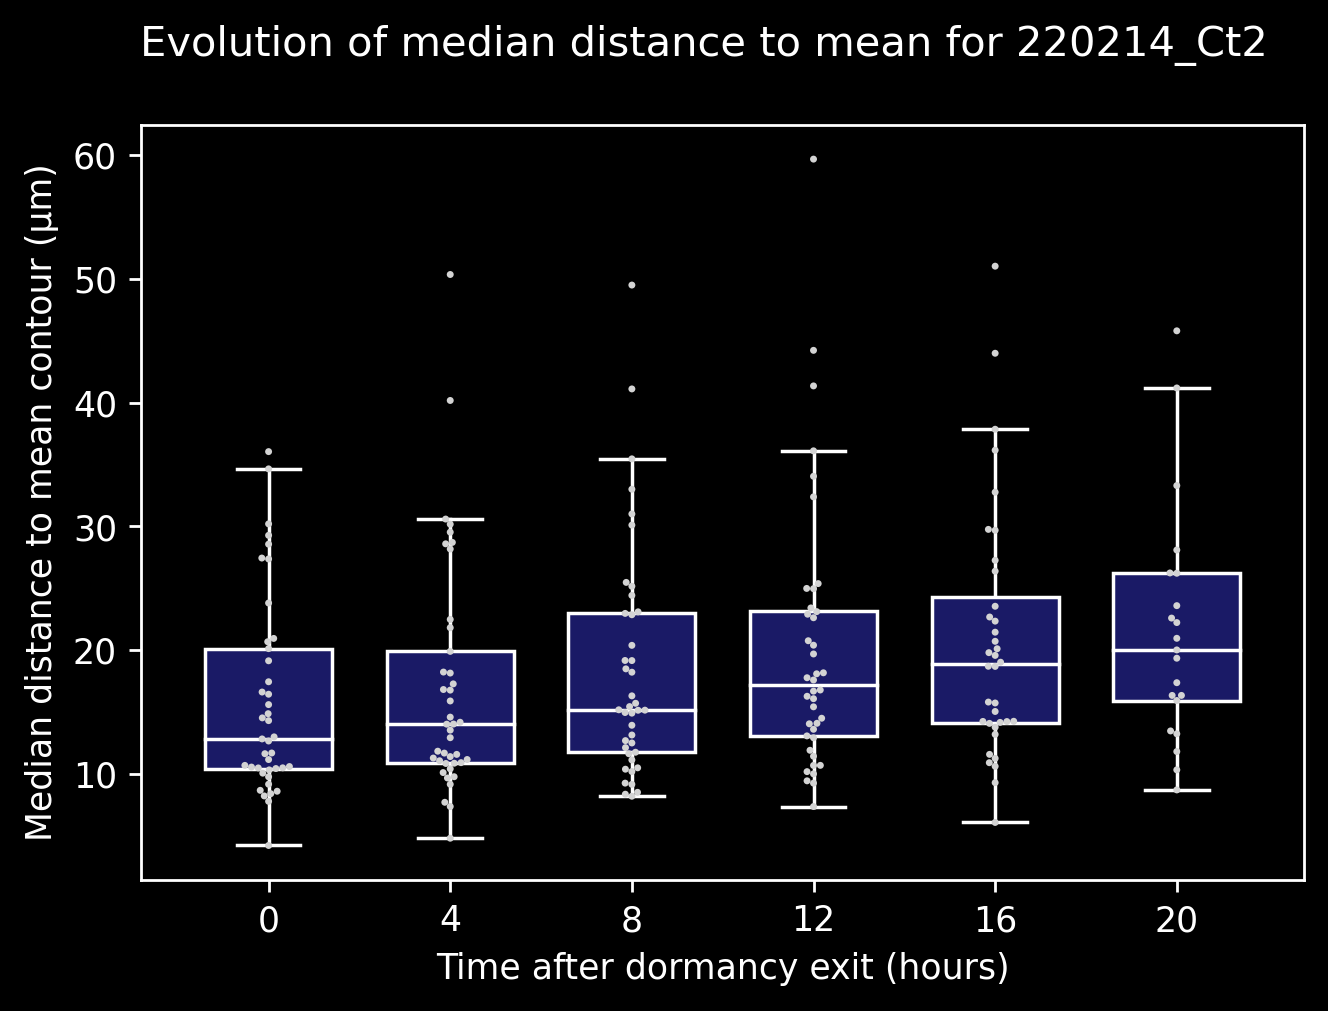

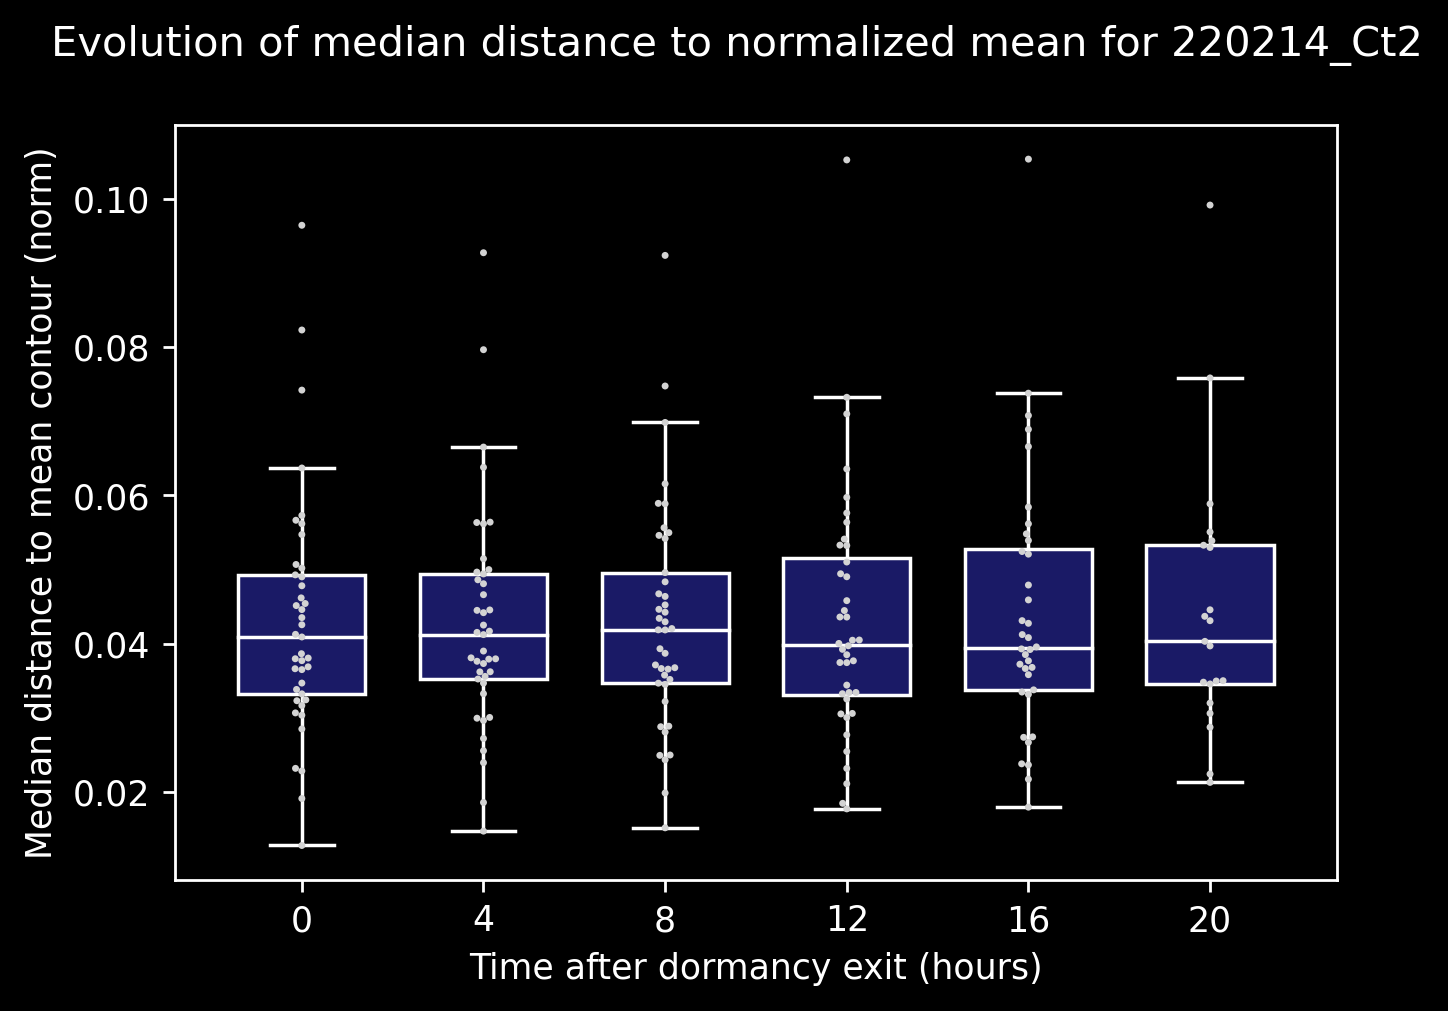

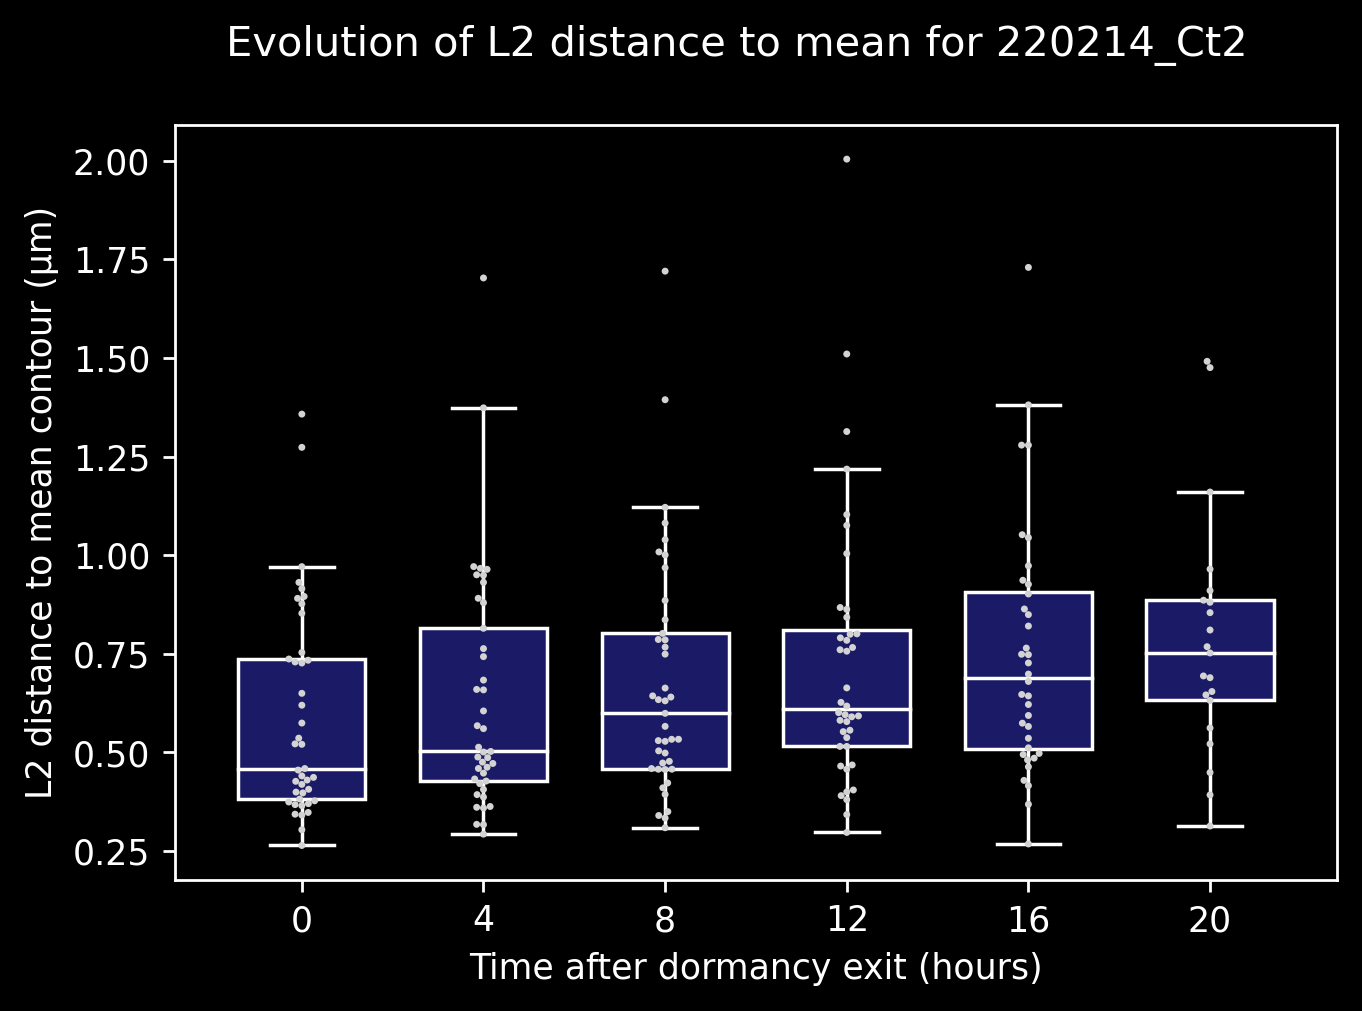

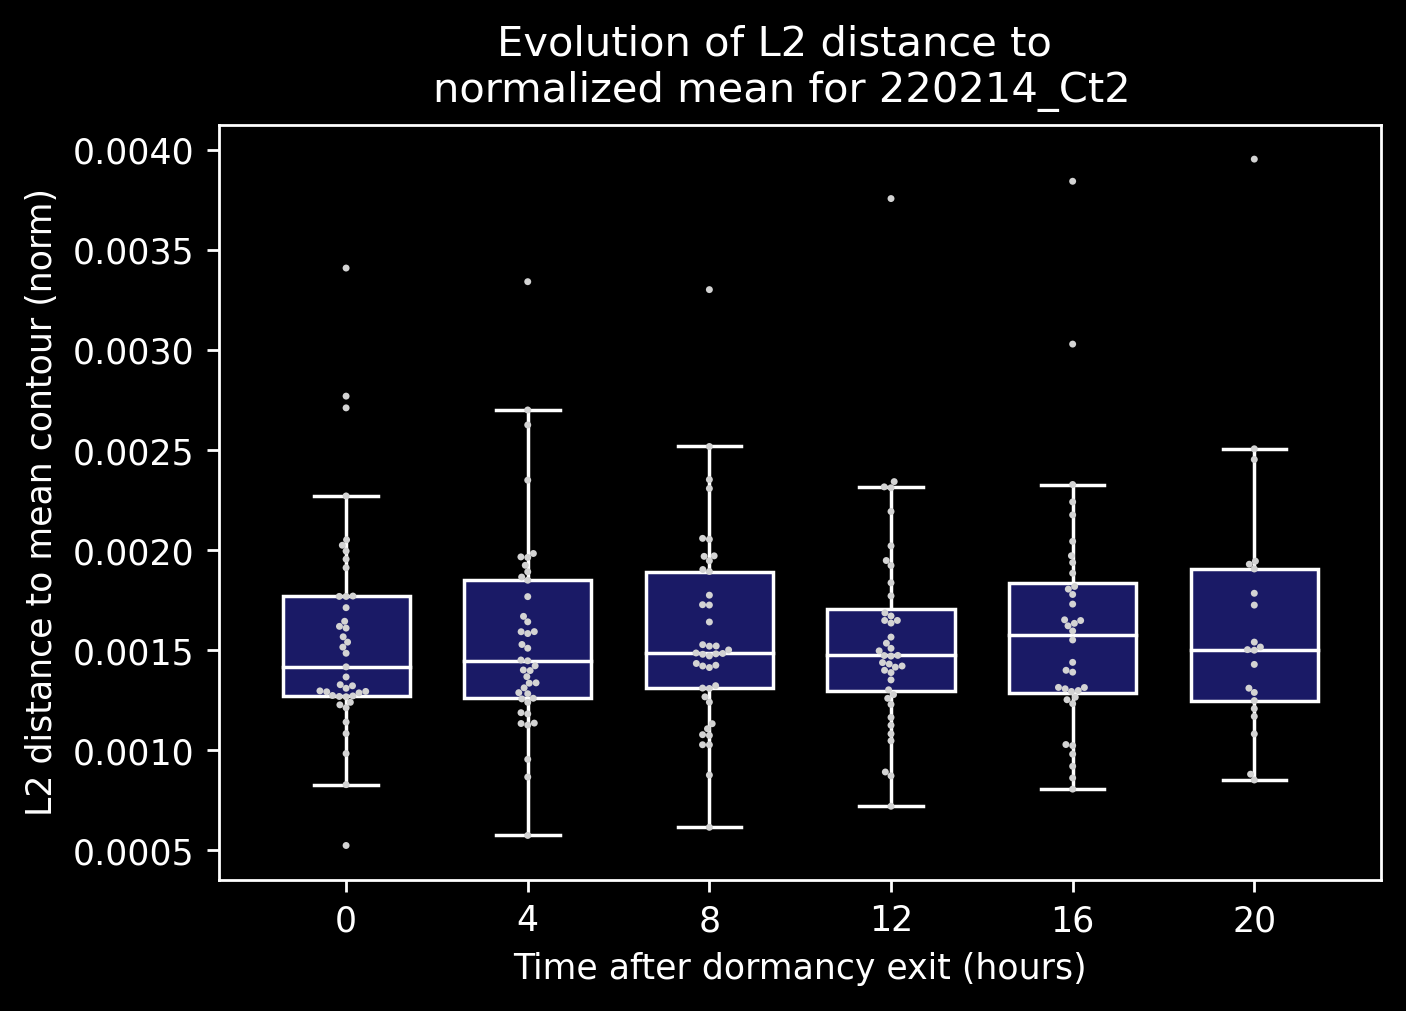

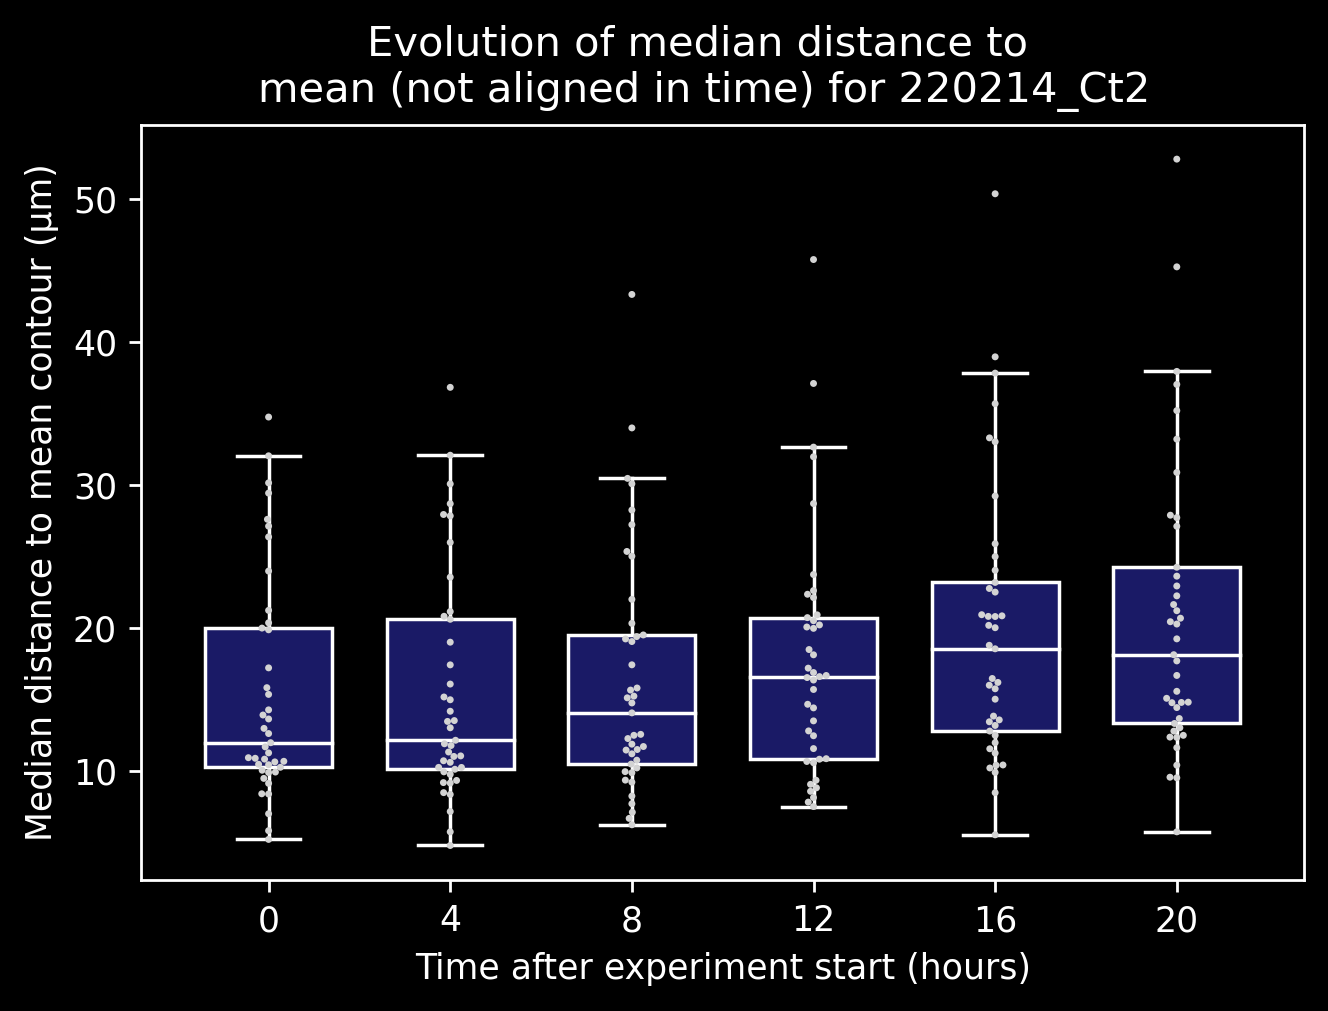

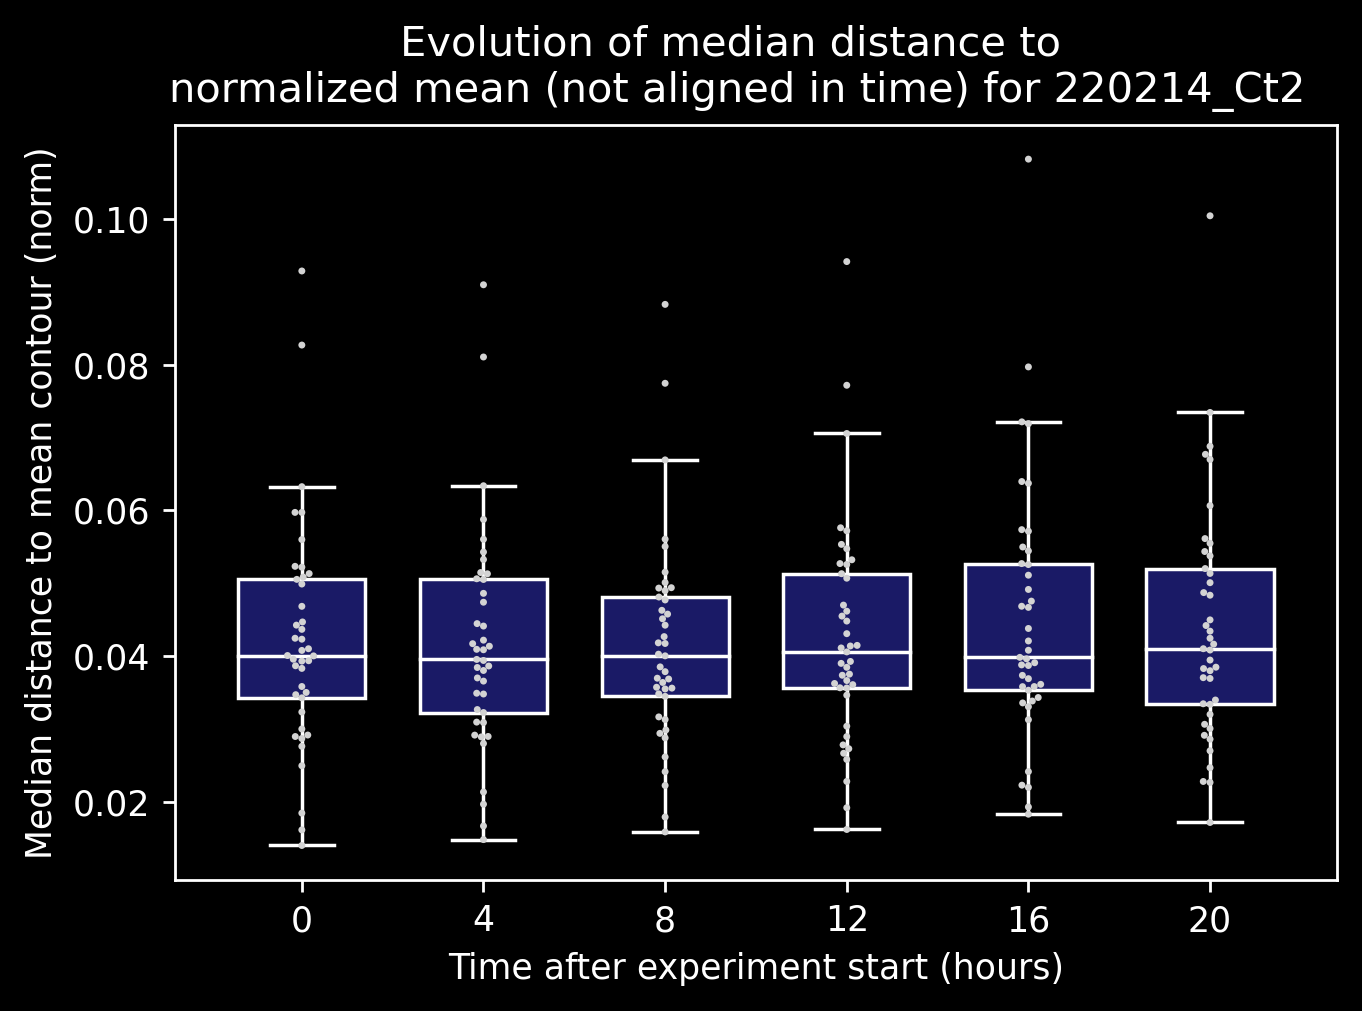

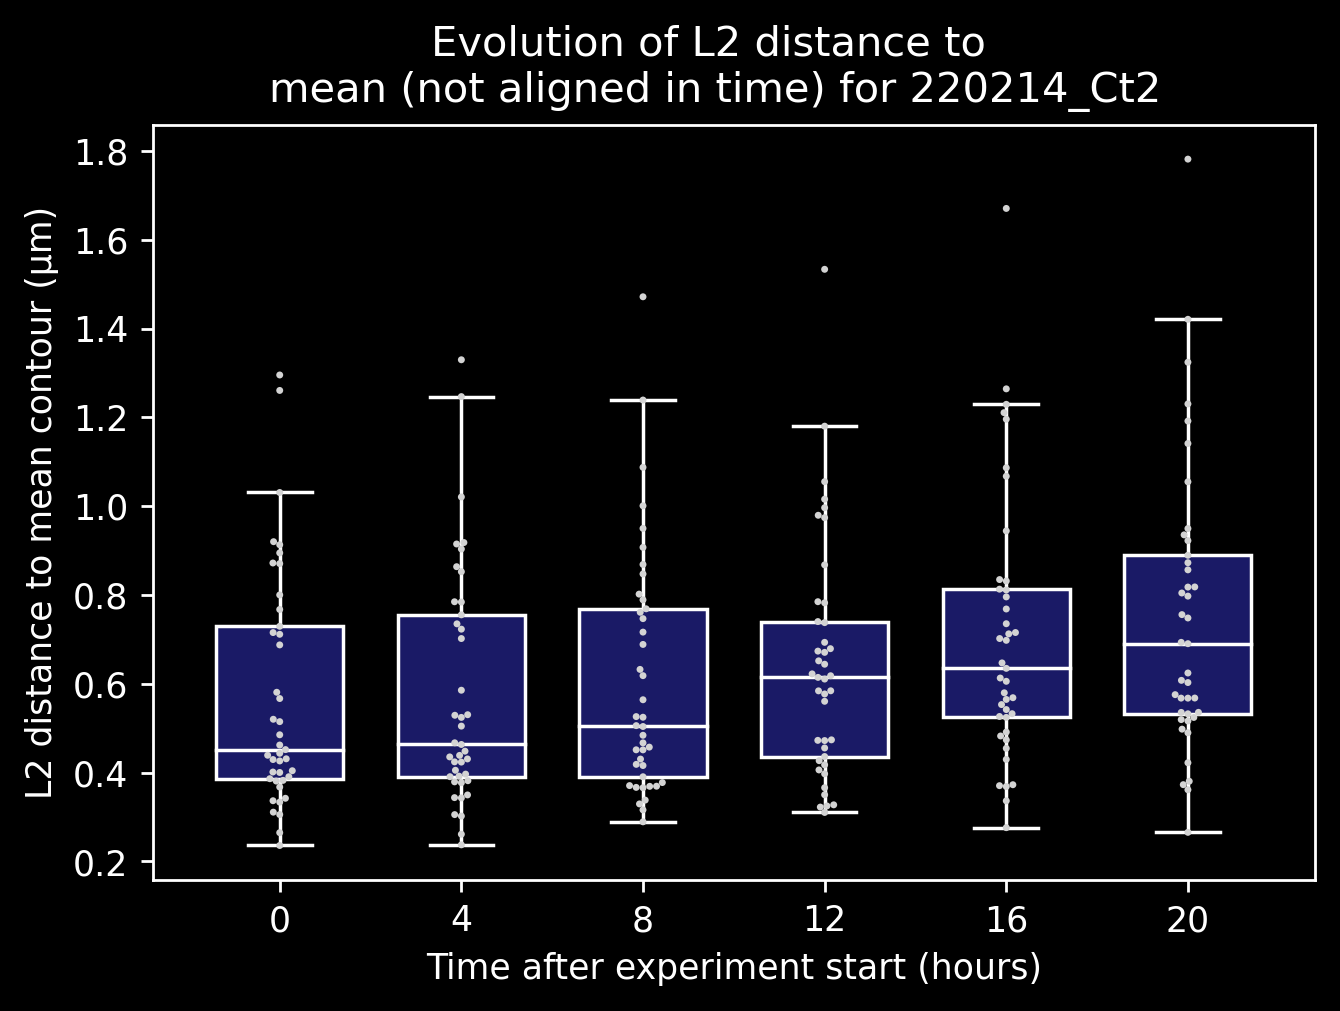

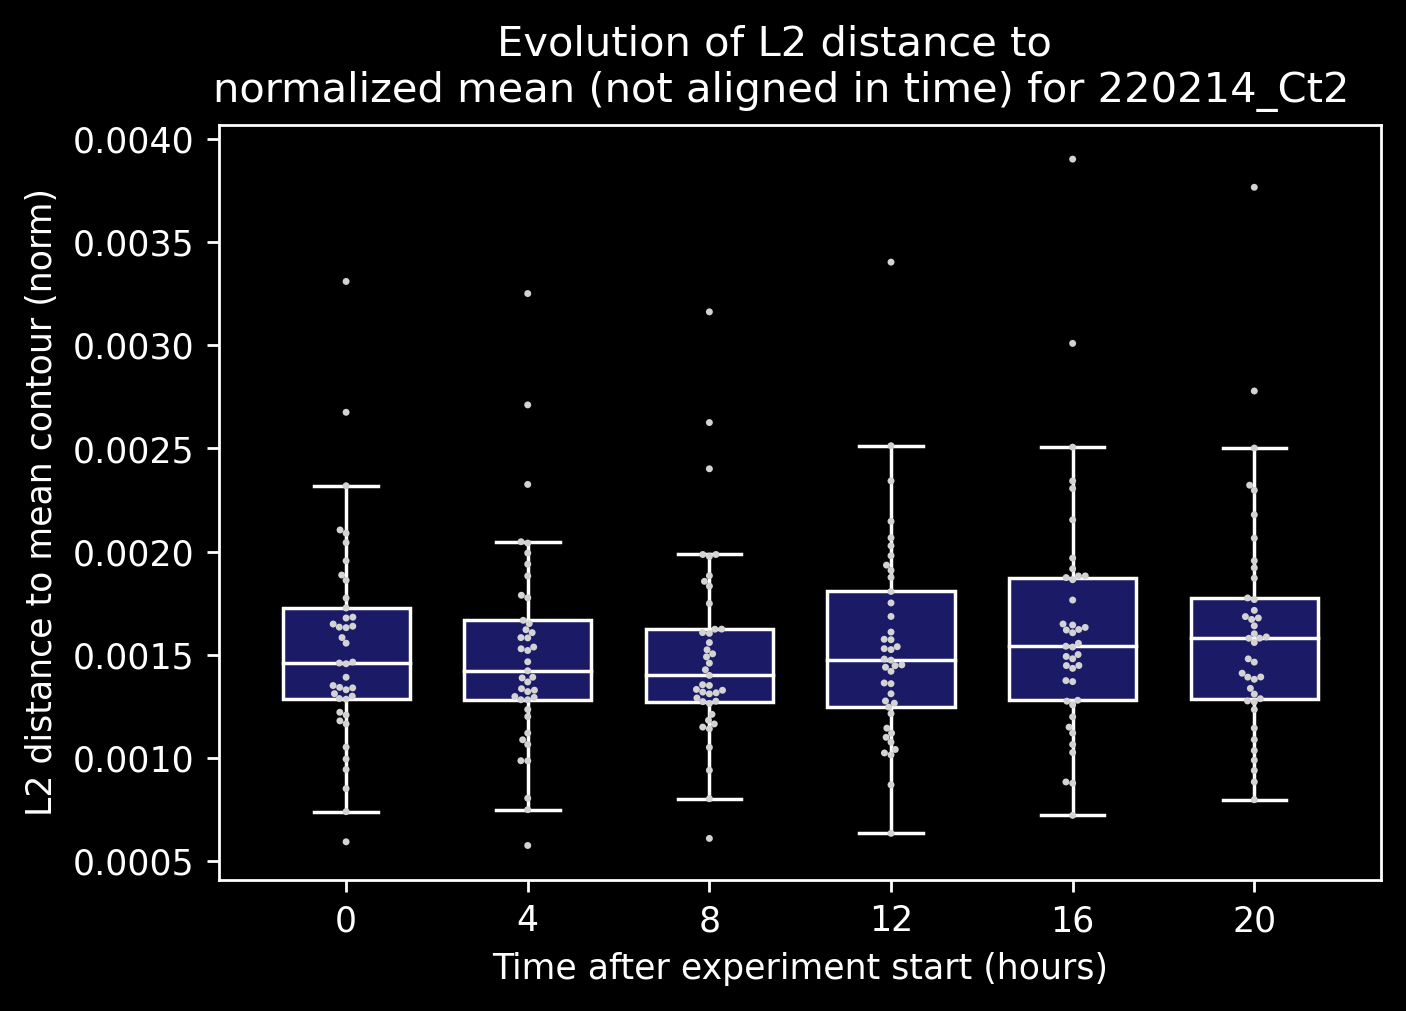

In [31]:
# ## Plots
# plotMeanDist(PFig,[GlobalData220124_Ct1,GlobalData220124_Ct2],
#              ['220124_Ct1','220124_Ct2'],[LightPurple, DarkPurple],range(0,25,4))

# plotMeanDist(PFig,[GlobalData220214_Ct1,GlobalData220214_Ct2],
#              ['220214_Ct1','220214_Ct2'],[LightBlue, DarkBlue],range(0,22,4))

plotMeanDist(PFig,[GlobalData220124_Ct2,GlobalData220214_Ct2,GlobalData220214_Ct1,GlobalData220124_Ct1],
             ['220124_Ct2','220214_Ct2','220214_Ct1','220124_Ct1'],[LightPurple, DarkPurple,LightBlue, DarkBlue],
             range(0,22,4))

##### Plot distance between mean contours

In [24]:
# DistBetwMean(PFig,[MeanCD220124_Ct1,MeanCD220124_Ct2,MeanCD220214_Ct1,MeanCD220214_Ct2],
#              [MeanGD220124_Ct1,MeanGD220124_Ct2,MeanGD220214_Ct1,MeanGD220214_Ct2],
#              ['220124_Ct1','220124_Ct2','220214_Ct1','220214_Ct2'], 
#              indiplots = True, commonplots= False)

 #### Plot growth of contours

In [25]:
# plotGrowth(PFig,GrowthD220124_Ct1,ContourData220124_Ct1,'220124_Ct1',350)  

# plotGrowth(PFig,GrowthDMean220124_Ct1,MeanCD220124_Ct1,'220124_Ct1',250)  

# plotGrowth(PFig,GrowthD220124_Ct2,ContourData220124_Ct2,'220124_Ct2',350)  

# plotGrowth(PFig,GrowthDMean220124_Ct2,MeanCD220124_Ct2,'220124_Ct2',250)  


# plotGrowth(PFig,GrowthD220214_Ct1_Osmo,ContourData220214_Ct1_Osmo,'220214_Ct1_Osmo',350)  

# plotGrowth(PFig,GrowthDMean220214_Ct1_Osmo,MeanCD220214_Ct1_Osmo,'220214_Ct1_Osmo',250)  

# plotGrowth(PFig,GrowthD220214_Ct2_Osmo,ContourData220214_Ct2_Osmo,'220214_Ct2_Osmo',350)  

# plotGrowth(PFig,GrowthDMean220214_Ct2_Osmo,MeanCD220214_Ct2_Osmo,'220214_Ct2_Osmo',250)  


# plotGrowth(PFig,GrowthD220214_Ct1,ContourData220214_Ct1,'220214_Ct1',350)  

# plotGrowth(PFig,GrowthDMean220214_Ct1,MeanCD220214_Ct1,'220214_Ct1',250)  

# plotGrowth(PFig,GrowthD220214_Ct2,ContourData220214_Ct2,'220214_Ct2',350)  

# plotGrowth(PFig,GrowthDMean220214_Ct2,MeanCD220214_Ct2,'220214_Ct2',250)  




#### Plot Symmetry distance

In [26]:
# plotSym(PFig,[GlobalData220124_Ct1,GlobalData220124_Ct2,GlobalData220214_Ct1,GlobalData220214_Ct2,
#               MeanGD220124_Ct1.loc['meanC'],MeanGD220124_Ct2.loc['meanC'],MeanGD220214_Ct1.loc['meanC'],
#               MeanGD220214_Ct2.loc['meanC']],['220124_Ct1','220124_Ct2','220214_Ct1','220214_Ct2',
#               '220124_Ct1_Mean','220124_Ct2_Mean','220214_Ct1_Mean','220214_Ct2_Mean',],
#             [Blue,Green,Purple,Yellow,DarkBlue,DarkGreen,DarkPurple,DarkYellow])

# plotSym(PFig,[MeanGD220124_Ct1.loc['meanC'],MeanGD220124_Ct2.loc['meanC'],MeanGD220214_Ct1.loc['meanC'],
#               MeanGD220214_Ct2.loc['meanC']],
#         ['220124_Ct1_Mean','220124_Ct2_Mean','220214_Ct1_Mean','220214_Ct2_Mean',],
#             [DarkBlue,DarkGreen,DarkPurple,DarkYellow])

# plotSym(PFig,[GlobalData220214_Ct1_Osmo,GlobalData220214_Ct2_Osmo,MeanGD220214_Ct1_Osmo.loc['meanC'],
#               MeanGD220214_Ct2_Osmo.loc['meanC']],['220214_Ct1_Osmo','220214_Ct2_Osmo',
#               '220214_Ct1_Osmo_Mean','220214_Ct2_Osmo_Mean'],
#             [Purple,Yellow,DarkPurple,DarkYellow])

## Test Zone

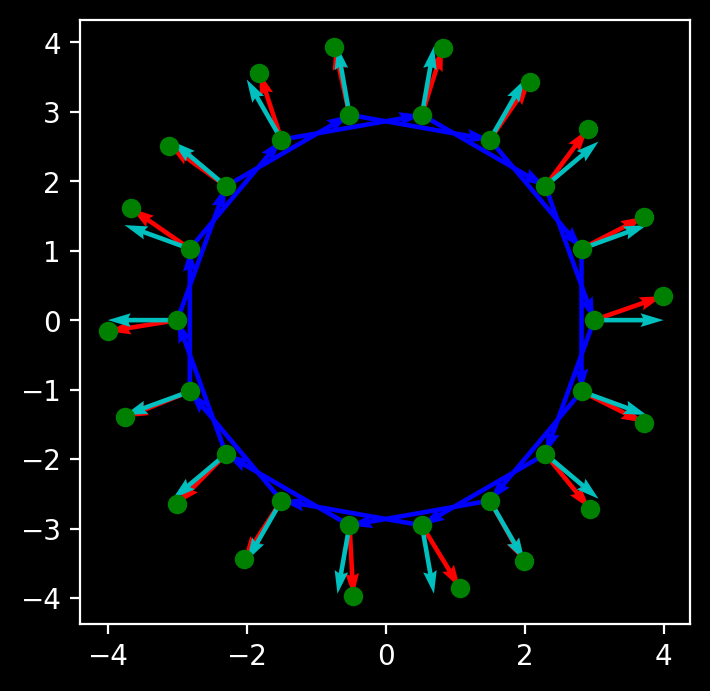

In [27]:
t = np.linspace(2*np.pi,0,19)[0:-1]
noise = (np.random.rand(len(t))-0.5)/5
R = 3
R2 = 4

Xi_1 = R*np.cos(t)
Yi_1 = R*np.sin(t)

Xi = R2*np.cos(t+noise)
Yi = R2*np.sin(t+noise)


            
growthVectors = [[xi-xi_1,yi-yi_1] for (xi,xi_1,yi,yi_1) in zip(Xi,Xi_1,Yi,Yi_1)]

contourVectors = [[x2-x1,y2-y1] for (x1,y1,x2,y2) in zip(np.roll(Xi_1,+1),np.roll(Yi_1,+1),np.roll(Xi_1,-1),np.roll(Yi_1,-1))]

normalVectors = [vf.getNormal(0,0,x,y,rotation='CCW') for (x,y) in contourVectors]


fig, ax = plt.subplots(dpi=200)

for [x,y],xi_1,yi_1 in zip(contourVectors,np.roll(Xi_1,+1),np.roll(Yi_1,+1)):
    ax.quiver(xi_1,yi_1,x,y,color='b',scale=1,scale_units='xy')
    
for [x,y],xi_1,yi_1 in zip(growthVectors,Xi_1,Yi_1):
    ax.quiver(xi_1,yi_1,x,y,color='r',scale=1,scale_units='xy')
    
for [x,y],xi_1,yi_1 in zip(normalVectors,Xi_1,Yi_1):
    ax.quiver(xi_1,yi_1,x,y,color='c',scale=1,scale_units='xy')
    
ax.plot(Xi_1,Yi_1, 'og')
ax.plot(Xi,Yi,'og')    
ax.set_aspect('equal')